<a href="https://colab.research.google.com/github/knkarthik01/reinforcement-learning/blob/master/c4_dynamic_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ⚡ Chapter 4: Dynamic Programming
# Mastering Computational Methods for Optimal Decision Making

"""
Welcome to the computational powerhouse of RL! 🚀

By the end of this notebook, you'll have:
- Mastered Policy Evaluation (the prediction problem)
- Implemented Policy Improvement (making policies better)
- Built complete Policy Iteration algorithm
- Optimized Value Iteration from Chapter 3
- Created Asynchronous DP methods
- Understood Generalized Policy Iteration framework
- Analyzed computational efficiency trade-offs

Let's unlock the full computational power of MDPs! ⚡
"""

In [1]:
# ================================
# 🔧 Setup and Enhanced Imports
# ================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle, FancyBboxPatch, ConnectionPatch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import pandas as pd
from collections import defaultdict, deque
import random
from IPython.display import clear_output, HTML, display
import time
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Enhanced plotting and timing
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("⚡ CHAPTER 4: DYNAMIC PROGRAMMING MASTERY")
print("=" * 55)
print("📚 WHAT YOU'LL MASTER:")
print("   🎯 Policy Evaluation: Computing values for any policy")
print("   📈 Policy Improvement: Making policies provably better")
print("   🔄 Policy Iteration: The complete alternating algorithm")
print("   ⚡ Value Iteration: Direct optimization approach")
print("   🚀 Asynchronous DP: Efficient computational methods")
print("   🌟 Generalized PI: The unifying framework")
print("   📊 Efficiency Analysis: When to use which method")
print()
print("🔧 Loading computational engines...")

⚡ CHAPTER 4: DYNAMIC PROGRAMMING MASTERY
📚 WHAT YOU'LL MASTER:
   🎯 Policy Evaluation: Computing values for any policy
   📈 Policy Improvement: Making policies provably better
   🔄 Policy Iteration: The complete alternating algorithm
   ⚡ Value Iteration: Direct optimization approach
   🚀 Asynchronous DP: Efficient computational methods
   🌟 Generalized PI: The unifying framework
   📊 Efficiency Analysis: When to use which method

🔧 Loading computational engines...


In [3]:
# ================================
# 🏗️ Enhanced Grid World for DP Analysis
# ================================

class DPGridWorld:
    """
    Enhanced Grid World specifically designed for DP algorithm analysis

    Features:
    - Configurable environments for testing different scenarios
    - Built-in timing and performance metrics
    - Support for stochastic transitions
    - Comprehensive state space analysis
    """

    def __init__(self, height=4, width=4, scenario='standard'):
        self.height = height
        self.width = width
        self.scenario = scenario

        # Initialize world
        self.rewards = {}
        self.terminals = set()
        self.obstacles = set()
        self.special_states = {}

        # Performance tracking
        self.computation_stats = {}

        self.setup_scenario(scenario)

    def setup_scenario(self, scenario):
        """Setup different testing scenarios"""

        if scenario == 'standard':
            self._setup_standard_world()
        elif scenario == 'cliff':
            self._setup_cliff_world()
        elif scenario == 'maze':
            self._setup_maze_world()
        elif scenario == 'multi_goal':
            self._setup_multi_goal_world()

    def _setup_standard_world(self):
        """Standard grid world from Chapter 3"""
        # Goal state
        self.rewards[(3, 3)] = +10
        self.terminals.add((3, 3))
        self.special_states[(3, 3)] = "🏆 Goal"

        # Traps
        self.rewards[(1, 1)] = -5
        self.rewards[(2, 1)] = -3
        self.special_states[(1, 1)] = "☠️ Big Trap"
        self.special_states[(2, 1)] = "⚠️ Small Trap"

        # Obstacles
        self.obstacles.add((1, 2))

        # Step cost
        self.default_reward = -0.1

    def _setup_cliff_world(self):
        """Cliff walking environment"""
        # Goal
        self.rewards[(3, 3)] = +10
        self.terminals.add((3, 3))
        self.special_states[(3, 3)] = "🏆 Goal"

        # Cliff (bottom row, except start and goal)
        for col in range(1, 3):
            self.rewards[(3, col)] = -100
            self.special_states[(3, col)] = "🏔️ Cliff"

        # Step cost
        self.default_reward = -1

    def _setup_maze_world(self):
        """Maze-like environment"""
        # Goal
        self.rewards[(3, 3)] = +10
        self.terminals.add((3, 3))
        self.special_states[(3, 3)] = "🏆 Goal"

        # Maze walls
        walls = [(1, 1), (1, 2), (2, 0), (0, 2)]
        for wall in walls:
            if wall[0] < self.height and wall[1] < self.width:
                self.obstacles.add(wall)

        # Small rewards for navigation
        self.rewards[(0, 3)] = +1
        self.rewards[(2, 3)] = +2
        self.special_states[(0, 3)] = "💎 Small Gem"
        self.special_states[(2, 3)] = "💰 Medium Gem"

        self.default_reward = -0.1

    def _setup_multi_goal_world(self):
        """Multiple terminal states"""
        # Multiple goals with different values
        goals = [((0, 3), 5), ((1, 3), 8), ((3, 3), 10)]

        for (row, col), reward in goals:
            if row < self.height and col < self.width:
                self.rewards[(row, col)] = reward
                self.terminals.add((row, col))
                self.special_states[(row, col)] = f"🎯 Goal ({reward})"

        # Some obstacles to make it interesting
        self.obstacles.update([(1, 1), (2, 1)])

        self.default_reward = -0.2

    def get_all_states(self):
        """Get all valid states"""
        states = []
        for row in range(self.height):
            for col in range(self.width):
                if (row, col) not in self.obstacles:
                    states.append((row, col))
        return states

    def get_possible_actions(self, state):
        """Get possible actions from state"""
        actions = []
        row, col = state

        # Check each direction
        if row > 0 and (row - 1, col) not in self.obstacles:
            actions.append('up')
        if row < self.height - 1 and (row + 1, col) not in self.obstacles:
            actions.append('down')
        if col > 0 and (row, col - 1) not in self.obstacles:
            actions.append('left')
        if col < self.width - 1 and (row, col + 1) not in self.obstacles:
            actions.append('right')

        return actions

    def get_next_state(self, state, action):
        """Get next state deterministically"""
        row, col = state

        if action == 'up':
            new_state = (row - 1, col)
        elif action == 'down':
            new_state = (row + 1, col)
        elif action == 'left':
            new_state = (row, col - 1)
        elif action == 'right':
            new_state = (row, col + 1)
        else:
            return state

        # Check bounds and obstacles
        new_row, new_col = new_state
        if (new_row < 0 or new_row >= self.height or
            new_col < 0 or new_col >= self.width or
            new_state in self.obstacles):
            return state

        return new_state

    def get_reward(self, state):
        """Get reward for being in state"""
        return self.rewards.get(state, self.default_reward)

    def visualize(self, values=None, policy=None, title="Grid World",
                  highlight_states=None, show_details=True):
        """Enhanced visualization for DP analysis"""

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Create color grid
        grid = np.zeros((self.height, self.width))

        for row in range(self.height):
            for col in range(self.width):
                state = (row, col)
                if state in self.obstacles:
                    grid[row, col] = -2
                elif state in self.terminals:
                    grid[row, col] = 3
                elif state in self.rewards:
                    if self.rewards[state] > 0:
                        grid[row, col] = 2
                    else:
                        grid[row, col] = -1
                else:
                    grid[row, col] = 0

        # Enhanced colormap
        colors = ['darkred', 'red', 'lightgray', 'lightgreen', 'green', 'gold']
        cmap = ListedColormap(colors)

        im = ax.imshow(grid, cmap=cmap, vmin=-2, vmax=3, alpha=0.8)

        # Grid lines
        for i in range(self.height + 1):
            ax.axhline(i - 0.5, color='black', linewidth=1.5)
        for j in range(self.width + 1):
            ax.axvline(j - 0.5, color='black', linewidth=1.5)

        # Add annotations
        for row in range(self.height):
            for col in range(self.width):
                state = (row, col)

                # Highlight special states
                if highlight_states and state in highlight_states:
                    highlight_circle = Circle((col, row), 0.4, fill=False,
                                            edgecolor='purple', linewidth=4)
                    ax.add_patch(highlight_circle)

                # State values
                if values and state in values and show_details:
                    value = values[state]
                    color = 'white' if value < 0 else 'black'
                    ax.text(col - 0.35, row + 0.35, f'V={value:.2f}',
                           ha='center', va='center', fontsize=8,
                           fontweight='bold', color=color,
                           bbox=dict(boxstyle="round,pad=0.1",
                                   facecolor='yellow', alpha=0.8))

                # Policy arrows
                if policy and state in policy and policy[state]:
                    action = policy[state]
                    arrows = {'up': '⬆️', 'down': '⬇️', 'left': '⬅️', 'right': '➡️'}
                    ax.text(col + 0.25, row - 0.25, arrows.get(action, '❓'),
                           ha='center', va='center', fontsize=14)

                # Special state emojis
                if state in self.special_states:
                    emoji = self.special_states[state].split()[0]
                    ax.text(col, row, emoji, ha='center', va='center', fontsize=16)

                # Coordinates
                ax.text(col - 0.4, row - 0.4, f'({row},{col})',
                       ha='center', va='center', fontsize=7, color='gray')

        ax.set_title(f'🗺️ {title}', fontsize=14, fontweight='bold')
        ax.set_xlim(-0.5, self.width - 0.5)
        ax.set_ylim(-0.5, self.height - 0.5)
        ax.set_xticks(range(self.width))
        ax.set_yticks(range(self.height))

        plt.tight_layout()
        return fig


🎯 PART 1: POLICY EVALUATION - The Prediction Problem


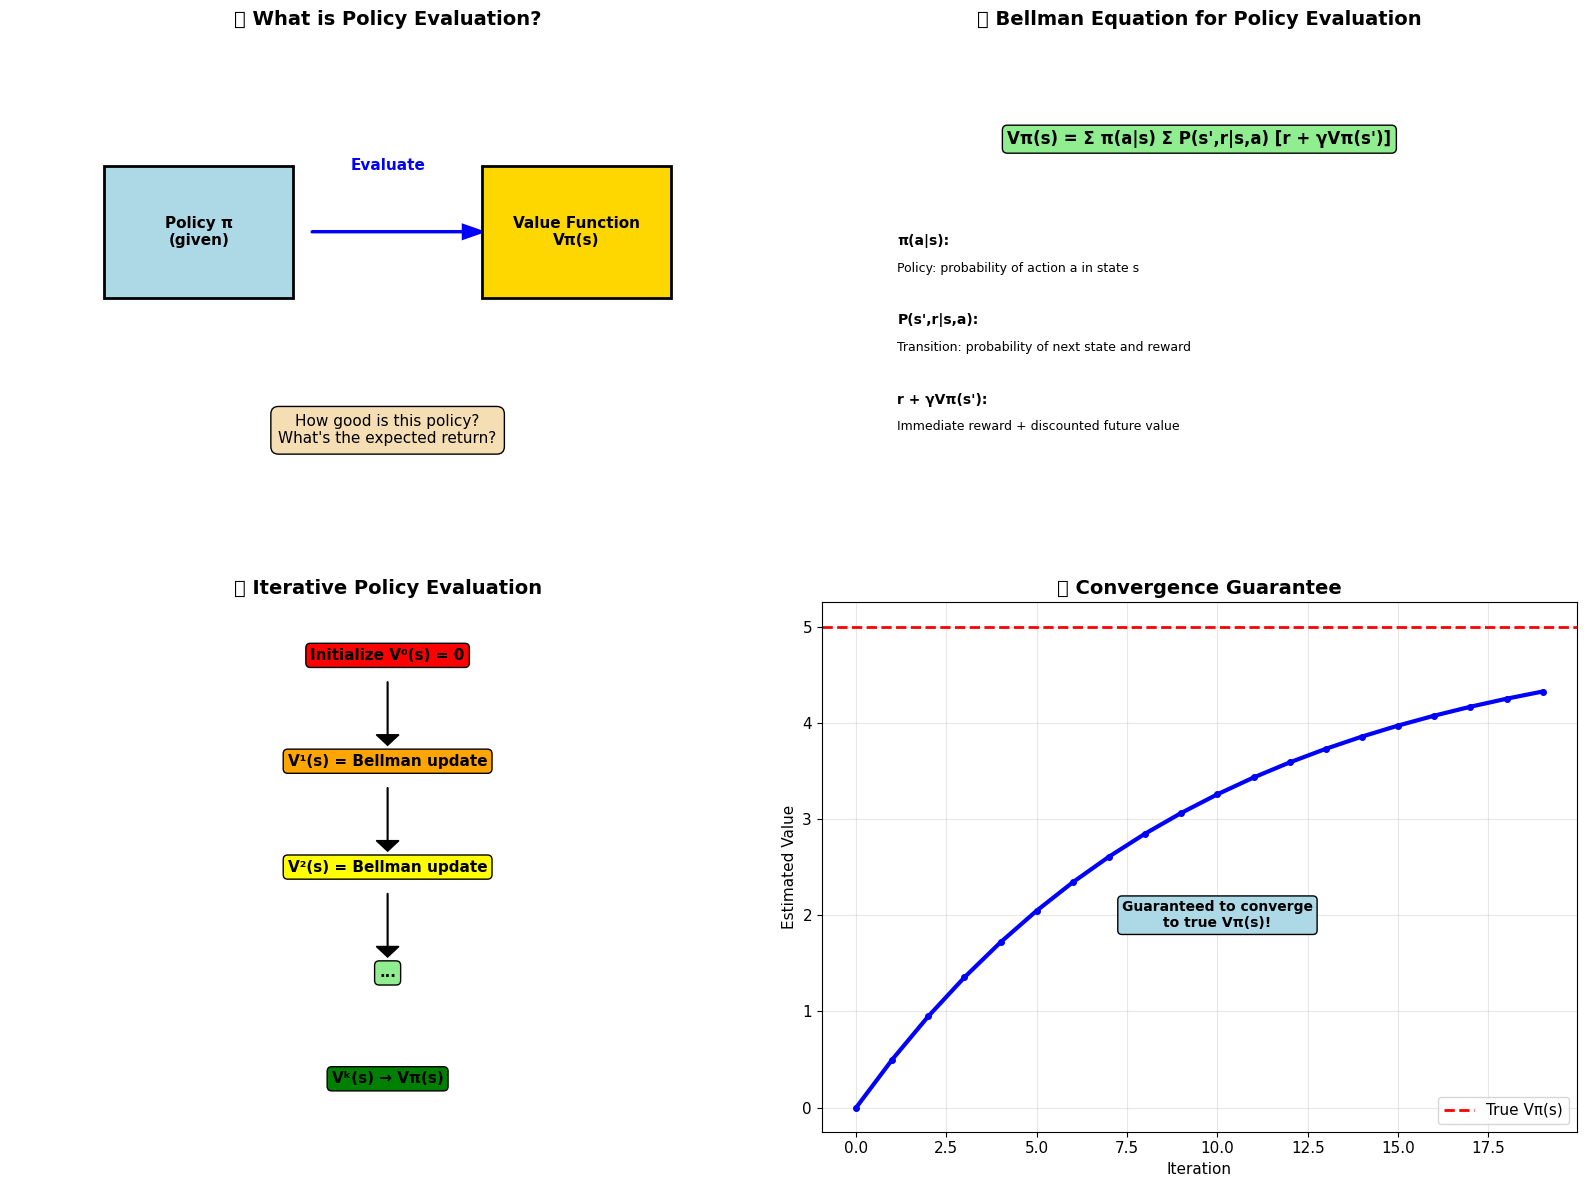

🏗️ SETTING UP TEST ENVIRONMENT


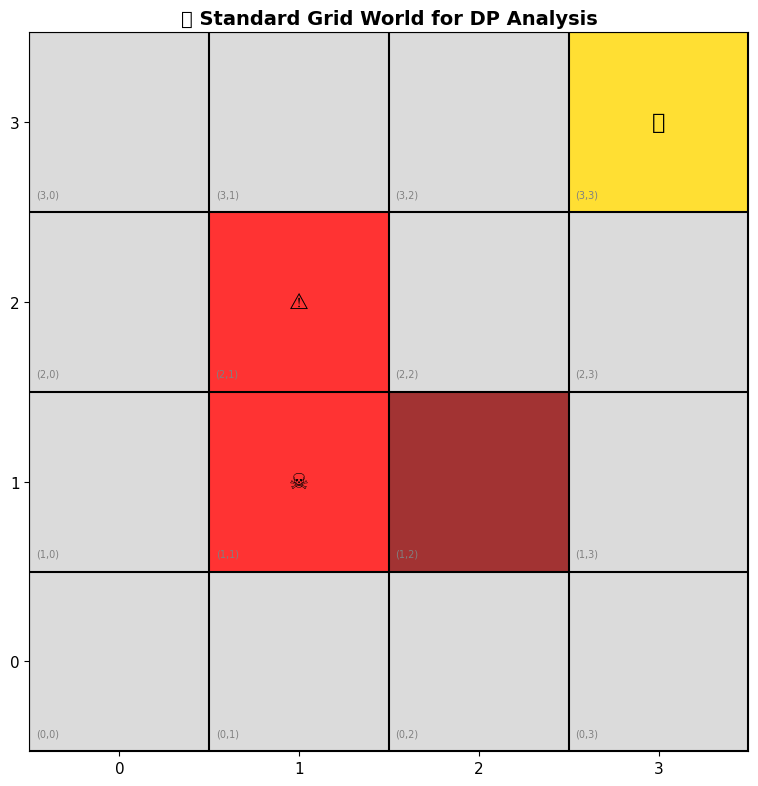


🧪 TESTING POLICY EVALUATION ON DIFFERENT POLICIES

📊 Evaluating 🎲 Random Policy
------------------------------
🔄 POLICY EVALUATION
   Policy type: function
   Discount factor: 0.9
   Tolerance: 1e-06
   Max iterations: 50

   Iteration   0: Max change = 3.00000000
   Iteration   1: Max change = 10.10000000
   Iteration   2: Max change = 7.59100000
   Iteration   3: Max change = 12.88100000
   Iteration   4: Max change = 9.30951000
   Iteration  10: Max change = 15.40004688
   Iteration  20: Max change = 15.26161667
   Iteration  30: Max change = 23.69696301
   Iteration  40: Max change = 18.24793842
   🏁 Results:
      Iterations to converge: 50
      Start state value: -6.745
      Average state value: -4.724
      Max state value: 10.000

📊 Evaluating 🎯 Greedy Policy
------------------------------
🔄 POLICY EVALUATION
   Policy type: function
   Discount factor: 0.9
   Tolerance: 1e-06
   Max iterations: 50

   Iteration   0: Max change = 10.00000000
   Iteration   1: Max change = 9.

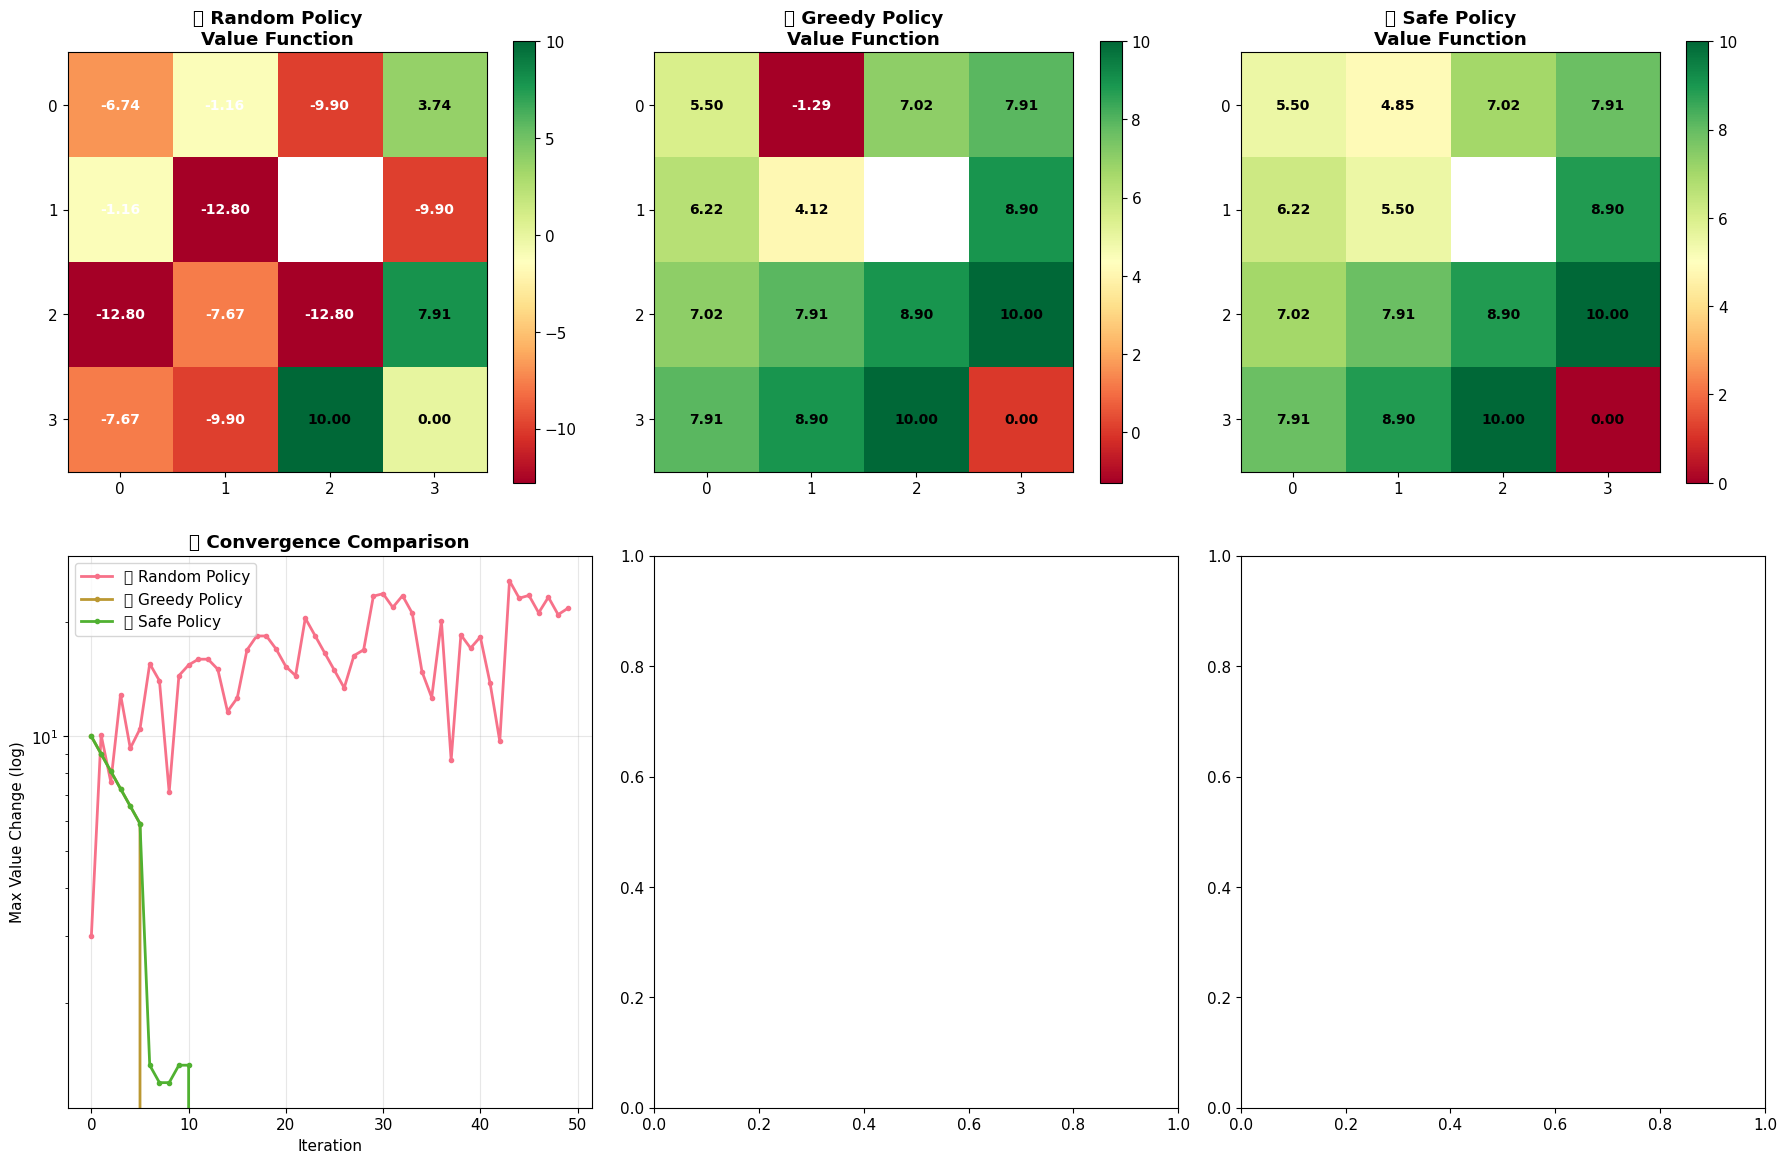

In [6]:
# ================================
# 🎯 Part 1: Policy Evaluation (Prediction Problem)
# ================================

print("\n🎯 PART 1: POLICY EVALUATION - The Prediction Problem")
print("=" * 60)

def create_policy_evaluation_theory():
    """Visual explanation of policy evaluation"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: What is Policy Evaluation?
    ax1.set_title('🎯 What is Policy Evaluation?', fontsize=14, fontweight='bold')

    # Policy box
    policy_box = Rectangle((1, 2), 2, 1, facecolor='lightblue',
                          edgecolor='black', linewidth=2)
    ax1.add_patch(policy_box)
    ax1.text(2, 2.5, 'Policy π\n(given)', ha='center', va='center', fontweight='bold')

    # Arrow
    ax1.arrow(3.2, 2.5, 1.6, 0, head_width=0.1, head_length=0.2,
             fc='blue', ec='blue', linewidth=2)
    ax1.text(4, 3, 'Evaluate', ha='center', va='center', fontweight='bold', color='blue')

    # Value function box
    value_box = Rectangle((5, 2), 2, 1, facecolor='gold',
                         edgecolor='black', linewidth=2)
    ax1.add_patch(value_box)
    ax1.text(6, 2.5, 'Value Function\nVπ(s)', ha='center', va='center', fontweight='bold')

    ax1.text(4, 1, 'How good is this policy?\nWhat\'s the expected return?',
             ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='wheat'))

    ax1.set_xlim(0, 8)
    ax1.set_ylim(0, 4)
    ax1.axis('off')

    # Diagram 2: Bellman Equation for Policy Evaluation
    ax2.set_title('🧮 Bellman Equation for Policy Evaluation', fontsize=14, fontweight='bold')

    # Mathematical equation
    ax2.text(0.5, 0.8, 'Vπ(s) = Σ π(a|s) Σ P(s\',r|s,a) [r + γVπ(s\')]',
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))

    # Components
    components = [
        ('π(a|s)', 'Policy: probability of action a in state s'),
        ('P(s\',r|s,a)', 'Transition: probability of next state and reward'),
        ('r + γVπ(s\')', 'Immediate reward + discounted future value')
    ]

    y_pos = 0.6
    for comp, desc in components:
        ax2.text(0.1, y_pos, f'{comp}:', fontweight='bold', fontsize=10)
        ax2.text(0.1, y_pos - 0.05, desc, fontsize=9)
        y_pos -= 0.15

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: Iterative Algorithm
    ax3.set_title('🔄 Iterative Policy Evaluation', fontsize=14, fontweight='bold')

    # Show iteration steps
    steps = ['Initialize V⁰(s) = 0', 'V¹(s) = Bellman update', 'V²(s) = Bellman update',
             '...', 'Vᵏ(s) → Vπ(s)']

    y_positions = [0.9, 0.7, 0.5, 0.3, 0.1]
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

    for i, (step, y, color) in enumerate(zip(steps, y_positions, colors)):
        ax3.text(0.5, y, step, ha='center', va='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color))

        if i < len(steps) - 1 and step != '...':
            ax3.arrow(0.5, y - 0.05, 0, -0.1, head_width=0.03, head_length=0.02,
                     fc='black', ec='black')

    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

    # Diagram 4: Convergence Guarantee
    ax4.set_title('✅ Convergence Guarantee', fontsize=14, fontweight='bold')

    # Convergence visualization
    iterations = np.arange(0, 20)
    true_value = 5.0
    values = true_value * (1 - 0.9**iterations)

    ax4.plot(iterations, values, 'b-', linewidth=3, marker='o', markersize=4)
    ax4.axhline(y=true_value, color='red', linestyle='--', linewidth=2,
               label='True Vπ(s)')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Estimated Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    ax4.text(10, 2, 'Guaranteed to converge\nto true Vπ(s)!',
             ha='center', va='center', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))

    plt.tight_layout()
    return fig

theory_fig = create_policy_evaluation_theory()
plt.show()

class PolicyEvaluator:
    """
    Comprehensive Policy Evaluation implementation with detailed analysis
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def evaluate_policy(self, policy, max_iterations=100, tolerance=1e-6,
                       track_history=True, verbose=True):
        """
        Iterative Policy Evaluation with comprehensive tracking

        Algorithm:
        1. Initialize V(s) = 0 for all s
        2. Repeat until convergence:
           For each state s:
             v = V(s)
             V(s) = Σ π(a|s) Σ P(s',r|s,a) [r + γV(s')]
             δ = max(δ, |v - V(s)|)
        3. Return V ≈ Vπ
        """

        if verbose:
            print(f"🔄 POLICY EVALUATION")
            print(f"   Policy type: {type(policy).__name__}")
            print(f"   Discount factor: {self.gamma}")
            print(f"   Tolerance: {tolerance}")
            print(f"   Max iterations: {max_iterations}")
            print()

        # Initialize value function
        V = {state: 0.0 for state in self.states}

        # Tracking data
        history = []
        convergence_data = []

        for iteration in range(max_iterations):
            V_new = V.copy()
            max_change = 0
            state_changes = {}

            # Update each state
            for state in self.states:
                if state in self.env.terminals:
                    V_new[state] = 0.0
                    continue

                # Calculate expected value under policy
                old_value = V[state]
                expected_value = 0.0

                # Get action from policy
                if callable(policy):
                    action = policy(state)
                    if action is None:
                        continue

                    # Deterministic policy case
                    next_state = self.env.get_next_state(state, action)
                    reward = self.env.get_reward(next_state)
                    expected_value = reward + self.gamma * V[next_state]

                elif isinstance(policy, dict):
                    # Policy can be a dictionary of state -> action
                    action = policy.get(state)
                    if action is None:
                        continue

                    next_state = self.env.get_next_state(state, action)
                    reward = self.env.get_reward(next_state)
                    expected_value = reward + self.gamma * V[next_state]

                V_new[state] = expected_value
                change = abs(V_new[state] - old_value)
                state_changes[state] = change
                max_change = max(max_change, change)

            # Update values
            V = V_new

            # Track convergence
            convergence_data.append(max_change)

            if track_history and iteration % 5 == 0:
                history.append(V.copy())

            # Progress reporting
            if verbose and (iteration % 10 == 0 or iteration < 5):
                print(f"   Iteration {iteration:3d}: Max change = {max_change:.8f}")

            # Check convergence
            if max_change < tolerance:
                if verbose:
                    print(f"   ✅ Converged after {iteration + 1} iterations!")
                break

        results = {
            'values': V,
            'iterations': iteration + 1,
            'converged': max_change < tolerance,
            'convergence_data': convergence_data,
            'history': history
        }

        return results

    def visualize_convergence(self, results, sample_states=None):
        """Visualize the convergence process"""

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # Plot 1: Convergence curve
        ax1 = axes[0, 0]
        convergence_data = results['convergence_data']

        ax1.semilogy(convergence_data, 'b-', linewidth=2, marker='o', markersize=4)
        ax1.set_title('📉 Convergence Curve', fontweight='bold')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Maximum Value Change (log scale)')
        ax1.grid(True, alpha=0.3)

        # Add convergence line
        ax1.axhline(y=1e-6, color='red', linestyle='--', alpha=0.7, label='Tolerance')
        ax1.legend()

        # Plot 2: Value evolution for sample states
        ax2 = axes[0, 1]
        if sample_states is None:
            sample_states = [self.states[0], self.states[len(self.states)//2], self.states[-1]]

        history = results['history']
        if history:
            for state in sample_states:
                if state in self.states:
                    values = [h[state] for h in history]
                    iterations = range(0, len(convergence_data), 5)[:len(values)]
                    ax2.plot(iterations, values, marker='o', label=f'State {state}', linewidth=2)

            ax2.set_title('📊 Value Evolution by State', fontweight='bold')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('State Value')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        # Plot 3: Final value distribution
        ax3 = axes[1, 0]
        final_values = list(results['values'].values())

        ax3.hist(final_values, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.set_title('📈 Final Value Distribution', fontweight='bold')
        ax3.set_xlabel('State Value')
        ax3.set_ylabel('Number of States')
        ax3.grid(True, alpha=0.3)

        # Add statistics
        mean_val = np.mean(final_values)
        std_val = np.std(final_values)
        ax3.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_val:.2f}')
        ax3.legend()

        # Plot 4: Convergence rate analysis
        ax4 = axes[1, 1]
        if len(convergence_data) > 1:
            # Calculate convergence rate
            rates = []
            for i in range(1, len(convergence_data)):
                if convergence_data[i-1] > 0:
                    rate = convergence_data[i] / convergence_data[i-1]
                    rates.append(rate)

            ax4.plot(rates, 'g-', linewidth=2, marker='s', markersize=4)
            ax4.set_title('📈 Convergence Rate', fontweight='bold')
            ax4.set_xlabel('Iteration')
            ax4.set_ylabel('Change Ratio')
            ax4.grid(True, alpha=0.3)

            # Theoretical rate
            ax4.axhline(y=self.gamma, color='red', linestyle='--',
                       label=f'Theoretical rate (γ={self.gamma})')
            ax4.legend()

        plt.tight_layout()
        return fig

# Create test environment and policies
print("🏗️ SETTING UP TEST ENVIRONMENT")
print("=" * 35)

# Create our test environment
env = DPGridWorld(height=4, width=4, scenario='standard')
fig = env.visualize(title="Standard Grid World for DP Analysis")
plt.show()

# Define test policies
def random_policy(state):
    """Random policy for baseline comparison"""
    actions = env.get_possible_actions(state)
    return random.choice(actions) if actions else None

def greedy_policy(state):
    """Simple greedy policy toward goal"""
    row, col = state
    target_row, target_col = 3, 3

    actions = env.get_possible_actions(state)
    if not actions:
        return None

    # Move toward target
    if row < target_row and 'down' in actions:
        return 'down'
    elif col < target_col and 'right' in actions:
        return 'right'
    elif row > target_row and 'up' in actions:
        return 'up'
    elif col > target_col and 'left' in actions:
        return 'left'
    else:
        return random.choice(actions)

def safe_policy(state):
    """Conservative policy avoiding traps"""
    dangerous_states = {(1, 1), (2, 1)}
    actions = env.get_possible_actions(state)

    safe_actions = []
    for action in actions:
        next_state = env.get_next_state(state, action)
        if next_state not in dangerous_states:
            safe_actions.append(action)

    if safe_actions:
        # Among safe actions, be greedy
        return greedy_policy(state) if greedy_policy(state) in safe_actions else random.choice(safe_actions)
    else:
        return random.choice(actions) if actions else None


# Test Policy Evaluation
print("\n🧪 TESTING POLICY EVALUATION ON DIFFERENT POLICIES")
print("=" * 55)

evaluator = PolicyEvaluator(env, gamma=0.9)

policies_to_test = [
    (random_policy, "🎲 Random Policy"),
    (greedy_policy, "🎯 Greedy Policy"),
    (safe_policy, "🛡️ Safe Policy")
]

policy_results = {}

for policy_func, policy_name in policies_to_test:
    print(f"\n📊 Evaluating {policy_name}")
    print("-" * 30)

    results = evaluator.evaluate_policy(policy_func, max_iterations=50, verbose=True)
    policy_results[policy_name] = results

    # Show key statistics
    final_values = results['values']
    print(f"   🏁 Results:")
    print(f"      Iterations to converge: {results['iterations']}")
    print(f"      Start state value: {final_values[(0,0)]:.3f}")
    print(f"      Average state value: {np.mean(list(final_values.values())):.3f}")
    print(f"      Max state value: {max(final_values.values()):.3f}")

# Visualize policy evaluation results
print("\n📊 VISUALIZING POLICY EVALUATION RESULTS")
print("=" * 45)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (policy_name, results) in enumerate(policy_results.items()):
    # Calculate row and column index correctly
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Create value heatmap
    values = results['values']
    value_grid = np.full((env.height, env.width), np.nan)

    for (r, c), value in values.items():
        value_grid[r, c] = value

    im = ax.imshow(value_grid, cmap='RdYlGn', interpolation='nearest')

    # Add value text
    for row in range(env.height):
        for col in range(env.width):
            if (row, col) in values:
                value = values[(row, col)]
                color = 'white' if value < 0 else 'black'
                ax.text(col, row, f'{value:.2f}', ha='center', va='center',
                       fontweight='bold', color=color, fontsize=10)

    ax.set_title(f'{policy_name}\nValue Function', fontweight='bold')
    ax.set_xticks(range(env.width))
    ax.set_yticks(range(env.height))

    plt.colorbar(im, ax=ax, shrink=0.8)

# Convergence comparison
ax_conv = axes[1, 0]
for policy_name, results in policy_results.items():
    convergence_data = results['convergence_data']
    ax_conv.semilogy(convergence_data, label=policy_name, linewidth=2, marker='o', markersize=3)

ax_conv.set_title('🏁 Convergence Comparison', fontweight='bold')
ax_conv.set_xlabel('Iteration')
ax_conv.set_ylabel('Max Value Change (log)')
ax_conv.legend()
ax_conv.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📈 PART 2: POLICY IMPROVEMENT - Making Policies Better


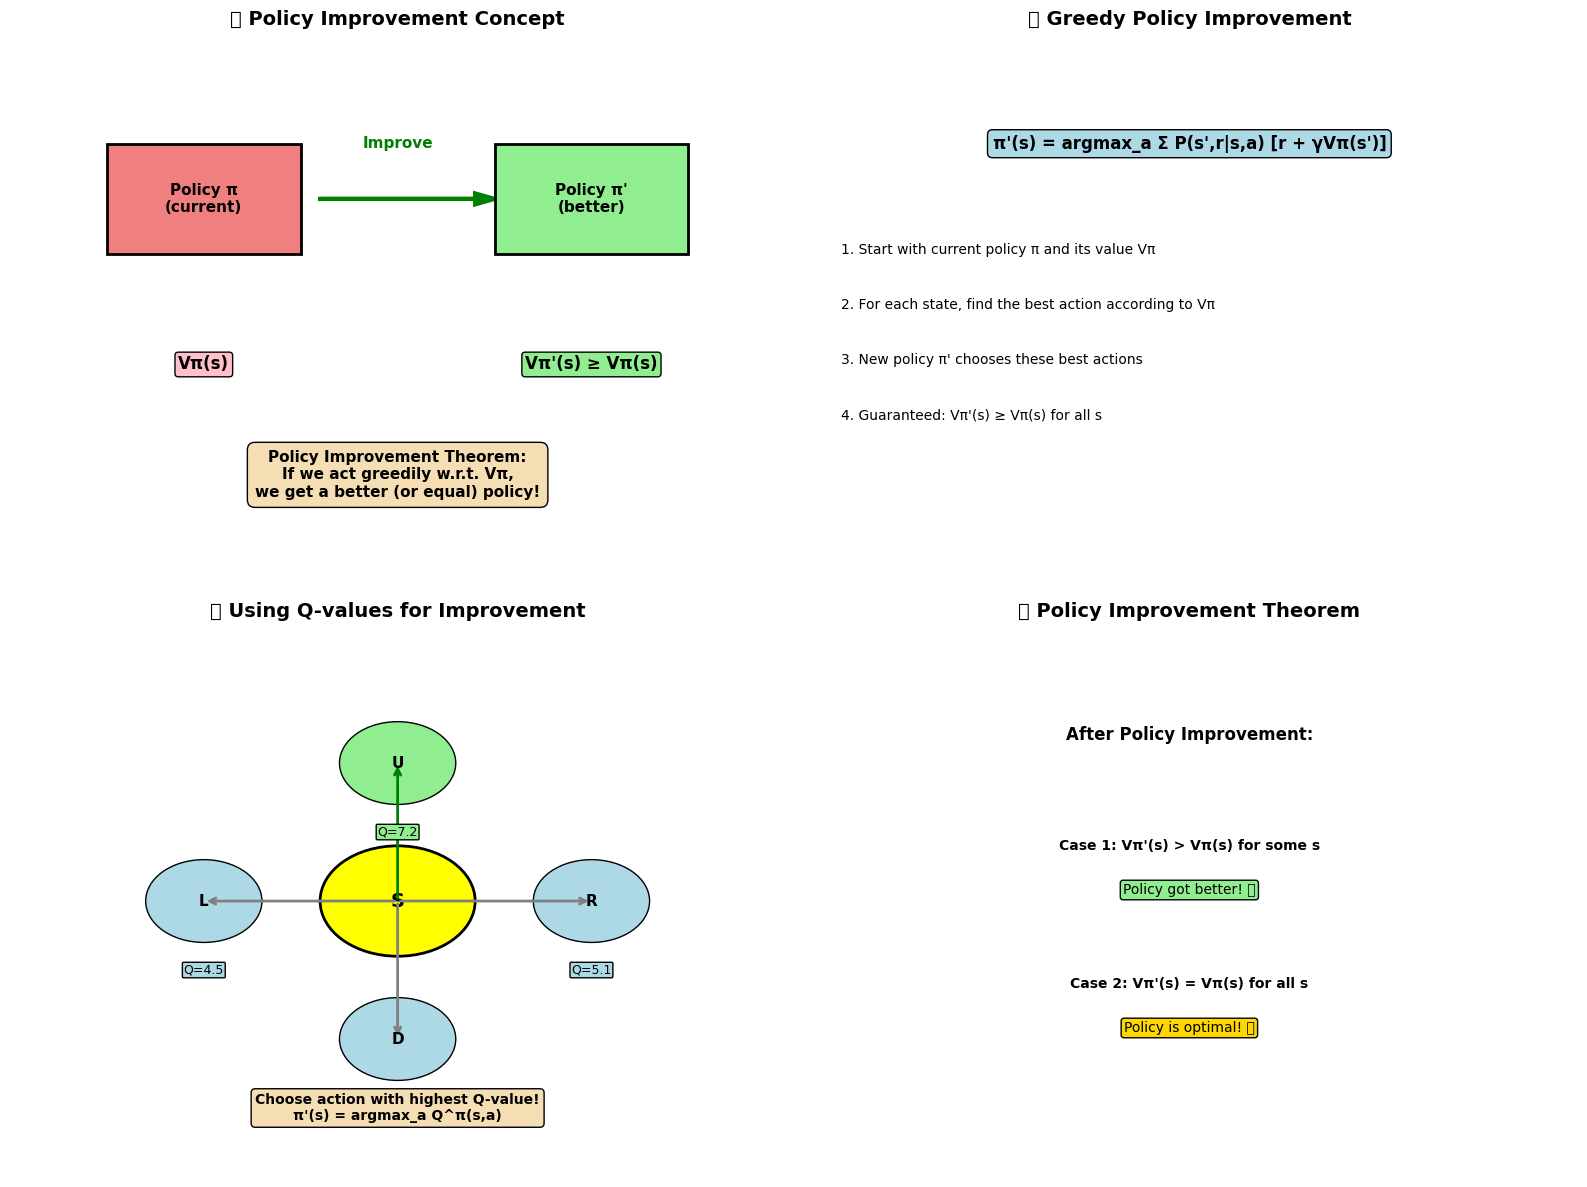


🧪 TESTING POLICY IMPROVEMENT
📊 Starting with Random Policy...

📈 Improving the Random Policy...
📈 POLICY IMPROVEMENT
   State (0, 1): left → right (Q: -11.315 → -2.891)
   State (0, 2): right → left (Q: -1.525 → 3.262)
   State (1, 0): up → right (Q: -11.315 → -7.791)
   State (2, 1): left → down (Q: -11.315 → 6.217)
   State (3, 0): up → right (Q: -11.315 → 6.217)
   State (3, 2): left → right (Q: 6.217 → 10.000)

   📊 Improvement Summary:
      States improved: 6/14
      Average improvement: 9.2633

📊 Evaluating the Improved Policy...

🏆 IMPROVEMENT ANALYSIS:
   Random policy start state value: -12.461
   Improved policy start state value: -0.958
   Improvement: +11.503


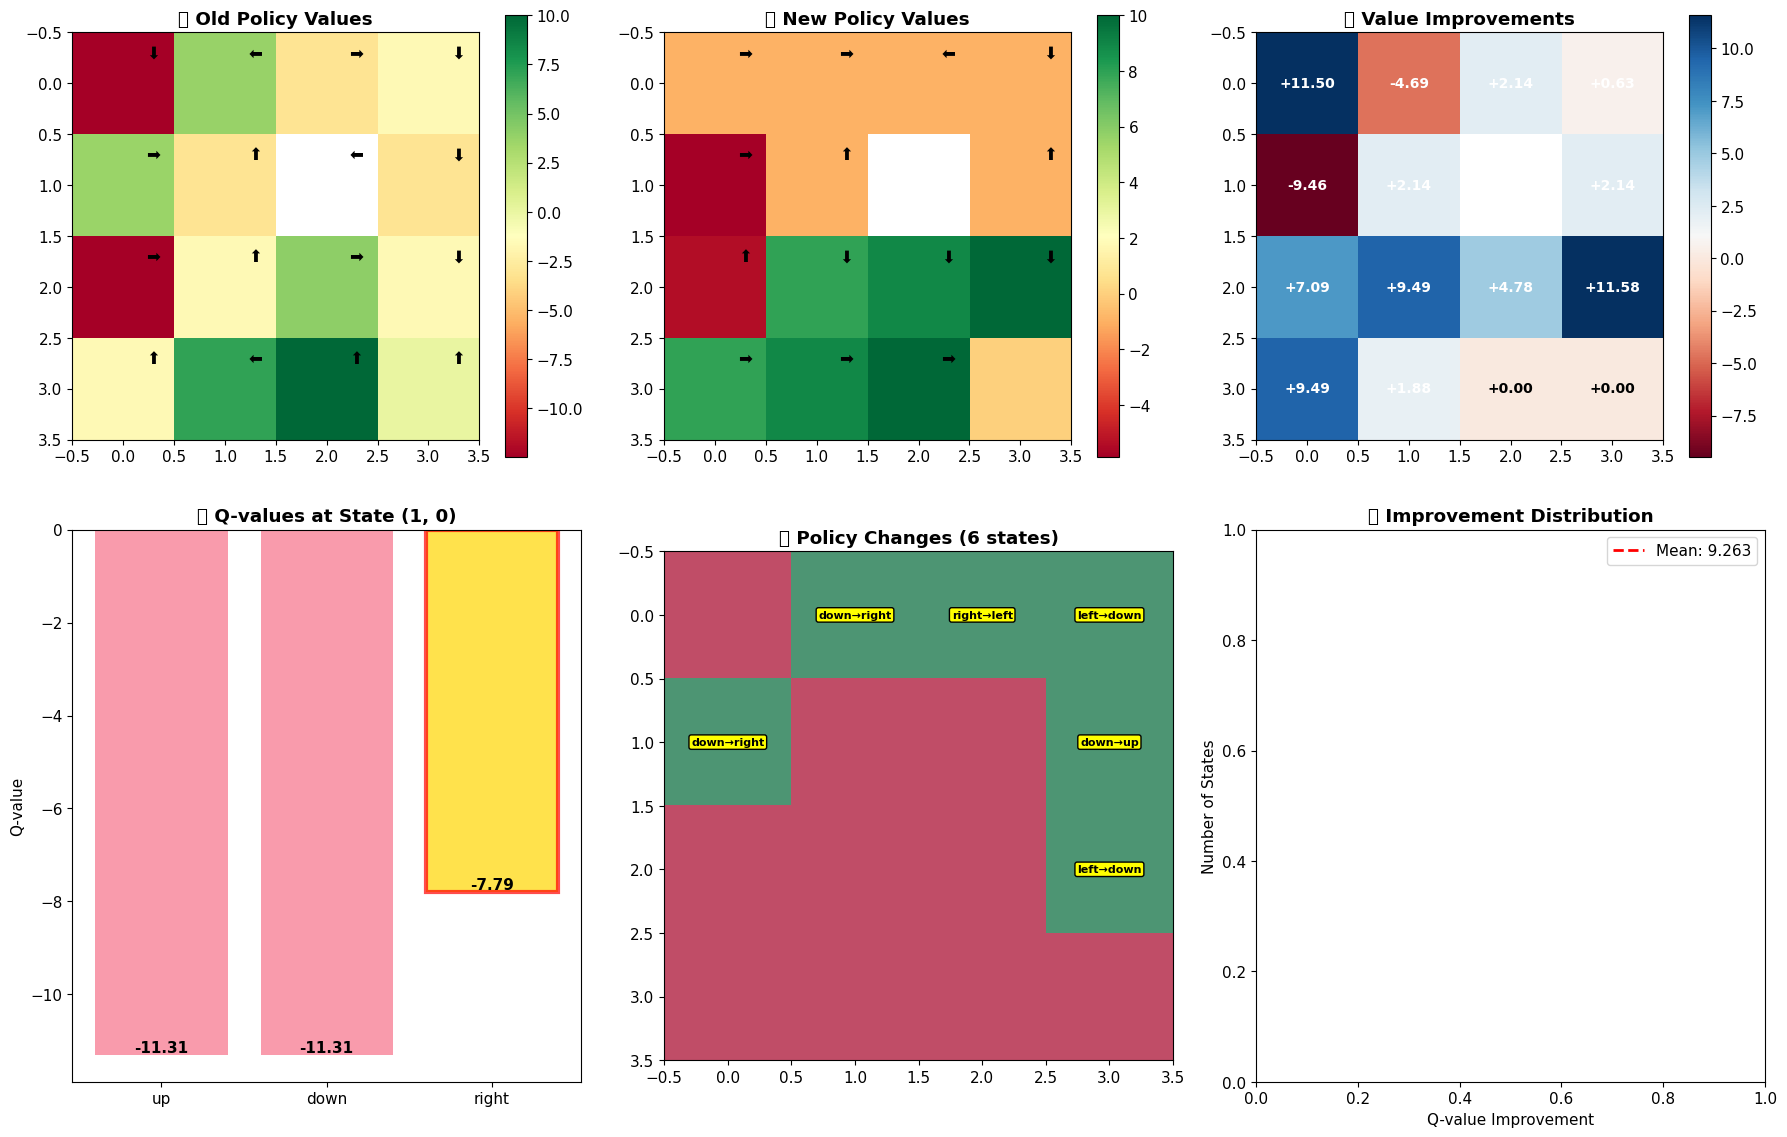

In [8]:
# ================================
# 🎯 Part 2: Policy Improvement
# ================================

print("\n📈 PART 2: POLICY IMPROVEMENT - Making Policies Better")
print("=" * 60)

def create_policy_improvement_theory():
    """Visual explanation of policy improvement"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: Policy Improvement Concept
    ax1.set_title('📈 Policy Improvement Concept', fontsize=14, fontweight='bold')

    # Current policy
    policy1_box = Rectangle((1, 3), 2, 1, facecolor='lightcoral',
                           edgecolor='black', linewidth=2)
    ax1.add_patch(policy1_box)
    ax1.text(2, 3.5, 'Policy π\n(current)', ha='center', va='center', fontweight='bold')

    # Arrow
    ax1.arrow(3.2, 3.5, 1.6, 0, head_width=0.1, head_length=0.2,
             fc='green', ec='green', linewidth=3)
    ax1.text(4, 4, 'Improve', ha='center', va='center', fontweight='bold', color='green')

    # Better policy
    policy2_box = Rectangle((5, 3), 2, 1, facecolor='lightgreen',
                           edgecolor='black', linewidth=2)
    ax1.add_patch(policy2_box)
    ax1.text(6, 3.5, 'Policy π\'\n(better)', ha='center', va='center', fontweight='bold')

    # Value functions
    ax1.text(2, 2, 'Vπ(s)', ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.2", facecolor='pink'))
    ax1.text(6, 2, 'Vπ\'(s) ≥ Vπ(s)', ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen'))

    ax1.text(4, 1, 'Policy Improvement Theorem:\nIf we act greedily w.r.t. Vπ,\nwe get a better (or equal) policy!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='wheat'))

    ax1.set_xlim(0, 8)
    ax1.set_ylim(0, 5)
    ax1.axis('off')

    # Diagram 2: Greedy Policy Improvement
    ax2.set_title('🎯 Greedy Policy Improvement', fontsize=14, fontweight='bold')

    # Mathematical formula
    ax2.text(0.5, 0.8, 'π\'(s) = argmax_a Σ P(s\',r|s,a) [r + γVπ(s\')]',
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))

    # Explanation
    explanation = [
        '1. Start with current policy π and its value Vπ',
        '2. For each state, find the best action according to Vπ',
        '3. New policy π\' chooses these best actions',
        '4. Guaranteed: Vπ\'(s) ≥ Vπ(s) for all s'
    ]

    y_pos = 0.6
    for step in explanation:
        ax2.text(0.05, y_pos, step, fontsize=10, ha='left')
        y_pos -= 0.1

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: Q-values for Policy Improvement
    ax3.set_title('🎲 Using Q-values for Improvement', fontsize=14, fontweight='bold')

    # Central state
    center = Circle((2, 2), 0.4, facecolor='yellow', edgecolor='black', linewidth=2)
    ax3.add_patch(center)
    ax3.text(2, 2, 'S', ha='center', va='center', fontweight='bold', fontsize=14)

    # Actions with Q-values
    actions = [
        (2, 3, 'up', 7.2, 'best'),
        (3, 2, 'right', 5.1, 'ok'),
        (2, 1, 'down', 3.0, 'bad'),
        (1, 2, 'left', 4.5, 'ok')
    ]

    for x, y, action, q_val, quality in actions:
        color = 'lightgreen' if quality == 'best' else 'lightblue'
        action_circle = Circle((x, y), 0.3, facecolor=color, edgecolor='black')
        ax3.add_patch(action_circle)

        # Arrow to action
        ax3.annotate('', xy=(x, y), xytext=(2, 2),
                    arrowprops=dict(arrowstyle='->', lw=2,
                                  color='green' if quality == 'best' else 'gray'))

        ax3.text(x, y, action[:1].upper(), ha='center', va='center', fontweight='bold')
        ax3.text(x, y-0.5, f'Q={q_val}', ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.1", facecolor=color))

    ax3.text(2, 0.5, 'Choose action with highest Q-value!\nπ\'(s) = argmax_a Q^π(s,a)',
             ha='center', va='center', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat'))

    ax3.set_xlim(0, 4)
    ax3.set_ylim(0, 4)
    ax3.axis('off')

    # Diagram 4: Policy Improvement Guarantee
    ax4.set_title('✅ Policy Improvement Theorem', fontsize=14, fontweight='bold')

    # Show improvement or optimality
    ax4.text(0.5, 0.8, 'After Policy Improvement:', ha='center', va='center',
             fontsize=12, fontweight='bold')

    outcomes = [
        ('Case 1: Vπ\'(s) > Vπ(s) for some s', 'Policy got better! 📈', 'lightgreen'),
        ('Case 2: Vπ\'(s) = Vπ(s) for all s', 'Policy is optimal! 🏆', 'gold')
    ]

    y_pos = 0.6
    for case, result, color in outcomes:
        ax4.text(0.5, y_pos, case, ha='center', va='center', fontsize=10, fontweight='bold')
        ax4.text(0.5, y_pos - 0.08, result, ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color))
        y_pos -= 0.25

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

policy_improvement_theory_fig = create_policy_improvement_theory()
plt.show()

class PolicyImprover:
    """
    Policy Improvement implementation with detailed analysis
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def compute_q_values(self, values):
        """
        Compute Q-values from state values
        Q(s,a) = Σ P(s',r|s,a) [r + γV(s')]
        """
        q_values = {}

        for state in self.states:
            if state in self.env.terminals:
                continue

            q_values[state] = {}
            actions = self.env.get_possible_actions(state)

            for action in actions:
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                q_value = reward + self.gamma * values[next_state]
                q_values[state][action] = q_value

        return q_values

    def improve_policy(self, values, current_policy=None, verbose=True):
        """
        Policy Improvement: Create greedy policy w.r.t. value function

        Returns new policy and improvement statistics
        """

        if verbose:
            print("📈 POLICY IMPROVEMENT")
            print("=" * 25)

        # Compute Q-values
        q_values = self.compute_q_values(values)

        # Create new greedy policy
        new_policy = {}
        improvements = {}
        improvement_count = 0

        for state in self.states:
            if state in self.env.terminals:
                new_policy[state] = None
                continue

            if state not in q_values:
                new_policy[state] = None
                continue

            # Find best action
            state_q_values = q_values[state]
            if not state_q_values:
                new_policy[state] = None
                continue

            best_action = max(state_q_values.keys(), key=lambda a: state_q_values[a])
            best_q_value = state_q_values[best_action]

            new_policy[state] = best_action

            # Check if this is an improvement
            if current_policy is not None:
                old_action = current_policy(state) if callable(current_policy) else current_policy.get(state)
                if old_action and old_action in state_q_values:
                    old_q_value = state_q_values[old_action]
                    improvement = best_q_value - old_q_value
                    improvements[state] = improvement

                    if improvement > 1e-6:  # Significant improvement
                        improvement_count += 1
                        if verbose:
                            print(f"   State {state}: {old_action} → {best_action} "
                                  f"(Q: {old_q_value:.3f} → {best_q_value:.3f})")

        if verbose:
            print(f"\n   📊 Improvement Summary:")
            print(f"      States improved: {improvement_count}/{len([s for s in self.states if s not in self.env.terminals])}")
            if improvements:
                avg_improvement = np.mean([imp for imp in improvements.values() if imp > 0])
                print(f"      Average improvement: {avg_improvement:.4f}")

        results = {
            'policy': new_policy,
            'q_values': q_values,
            'improvements': improvements,
            'improved_states': improvement_count,
            'is_improvement': improvement_count > 0
        }

        return results

    def visualize_policy_improvement(self, old_values, new_values, old_policy, new_policy,
                                   q_values, improvements):
        """Visualize the policy improvement process"""

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot 1: Old policy values
        ax1 = axes[0, 0]
        old_value_grid = np.full((self.env.height, self.env.width), np.nan)
        for (r, c), value in old_values.items():
            old_value_grid[r, c] = value

        im1 = ax1.imshow(old_value_grid, cmap='RdYlGn', interpolation='nearest')
        ax1.set_title('📊 Old Policy Values', fontweight='bold')

        # Add policy arrows
        for row in range(self.env.height):
            for col in range(self.env.width):
                state = (row, col)
                if callable(old_policy):
                    action = old_policy(state)
                else:
                    action = old_policy.get(state)

                if action:
                    arrows = {'up': '⬆️', 'down': '⬇️', 'left': '⬅️', 'right': '➡️'}
                    ax1.text(col + 0.3, row - 0.3, arrows.get(action, '❓'),
                           ha='center', va='center', fontsize=12)

        plt.colorbar(im1, ax=ax1, shrink=0.8)

        # Plot 2: New policy values (after evaluation)
        ax2 = axes[0, 1]
        new_value_grid = np.full((self.env.height, self.env.width), np.nan)
        for (r, c), value in new_values.items():
            new_value_grid[r, c] = value

        im2 = ax2.imshow(new_value_grid, cmap='RdYlGn', interpolation='nearest')
        ax2.set_title('📈 New Policy Values', fontweight='bold')

        # Add new policy arrows
        for row in range(self.env.height):
            for col in range(self.env.width):
                state = (row, col)
                action = new_policy.get(state)

                if action:
                    arrows = {'up': '⬆️', 'down': '⬇️', 'left': '⬅️', 'right': '➡️'}
                    ax2.text(col + 0.3, row - 0.3, arrows.get(action, '❓'),
                           ha='center', va='center', fontsize=12)

        plt.colorbar(im2, ax=ax2, shrink=0.8)

        # Plot 3: Value differences
        ax3 = axes[0, 2]
        diff_grid = new_value_grid - old_value_grid

        im3 = ax3.imshow(diff_grid, cmap='RdBu', interpolation='nearest')
        ax3.set_title('🔄 Value Improvements', fontweight='bold')

        # Add improvement text
        for row in range(self.env.height):
            for col in range(self.env.width):
                if not np.isnan(diff_grid[row, col]):
                    diff = diff_grid[row, col]
                    color = 'white' if abs(diff) > 0.5 else 'black'
                    ax3.text(col, row, f'{diff:+.2f}', ha='center', va='center',
                           fontweight='bold', color=color, fontsize=10)

        plt.colorbar(im3, ax=ax3, shrink=0.8)

        # Plot 4: Q-value analysis for a sample state
        ax4 = axes[1, 0]
        sample_state = (1, 0)  # Choose an interesting state

        if sample_state in q_values:
            actions = list(q_values[sample_state].keys())
            q_vals = list(q_values[sample_state].values())

            bars = ax4.bar(actions, q_vals, alpha=0.7)

            # Highlight the chosen action
            if new_policy.get(sample_state) in actions:
                chosen_idx = actions.index(new_policy[sample_state])
                bars[chosen_idx].set_color('gold')
                bars[chosen_idx].set_edgecolor('red')
                bars[chosen_idx].set_linewidth(3)

            ax4.set_title(f'🎯 Q-values at State {sample_state}', fontweight='bold')
            ax4.set_ylabel('Q-value')

            # Add value labels
            for bar, q_val in zip(bars, q_vals):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{q_val:.2f}', ha='center', va='bottom', fontweight='bold')

        # Plot 5: Policy changes
        ax5 = axes[1, 1]

        # Count policy changes
        changes = {}
        for state in self.states:
            if state in self.env.terminals:
                continue

            old_action = old_policy(state) if callable(old_policy) else old_policy.get(state)
            new_action = new_policy.get(state)

            if old_action != new_action:
                changes[state] = (old_action, new_action)

        # Visualize changes
        change_grid = np.zeros((self.env.height, self.env.width))
        for (row, col) in changes:
            change_grid[row, col] = 1

        im5 = ax5.imshow(change_grid, cmap='RdYlGn', interpolation='nearest', alpha=0.7)
        ax5.set_title(f'🔄 Policy Changes ({len(changes)} states)', fontweight='bold')

        # Add change annotations
        for (row, col), (old_act, new_act) in changes.items():
            ax5.text(col, row, f'{old_act}→{new_act}', ha='center', va='center',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='yellow'))

        # Plot 6: Improvement statistics
        ax6 = axes[1, 2]

        if improvements:
            improvement_values = list(improvements.values())
            positive_improvements = [imp for imp in improvement_values if imp > 1e-6]

            if positive_improvements:
                ax6.hist(positive_improvements, bins=10, alpha=0.7, color='green',
                        edgecolor='black')
                ax6.set_title('📈 Improvement Distribution', fontweight='bold')
                ax6.set_xlabel('Q-value Improvement')
                ax6.set_ylabel('Number of States')

                # Add statistics
                mean_imp = np.mean(positive_improvements)
                ax6.axvline(mean_imp, color='red', linestyle='--', linewidth=2,
                           label=f'Mean: {mean_imp:.3f}')
                ax6.legend()
            else:
                ax6.text(0.5, 0.5, 'No significant\nimprovements\n(Policy is optimal!)',
                        ha='center', va='center', fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor='gold'))
        else:
             ax6.text(0.5, 0.5, 'No improvement data available.',
                        ha='center', va='center', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray'))


        ax6.set_xlim(0, 1)
        ax6.set_ylim(0, 1)

        plt.tight_layout()
        return fig

# Test Policy Improvement
print("\n🧪 TESTING POLICY IMPROVEMENT")
print("=" * 35)

# Start with a suboptimal policy and improve it
improver = PolicyImprover(env, gamma=0.9)

print("📊 Starting with Random Policy...")
random_results = evaluator.evaluate_policy(random_policy, max_iterations=30, verbose=False)
random_values = random_results['values']

print("\n📈 Improving the Random Policy...")
improvement_results = improver.improve_policy(random_values, random_policy, verbose=True)
improved_policy = improvement_results['policy']

print("\n📊 Evaluating the Improved Policy...")
improved_results = evaluator.evaluate_policy(improved_policy, max_iterations=30, verbose=False)
improved_values = improved_results['values']

# Compare the improvements
print(f"\n🏆 IMPROVEMENT ANALYSIS:")
print(f"   Random policy start state value: {random_values[(0,0)]:.3f}")
print(f"   Improved policy start state value: {improved_values[(0,0)]:.3f}")
print(f"   Improvement: {improved_values[(0,0)] - random_values[(0,0)]:+.3f}")

# Visualize the improvement process
improvement_viz = improver.visualize_policy_improvement(
    random_values, improved_values, random_policy, improved_policy,
    improvement_results['q_values'], improvement_results['improvements']
)
plt.show()


🔄 PART 3: POLICY ITERATION - The Complete Algorithm


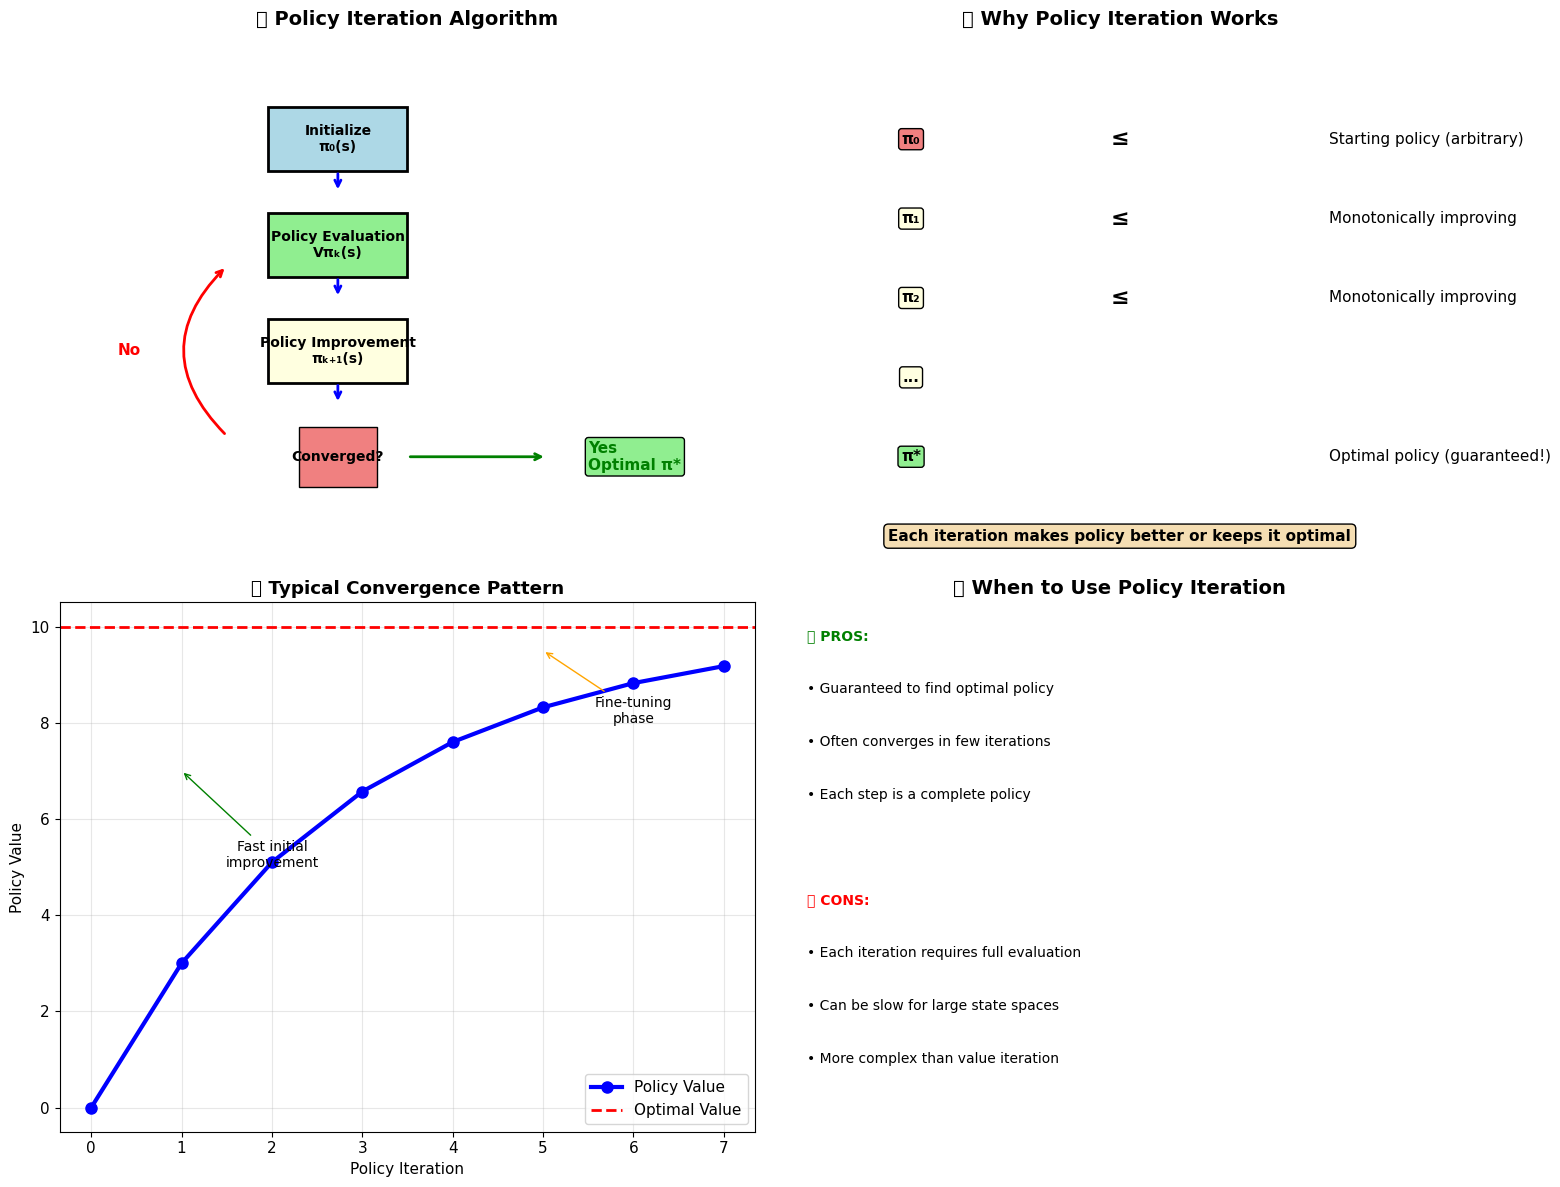

🔄 RUNNING COMPLETE POLICY ITERATION
🔄 POLICY ITERATION ALGORITHM
   Discount factor: 0.9
   Evaluation tolerance: 1e-06
   Max iterations: 10

📝 Initialized with random policy

🔄 POLICY ITERATION 1
------------------------------
📊 Step 1: Policy Evaluation
🔄 POLICY EVALUATION
   Policy type: dict
   Discount factor: 0.9
   Tolerance: 1e-06
   Max iterations: 100

   Iteration   0: Max change = 10.00000000
   Iteration   1: Max change = 9.00000000
   Iteration   2: Max change = 8.10000000
   Iteration   3: Max change = 2.18700000
   Iteration   4: Max change = 1.96830000
   Iteration  10: Max change = 1.04603532
   Iteration  20: Max change = 0.36472996
   Iteration  30: Max change = 0.12717347
   Iteration  40: Max change = 0.04434265
   Iteration  50: Max change = 0.01546133
   Iteration  60: Max change = 0.00539103
   Iteration  70: Max change = 0.00187974
   Iteration  80: Max change = 0.00065542
   Iteration  90: Max change = 0.00022853

📈 Step 2: Policy Improvement
📈 POLICY IMPROV

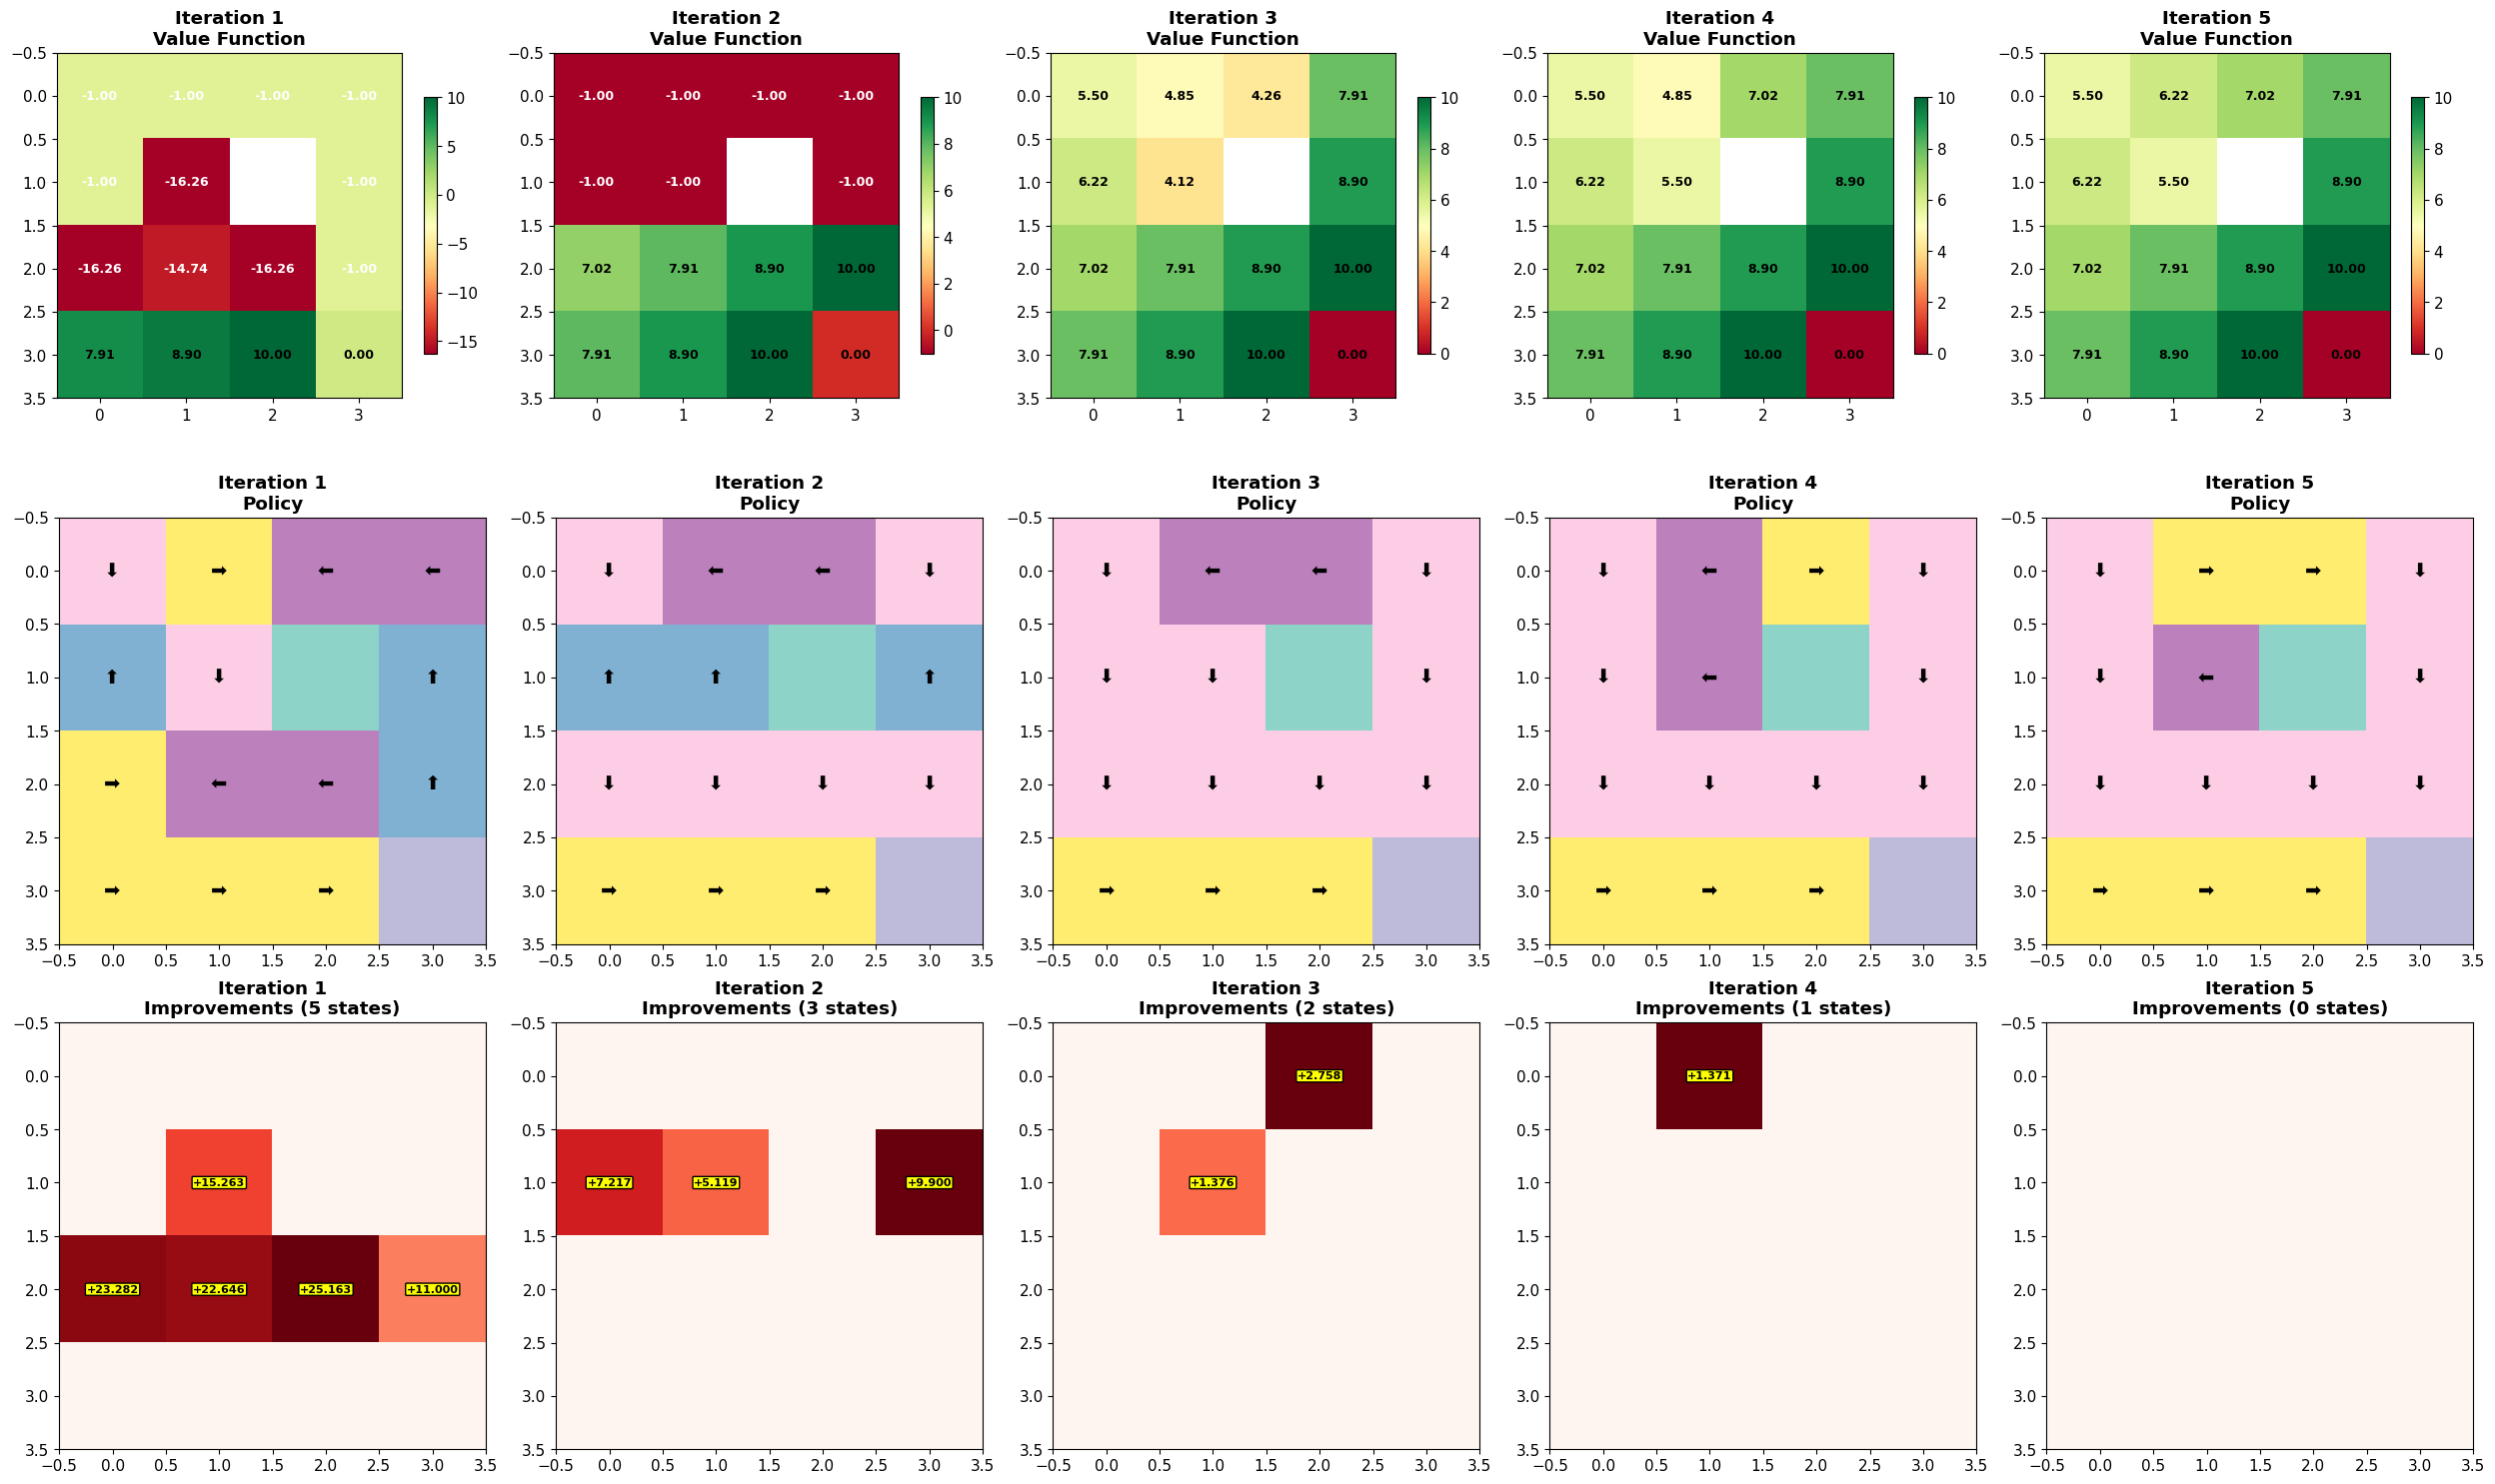

⚔️ POLICY ITERATION vs VALUE ITERATION
🔄 Running Policy Iteration...
⚡ Running Value Iteration...

📊 COMPARISON RESULTS:
Method               Iterations   Time (s)   Start Value 
-------------------------------------------------------
Policy Iteration     6            0.0065     5.4954      
Value Iteration      7            0.0004     5.4954      

🎯 Policy Agreement: 100.0% (14/14 states)
✅ Both methods found essentially the same optimal policy!


In [14]:
# ================================
# 🎯 Part 3: Policy Iteration - The Complete Algorithm
# ================================

print("\n🔄 PART 3: POLICY ITERATION - The Complete Algorithm")
print("=" * 60)

def create_policy_iteration_theory():
    """Visual explanation of the complete policy iteration algorithm"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: Policy Iteration Overview
    ax1.set_title('🔄 Policy Iteration Algorithm', fontsize=14, fontweight='bold')

    # Create flow diagram
    steps = [
        (2, 4, 'Initialize\nπ₀(s)', 'lightblue'),
        (2, 3, 'Policy Evaluation\nVπₖ(s)', 'lightgreen'),
        (2, 2, 'Policy Improvement\nπₖ₊₁(s)', 'lightyellow'),
        (2, 1, 'Converged?', 'lightcoral')
    ]

    for x, y, text, color in steps:
        if 'Converged' in text:
            # Diamond shape for decision
            diamond = mpatches.RegularPolygon((x, y), 4, radius=0.4,
                                            orientation=np.pi/4,
                                            facecolor=color, edgecolor='black')
            ax1.add_patch(diamond)
        else:
            # Rectangle for process
            rect = Rectangle((x-0.5, y-0.3), 1, 0.6, facecolor=color,
                           edgecolor='black', linewidth=2)
            ax1.add_patch(rect)

        ax1.text(x, y, text, ha='center', va='center', fontweight='bold', fontsize=10)

        # Add arrows
        if y > 1.5:
            ax1.annotate('', xy=(x, y-0.5), xytext=(x, y-0.3),
                        arrowprops=dict(arrowstyle='->', lw=2, color='blue'))

    # Loop back arrow
    ax1.annotate('', xy=(1.2, 2.8), xytext=(1.2, 1.2),
                arrowprops=dict(arrowstyle='->', lw=2, color='red',
                              connectionstyle="arc3,rad=-0.5"))
    ax1.text(0.5, 2, 'No', ha='center', va='center', fontweight='bold', color='red')

    # Finish arrow
    ax1.annotate('', xy=(3.5, 1), xytext=(2.5, 1),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    ax1.text(3.8, 1, 'Yes\nOptimal π*', ha='left', va='center',
             fontweight='bold', color='green',
             bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen'))

    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 5)
    ax1.axis('off')

    # Diagram 2: Why Policy Iteration Works
    ax2.set_title('✅ Why Policy Iteration Works', fontsize=14, fontweight='bold')

    # Show monotonic improvement
    policies = ['π₀', 'π₁', 'π₂', '...', 'π*']
    y_positions = [0.8, 0.65, 0.5, 0.35, 0.2]

    for i, (policy, y) in enumerate(zip(policies, y_positions)):
        color = 'lightcoral' if i == 0 else 'lightgreen' if i == len(policies)-1 else 'lightyellow'

        ax2.text(0.2, y, policy, ha='center', va='center', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color))

        # Value comparison
        if i < len(policies) - 1 and policy != '...':
            ax2.text(0.5, y, '≤', ha='center', va='center', fontsize=16, fontweight='bold')

        # Explanation
        if i == 0:
            ax2.text(0.8, y, 'Starting policy (arbitrary)', ha='left', va='center')
        elif i == len(policies) - 1:
            ax2.text(0.8, y, 'Optimal policy (guaranteed!)', ha='left', va='center')
        elif policy != '...':
            ax2.text(0.8, y, 'Monotonically improving', ha='left', va='center')

    ax2.text(0.5, 0.05, 'Each iteration makes policy better or keeps it optimal',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat'))

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: Convergence Properties
    ax3.set_title('📊 Convergence Properties', fontsize=14, fontweight='bold')

    # Simulate convergence
    iterations = np.arange(0, 8)
    values = 10 * (1 - 0.7**iterations)  # Exponential approach to optimum

    ax3.plot(iterations, values, 'bo-', linewidth=3, markersize=8, label='Policy Value')
    ax3.axhline(y=10, color='red', linestyle='--', linewidth=2, label='Optimal Value')

    ax3.set_xlabel('Policy Iteration')
    ax3.set_ylabel('Policy Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_title('📈 Typical Convergence Pattern', fontweight='bold')

    # Add annotations
    ax3.annotate('Fast initial\nimprovement', xy=(1, 7), xytext=(2, 5),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10, ha='center')

    ax3.annotate('Fine-tuning\nphase', xy=(5, 9.5), xytext=(6, 8),
                arrowprops=dict(arrowstyle='->', color='orange'),
                fontsize=10, ha='center')

    # Diagram 4: When to Use Policy Iteration
    ax4.set_title('🎯 When to Use Policy Iteration', fontsize=14, fontweight='bold')

    pros_cons = [
        ('✅ PROS:', 'green'),
        ('• Guaranteed to find optimal policy', 'black'),
        ('• Often converges in few iterations', 'black'),
        ('• Each step is a complete policy', 'black'),
        ('', 'white'),
        ('❌ CONS:', 'red'),
        ('• Each iteration requires full evaluation', 'black'),
        ('• Can be slow for large state spaces', 'black'),
        ('• More complex than value iteration', 'black')
    ]

    y_pos = 0.95
    for text, color in pros_cons:
        if text:
            ax4.text(0.05, y_pos, text, ha='left', va='top', fontsize=10,
                    fontweight='bold' if '✅' in text or '❌' in text else 'normal',
                    color=color)
        y_pos -= 0.1

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

policy_iteration_theory_fig = create_policy_iteration_theory()
plt.show()

class PolicyIterator:
    """
    Complete Policy Iteration algorithm with comprehensive analysis
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()
        self.evaluator = PolicyEvaluator(env, gamma)
        self.improver = PolicyImprover(env, gamma)

    def policy_iteration(self, initial_policy=None, max_iterations=10,
                        eval_tolerance=1e-6, verbose=True):
        """
        Complete Policy Iteration Algorithm

        1. Initialize policy π₀
        2. Repeat:
           a) Policy Evaluation: compute Vπₖ
           b) Policy Improvement: πₖ₊₁ = greedy(Vπₖ)
        3. Until πₖ₊₁ = πₖ (policy stable)
        """

        if verbose:
            print("🔄 POLICY ITERATION ALGORITHM")
            print("=" * 40)
            print(f"   Discount factor: {self.gamma}")
            print(f"   Evaluation tolerance: {eval_tolerance}")
            print(f"   Max iterations: {max_iterations}")
            print()

        # Initialize policy
        if initial_policy is None:
            current_policy = self._create_random_policy()
            if verbose:
                print("📝 Initialized with random policy")
        else:
            current_policy = initial_policy
            if verbose:
                print("📝 Starting with provided policy")

        # Track algorithm progress
        iteration_history = []
        policy_stable = False

        for iteration in range(max_iterations):
            if verbose:
                print(f"\n🔄 POLICY ITERATION {iteration + 1}")
                print("-" * 30)

            # Step 1: Policy Evaluation
            if verbose:
                print("📊 Step 1: Policy Evaluation")

            eval_results = self.evaluator.evaluate_policy(
                current_policy, tolerance=eval_tolerance, verbose=verbose
            )
            current_values = eval_results['values']

            # Step 2: Policy Improvement
            if verbose:
                print("\n📈 Step 2: Policy Improvement")

            improvement_results = self.improver.improve_policy(
                current_values, current_policy, verbose=verbose
            )
            new_policy = improvement_results['policy']

            # Check for policy stability
            if self._policies_equal(current_policy, new_policy):
                policy_stable = True
                if verbose:
                    print("\n✅ POLICY STABLE - OPTIMAL POLICY FOUND!")
                break

            # Store iteration data
            iteration_data = {
                'iteration': iteration + 1,
                'policy': current_policy.copy() if isinstance(current_policy, dict) else current_policy,
                'values': current_values.copy(),
                'eval_iterations': eval_results['iterations'],
                'improvements': improvement_results['improvements'],
                'improved_states': improvement_results['improved_states']
            }
            iteration_history.append(iteration_data)

            # Update policy for next iteration
            current_policy = new_policy

            if verbose:
                print(f"   States improved: {improvement_results['improved_states']}")

        # Final results
        if not policy_stable and verbose:
            print(f"\n⚠️ Reached maximum iterations ({max_iterations})")

        final_results = {
            'optimal_policy': current_policy,
            'optimal_values': current_values,
            'iterations': iteration + 1,
            'converged': policy_stable,
            'history': iteration_history
        }

        return final_results

    def _create_random_policy(self):
        """Create a random initial policy"""
        policy = {}
        for state in self.states:
            if state in self.env.terminals:
                policy[state] = None
            else:
                actions = self.env.get_possible_actions(state)
                policy[state] = random.choice(actions) if actions else None
        return policy

    def _policies_equal(self, policy1, policy2):
        """Check if two policies are identical"""
        if callable(policy1) or callable(policy2):
            # For function policies, check a sample of states
            for state in self.states:
                if state in self.env.terminals:
                    continue

                action1 = policy1(state) if callable(policy1) else policy1.get(state)
                action2 = policy2(state) if callable(policy2) else policy2.get(state)

                if action1 != action2:
                    return False
            return True
        else:
            # For dictionary policies
            for state in self.states:
                if policy1.get(state) != policy2.get(state):
                    return False
            return True

    def visualize_policy_iteration(self, results):
        """Visualize the complete policy iteration process"""

        history = results['history']
        if not history:
            print("No iteration history to visualize")
            return

        num_iterations = len(history)
        fig, axes = plt.subplots(3, num_iterations, figsize=(5*num_iterations, 15))

        if num_iterations == 1:
            axes = axes.reshape(-1, 1)

        for i, iteration_data in enumerate(history):
            iteration = iteration_data['iteration']
            values = iteration_data['values']
            policy = iteration_data['policy']

            # Row 1: Value Function
            ax_val = axes[0, i]
            value_grid = np.full((self.env.height, self.env.width), np.nan)
            for (r, c), value in values.items():
                value_grid[r, c] = value

            im_val = ax_val.imshow(value_grid, cmap='RdYlGn', interpolation='nearest')
            ax_val.set_title(f'Iteration {iteration}\nValue Function', fontweight='bold')

            # Add value text
            for row in range(self.env.height):
                for col in range(self.env.width):
                    if (row, col) in values:
                        value = values[(row, col)]
                        color = 'white' if value < 0 else 'black'
                        ax_val.text(col, row, f'{value:.2f}', ha='center', va='center',
                                   fontweight='bold', color=color, fontsize=9)

            plt.colorbar(im_val, ax=ax_val, shrink=0.6)

            # Row 2: Policy
            ax_pol = axes[1, i]
            policy_grid = np.zeros((self.env.height, self.env.width))

            # Color code different actions
            action_colors = {'up': 1, 'down': 2, 'left': 3, 'right': 4}

            for row in range(self.env.height):
                for col in range(self.env.width):
                    state = (row, col)
                    if state in self.env.obstacles:
                        policy_grid[row, col] = -1
                    elif state in self.env.terminals:
                        policy_grid[row, col] = 0
                    else:
                        action = policy.get(state) if isinstance(policy, dict) else policy(state)
                        if action:
                            policy_grid[row, col] = action_colors.get(action, 0)

            im_pol = ax_pol.imshow(policy_grid, cmap='Set3', interpolation='nearest')
            ax_pol.set_title(f'Iteration {iteration}\nPolicy', fontweight='bold')

            # Add policy arrows
            for row in range(self.env.height):
                for col in range(self.env.width):
                    state = (row, col)
                    action = policy.get(state) if isinstance(policy, dict) else policy(state)

                    if action:
                        arrows = {'up': '⬆️', 'down': '⬇️', 'left': '⬅️', 'right': '➡️'}
                        ax_pol.text(col, row, arrows.get(action, '❓'),
                                   ha='center', va='center', fontsize=14)

            # Row 3: Improvements
            ax_imp = axes[2, i]
            improvements = iteration_data.get('improvements', {})

            if improvements:
                improvement_grid = np.zeros((self.env.height, self.env.width))
                for (row, col), improvement in improvements.items():
                    improvement_grid[row, col] = max(0, improvement)  # Only positive improvements

                im_imp = ax_imp.imshow(improvement_grid, cmap='Reds', interpolation='nearest')
                ax_imp.set_title(f'Iteration {iteration}\nImprovements ({iteration_data["improved_states"]} states)',
                               fontweight='bold')

                # Add improvement text
                for (row, col), improvement in improvements.items():
                    if improvement > 1e-4:
                        ax_imp.text(col, row, f'+{improvement:.3f}', ha='center', va='center',
                                   fontweight='bold', fontsize=8,
                                   bbox=dict(boxstyle="round,pad=0.1", facecolor='yellow'))
            else:
                ax_imp.text(0.5, 0.5, 'No significant\nimprovements\n(Policy is optimal!)',
                           ha='center', va='center', fontsize=12, fontweight='bold',
                           transform=ax_imp.transAxes,
                           bbox=dict(boxstyle="round,pad=0.5", facecolor='gold'))
                ax_imp.set_xlim(0, 1)
                ax_imp.set_ylim(0, 1)
                ax_imp.axis('off')

        plt.tight_layout()
        return fig


    def compare_with_value_iteration(self, max_iterations=20):
        """Compare Policy Iteration with Value Iteration"""

        print("⚔️ POLICY ITERATION vs VALUE ITERATION")
        print("=" * 50)

        # Run Policy Iteration
        print("🔄 Running Policy Iteration...")
        pi_start_time = time.time()
        pi_results = self.policy_iteration(max_iterations=max_iterations, verbose=False)
        pi_time = time.time() - pi_start_time

        # Run Value Iteration
        print("⚡ Running Value Iteration...")
        vi_start_time = time.time()
        vi_solver = ValueIterationSolver(self.env, self.gamma)
        vi_results = vi_solver.value_iteration(max_iterations=100, verbose=False)
        vi_values = vi_results['values']
        vi_policy, _ = vi_solver.extract_policy(vi_values)
        vi_time = time.time() - vi_start_time

        # Compare results
        print(f"\n📊 COMPARISON RESULTS:")
        print(f"{'Method':<20} {'Iterations':<12} {'Time (s)':<10} {'Start Value':<12}")
        print("-" * 55)
        print(f"{'Policy Iteration':<20} {pi_results['iterations']:<12} {pi_time:<10.4f} {pi_results['optimal_values'][(0,0)]:<12.4f}")
        print(f"{'Value Iteration':<20} {vi_results['iterations']:<12} {vi_time:<10.4f} {vi_values[(0,0)]:<12.4f}")

        # Policy agreement check
        agreements = 0
        total_states = 0
        for state in self.states:
            if state not in self.env.terminals:
                total_states += 1
                pi_action = pi_results['optimal_policy'].get(state)
                vi_action = vi_policy.get(state)
                if pi_action == vi_action:
                    agreements += 1

        agreement_rate = agreements / total_states if total_states > 0 else 0
        print(f"\n🎯 Policy Agreement: {agreement_rate:.1%} ({agreements}/{total_states} states)")

        if agreement_rate > 0.95:
            print("✅ Both methods found essentially the same optimal policy!")
        else:
            print("⚠️ Methods found different policies - worth investigating!")

        return {
            'policy_iteration': pi_results,
            'value_iteration': {'values': vi_values, 'policy': vi_policy, 'time': vi_time},
            'agreement_rate': agreement_rate
        }


# Run Policy Iteration
print("🔄 RUNNING COMPLETE POLICY ITERATION")
print("=" * 40)

# Create policy iterator
iterator = PolicyIterator(env, gamma=0.9)

# Run the algorithm
pi_results = iterator.policy_iteration(max_iterations=10, verbose=True)

print(f"\n🏆 FINAL RESULTS:")
print(f"   Converged: {'✅ Yes' if pi_results['converged'] else '❌ No'}")
print(f"   Total iterations: {pi_results['iterations']}")
print(f"   Optimal start state value: {pi_results['optimal_values'][(0,0)]:.4f}")

# Visualize the complete process
if pi_results['history']:
    pi_visualization = iterator.visualize_policy_iteration(pi_results)
    plt.show()

# Compare with Value Iteration
comparison_results = iterator.compare_with_value_iteration()

In [11]:
# ================================
# ⚡ Value Iteration Solver (from Chapter 3, adapted)
# ================================

class ValueIterationSolver:
    """
    Value Iteration Algorithm for finding the optimal value function

    Algorithm:
    1. Initialize V⁰(s) = 0 for all s
    2. Repeat until convergence:
       For each state s:
         V(s) = max_a Σ P(s',r|s,a) [r + γV(s')]  (Bellman Optimality Update)
         δ = max(δ, |V(s) - V_old(s)|)
    3. Return V* ≈ V
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def value_iteration(self, max_iterations=100, tolerance=1e-6, verbose=True):
        """
        Iterative Value Iteration with comprehensive tracking
        """

        if verbose:
            print(f"⚡ VALUE ITERATION")
            print(f"   Discount factor: {self.gamma}")
            print(f"   Tolerance: {tolerance}")
            print(f"   Max iterations: {max_iterations}")
            print()

        # Initialize value function
        V = {state: 0.0 for state in self.states}

        # Tracking data
        convergence_data = []

        for iteration in range(max_iterations):
            V_old = V.copy()
            max_change = 0

            # Update each state using the Bellman Optimality Equation
            for state in self.states:
                if state in self.env.terminals:
                    V[state] = 0.0
                    continue

                possible_actions = self.env.get_possible_actions(state)
                if not possible_actions:
                    continue

                # Compute Q-value for each action and take the maximum
                q_values = {}
                for action in possible_actions:
                    next_state = self.env.get_next_state(state, action)
                    reward = self.env.get_reward(next_state)
                    q_values[action] = reward + self.gamma * V_old[next_state]

                # Bellman Optimality Update
                V[state] = max(q_values.values())

                # Track convergence
                change = abs(V[state] - V_old[state])
                max_change = max(max_change, change)

            convergence_data.append(max_change)

            # Progress reporting
            if verbose and (iteration % 10 == 0 or iteration < 5):
                 print(f"   Iteration {iteration:3d}: Max change = {max_change:.8f}")


            # Check convergence
            if max_change < tolerance:
                if verbose:
                    print(f"   ✅ Converged after {iteration + 1} iterations!")
                break

        results = {
            'values': V,
            'iterations': iteration + 1,
            'converged': max_change < tolerance,
            'convergence_data': convergence_data,
        }

        return results

    def extract_policy(self, values):
        """
        Extract the optimal policy from the optimal value function
        """
        optimal_policy = {}
        q_values = {}

        for state in self.states:
            if state in self.env.terminals:
                optimal_policy[state] = None
                continue

            possible_actions = self.env.get_possible_actions(state)
            if not possible_actions:
                optimal_policy[state] = None
                continue

            state_q_values = {}
            for action in possible_actions:
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                state_q_values[action] = reward + self.gamma * values[next_state]

            # Choose the action that maximizes the Q-value
            optimal_action = max(state_q_values.keys(), key=lambda a: state_q_values[a])
            optimal_policy[state] = optimal_action
            q_values[state] = state_q_values


        return optimal_policy, q_values


⚡ PART 4: VALUE ITERATION REVISITED
Now that we understand Policy Iteration, let's revisit Value Iteration
with a deeper understanding of how it relates to the full DP framework.


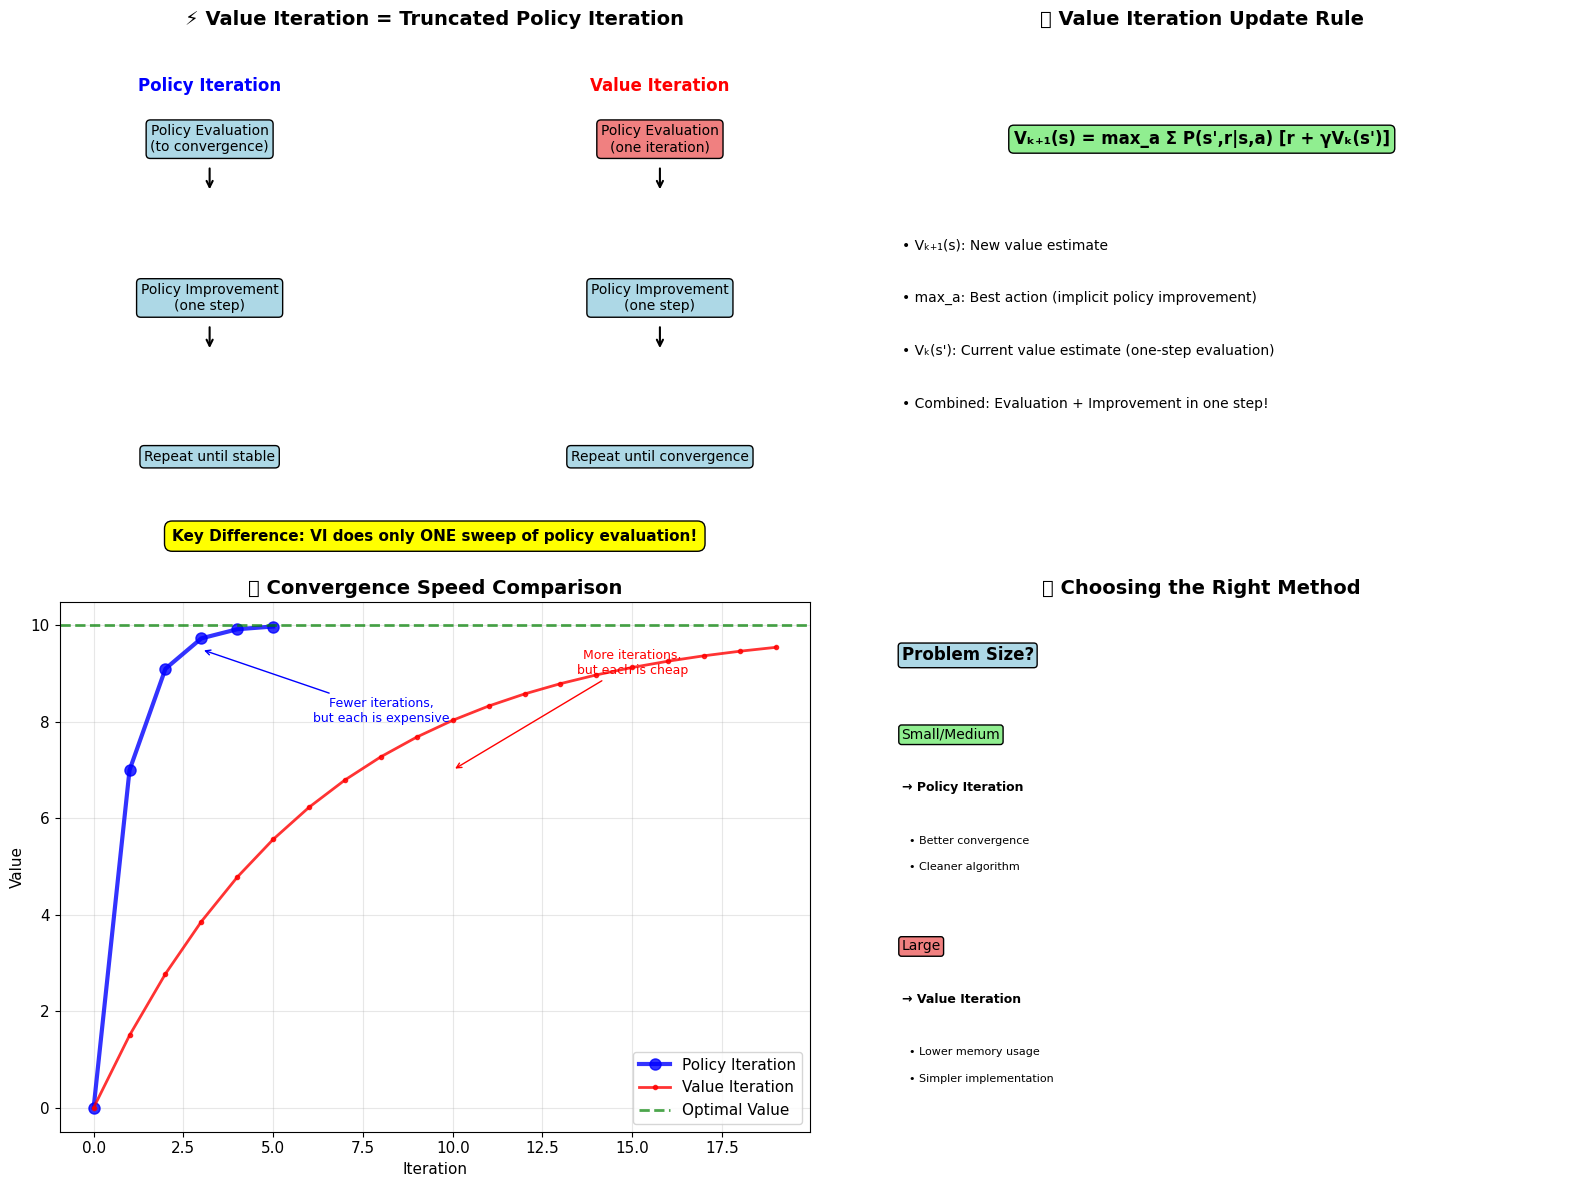


⚡ TESTING ENHANCED VALUE ITERATION
⚡ ENHANCED VALUE ITERATION
   Discount factor: 0.9
   Tolerance: 1e-06
   Max iterations: 50

   Iteration   0: Max change = 10.00000000
   Iteration   1: Max change = 9.00000000
   Iteration   2: Max change = 8.10000000
   Iteration   3: Max change = 7.29000000
   Iteration   4: Max change = 6.56100000
   ✅ Converged after 7 iterations!

📊 VALUE ITERATION RESULTS:
   Converged: ✅ Yes
   Total iterations: 7
   Final start state value: 5.4954

🔍 IMPLICIT POLICY ANALYSIS
   Iteration  1: 2 policy changes
   Iteration  2: 1 policy changes
   Iteration  3: 3 policy changes
   Iteration  4: 2 policy changes
   Iteration  5: 1 policy changes
   Iteration  6: 0 policy changes


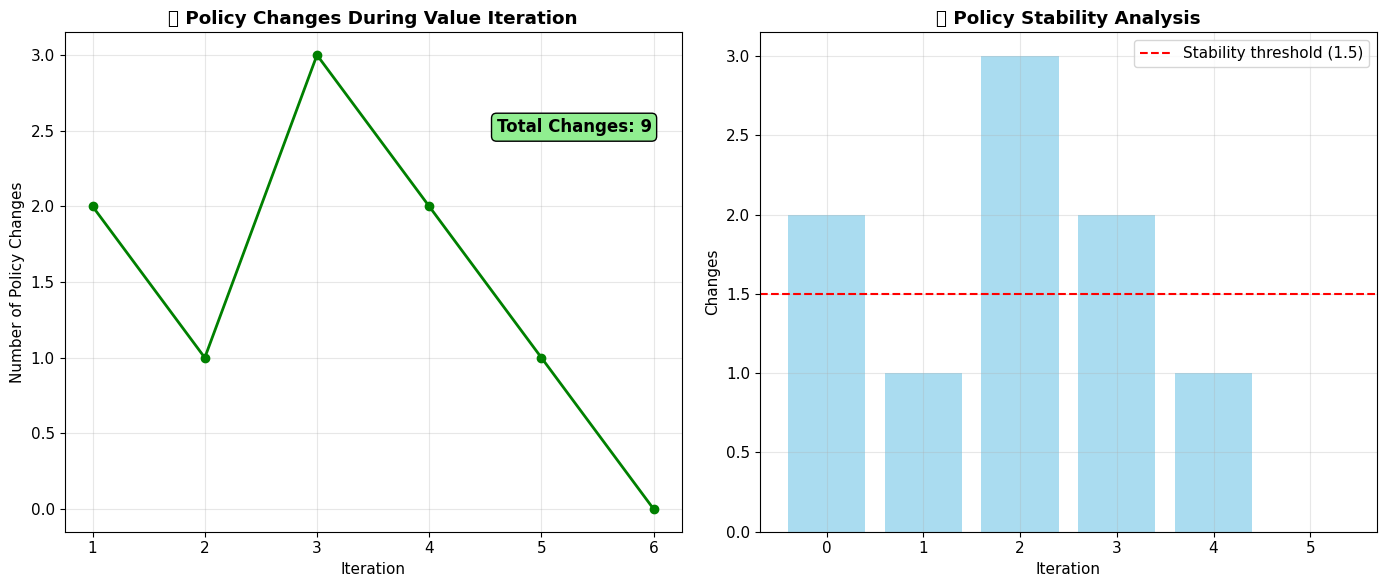

In [15]:
# ================================
# 🎯 Part 4: Value Iteration Revisited
# ================================

print("\n⚡ PART 4: VALUE ITERATION REVISITED")
print("=" * 45)
print("Now that we understand Policy Iteration, let's revisit Value Iteration")
print("with a deeper understanding of how it relates to the full DP framework.")

def create_value_iteration_analysis():
    """Enhanced analysis of Value Iteration in context of DP"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: Value Iteration as Truncated Policy Iteration
    ax1.set_title('⚡ Value Iteration = Truncated Policy Iteration',
                  fontsize=14, fontweight='bold')

    # Show the equivalence
    steps_pi = [
        'Policy Evaluation\n(to convergence)',
        'Policy Improvement\n(one step)',
        'Repeat until stable'
    ]

    steps_vi = [
        'Policy Evaluation\n(one iteration)',
        'Policy Improvement\n(one step)',
        'Repeat until convergence'
    ]

    y_positions = [0.8, 0.5, 0.2]

    # Policy Iteration column
    ax1.text(0.2, 0.9, 'Policy Iteration', ha='center', va='center',
             fontsize=12, fontweight='bold', color='blue')

    for i, (step, y) in enumerate(zip(steps_pi, y_positions)):
        ax1.text(0.2, y, step, ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))

        if i < len(steps_pi) - 1:
            ax1.annotate('', xy=(0.2, y-0.1), xytext=(0.2, y-0.05),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    # Value Iteration column
    ax1.text(0.8, 0.9, 'Value Iteration', ha='center', va='center',
             fontsize=12, fontweight='bold', color='red')

    for i, (step, y) in enumerate(zip(steps_vi, y_positions)):
        color = 'lightcoral' if 'one iteration' in step else 'lightblue'
        ax1.text(0.8, y, step, ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color))

        if i < len(steps_vi) - 1:
            ax1.annotate('', xy=(0.8, y-0.1), xytext=(0.8, y-0.05),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

    # Highlight the difference
    ax1.text(0.5, 0.05, 'Key Difference: VI does only ONE sweep of policy evaluation!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow'))

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # Diagram 2: Value Iteration Update Rule
    ax2.set_title('🧮 Value Iteration Update Rule', fontsize=14, fontweight='bold')

    # Show the Bellman optimality equation
    ax2.text(0.5, 0.8, 'Vₖ₊₁(s) = max_a Σ P(s\',r|s,a) [r + γVₖ(s\')]',
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))

    # Components explanation
    components = [
        'Vₖ₊₁(s): New value estimate',
        'max_a: Best action (implicit policy improvement)',
        'Vₖ(s\'): Current value estimate (one-step evaluation)',
        'Combined: Evaluation + Improvement in one step!'
    ]

    y_pos = 0.6
    for comp in components:
        ax2.text(0.1, y_pos, f'• {comp}', ha='left', va='center', fontsize=10)
        y_pos -= 0.1

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: Convergence Comparison
    ax3.set_title('📊 Convergence Speed Comparison', fontsize=14, fontweight='bold')

    # Simulate convergence curves
    iterations = np.arange(0, 20)

    # Policy Iteration (fewer iterations, but each is more expensive)
    pi_values = 10 * (1 - 0.3**iterations)  # Fast convergence
    pi_iterations = iterations[:6]  # Typically converges in few iterations
    pi_values = pi_values[:6]

    # Value Iteration (more iterations, but each is cheaper)
    vi_values = 10 * (1 - 0.85**iterations)  # Slower convergence

    ax3.plot(pi_iterations, pi_values, 'bo-', linewidth=3, markersize=8,
             label='Policy Iteration', alpha=0.8)
    ax3.plot(iterations, vi_values, 'r.-', linewidth=2, markersize=6,
             label='Value Iteration', alpha=0.8)

    ax3.axhline(y=10, color='green', linestyle='--', linewidth=2,
               label='Optimal Value', alpha=0.7)

    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Add annotations
    ax3.annotate('Fewer iterations,\nbut each is expensive',
                xy=(3, 9.5), xytext=(8, 8),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=9, ha='center', color='blue')

    ax3.annotate('More iterations,\nbut each is cheap',
                xy=(10, 7), xytext=(15, 9),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=9, ha='center', color='red')

    # Diagram 4: When to Use Which Method
    ax4.set_title('🎯 Choosing the Right Method', fontsize=14, fontweight='bold')

    decision_tree = [
        ('Problem Size?', 0.9, 'lightblue', 12),
        ('Small/Medium', 0.75, 'lightgreen', 10),
        ('→ Policy Iteration', 0.65, 'white', 9),
        ('  • Better convergence', 0.55, 'white', 8),
        ('  • Cleaner algorithm', 0.5, 'white', 8),
        ('Large', 0.35, 'lightcoral', 10),
        ('→ Value Iteration', 0.25, 'white', 9),
        ('  • Lower memory usage', 0.15, 'white', 8),
        ('  • Simpler implementation', 0.1, 'white', 8)
    ]

    for text, y, color, fontsize in decision_tree:
        fontweight = 'bold' if '?' in text or '→' in text else 'normal'
        ax4.text(0.1, y, text, ha='left', va='center',
                fontsize=fontsize, fontweight=fontweight,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color) if color != 'white' else None)

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

value_iteration_analysis_fig = create_value_iteration_analysis()
plt.show()

# Enhanced Value Iteration Implementation
class EnhancedValueIteration:
    """Enhanced Value Iteration with detailed comparison to Policy Iteration"""

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def value_iteration_detailed(self, max_iterations=100, tolerance=1e-6,
                               track_policies=True, verbose=True):
        """
        Value Iteration with detailed policy tracking to show relationship to PI
        """

        if verbose:
            print("⚡ ENHANCED VALUE ITERATION")
            print("=" * 35)
            print(f"   Discount factor: {self.gamma}")
            print(f"   Tolerance: {tolerance}")
            print(f"   Max iterations: {max_iterations}")
            print()

        # Initialize
        V = {state: 0.0 for state in self.states}

        # Tracking
        convergence_data = []
        policy_history = []
        value_history = []

        for iteration in range(max_iterations):
            V_new = V.copy()
            max_change = 0

            # Extract current implicit policy (for tracking)
            if track_policies:
                current_policy = {}
                for state in self.states:
                    if state in self.env.terminals:
                        current_policy[state] = None
                        continue

                    actions = self.env.get_possible_actions(state)
                    if not actions:
                        current_policy[state] = None
                        continue

                    # Find greedy action
                    best_action = None
                    best_value = float('-inf')

                    for action in actions:
                        next_state = self.env.get_next_state(state, action)
                        reward = self.env.get_reward(next_state)
                        value = reward + self.gamma * V[next_state]

                        if value > best_value:
                            best_value = value
                            best_action = action

                    current_policy[state] = best_action

                policy_history.append(current_policy.copy())

            # Value iteration update
            for state in self.states:
                if state in self.env.terminals:
                    V_new[state] = 0.0
                    continue

                actions = self.env.get_possible_actions(state)
                if not actions:
                    continue

                # Bellman optimality backup
                action_values = []
                for action in actions:
                    next_state = self.env.get_next_state(state, action)
                    reward = self.env.get_reward(next_state)
                    value = reward + self.gamma * V[next_state]
                    action_values.append(value)

                V_new[state] = max(action_values)
                change = abs(V_new[state] - V[state])
                max_change = max(max_change, change)

            V = V_new
            convergence_data.append(max_change)

            if iteration % 5 == 0:
                value_history.append(V.copy())

            # Progress reporting
            if verbose and (iteration % 10 == 0 or iteration < 5):
                print(f"   Iteration {iteration:3d}: Max change = {max_change:.8f}")

            # Check convergence
            if max_change < tolerance:
                if verbose:
                    print(f"   ✅ Converged after {iteration + 1} iterations!")
                break

        # Extract final policy
        final_policy = {}
        for state in self.states:
            if state in self.env.terminals:
                final_policy[state] = None
                continue

            actions = self.env.get_possible_actions(state)
            if not actions:
                final_policy[state] = None
                continue

            best_action = None
            best_value = float('-inf')

            for action in actions:
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                value = reward + self.gamma * V[next_state]

                if value > best_value:
                    best_value = value
                    best_action = action

            final_policy[state] = best_action

        return {
            'values': V,
            'policy': final_policy,
            'iterations': iteration + 1,
            'converged': max_change < tolerance,
            'convergence_data': convergence_data,
            'policy_history': policy_history,
            'value_history': value_history
        }

    def analyze_implicit_policies(self, results):
        """Analyze how the implicit policy changes during Value Iteration"""

        policy_history = results.get('policy_history', [])
        if not policy_history:
            print("No policy history available for analysis")
            return

        print("\n🔍 IMPLICIT POLICY ANALYSIS")
        print("=" * 35)

        # Count policy changes between iterations
        policy_changes = []
        for i in range(1, len(policy_history)):
            changes = 0
            prev_policy = policy_history[i-1]
            curr_policy = policy_history[i]

            for state in self.states:
                if state in self.env.terminals:
                    continue

                if prev_policy.get(state) != curr_policy.get(state):
                    changes += 1

            policy_changes.append(changes)
            print(f"   Iteration {i:2d}: {changes} policy changes")

        # Visualize policy evolution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Policy changes over iterations
        ax1.plot(range(1, len(policy_changes)+1), policy_changes,
                'go-', linewidth=2, markersize=6)
        ax1.set_title('🔄 Policy Changes During Value Iteration', fontweight='bold')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Number of Policy Changes')
        ax1.grid(True, alpha=0.3)

        # Add total changes annotation
        total_changes = sum(policy_changes)
        ax1.text(0.7, 0.8, f'Total Changes: {total_changes}',
                transform=ax1.transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))

        # Plot 2: Policy stability visualization
        ax2.bar(range(len(policy_changes)), policy_changes, alpha=0.7, color='skyblue')
        ax2.set_title('📊 Policy Stability Analysis', fontweight='bold')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Changes')

        # Add stability threshold
        stability_threshold = 0.1 * len(self.states)
        ax2.axhline(y=stability_threshold, color='red', linestyle='--',
                   label=f'Stability threshold ({stability_threshold:.1f})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return policy_changes

# Test Enhanced Value Iteration
print("\n⚡ TESTING ENHANCED VALUE ITERATION")
print("=" * 40)

enhanced_vi = EnhancedValueIteration(env, gamma=0.9)
vi_results = enhanced_vi.value_iteration_detailed(max_iterations=50, verbose=True)

print(f"\n📊 VALUE ITERATION RESULTS:")
print(f"   Converged: {'✅ Yes' if vi_results['converged'] else '❌ No'}")
print(f"   Total iterations: {vi_results['iterations']}")
print(f"   Final start state value: {vi_results['values'][(0,0)]:.4f}")

# Analyze implicit policy changes
policy_changes = enhanced_vi.analyze_implicit_policies(vi_results)


🚀 PART 5: ASYNCHRONOUS DYNAMIC PROGRAMMING
So far we've done synchronous updates (all states together).
Asynchronous DP updates states in flexible orders for better efficiency!


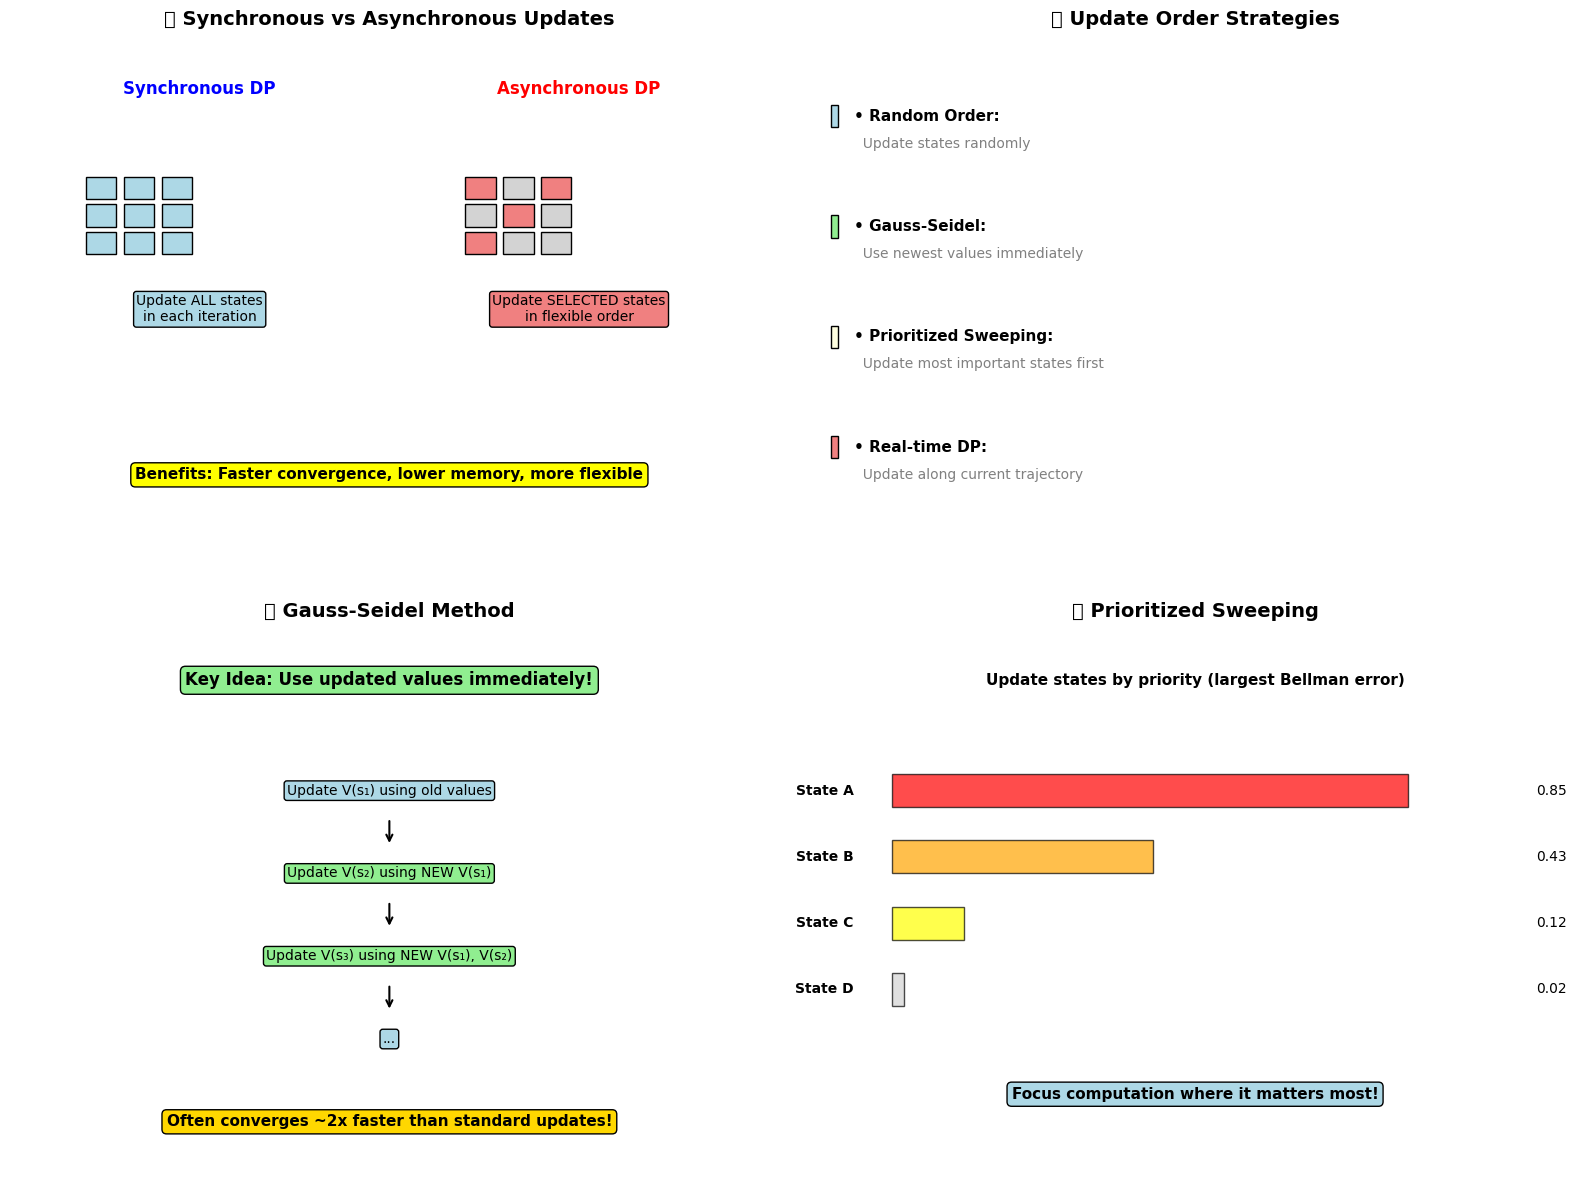

🧪 TESTING ASYNCHRONOUS DP METHODS
⚔️ ASYNCHRONOUS DP METHODS COMPARISON
📊 Running Synchronous Value Iteration (baseline)...
🔧 Running Gauss-Seidel Value Iteration...
🎯 Running Prioritized Sweeping...
🎮 Running Real-time DP...

📊 COMPARISON RESULTS:
Method               Iterations   Converged    Start Value 
------------------------------------------------------------
Synchronous VI       7            ✅ Yes        5.4954      
Gauss-Seidel VI      7            ✅ Yes        5.4954      
Prioritized Sweeping 3            ✅ Yes        5.4954      
Real-time DP         N/A          Online       5.4954      
   (Used 429 total updates across 500 steps)


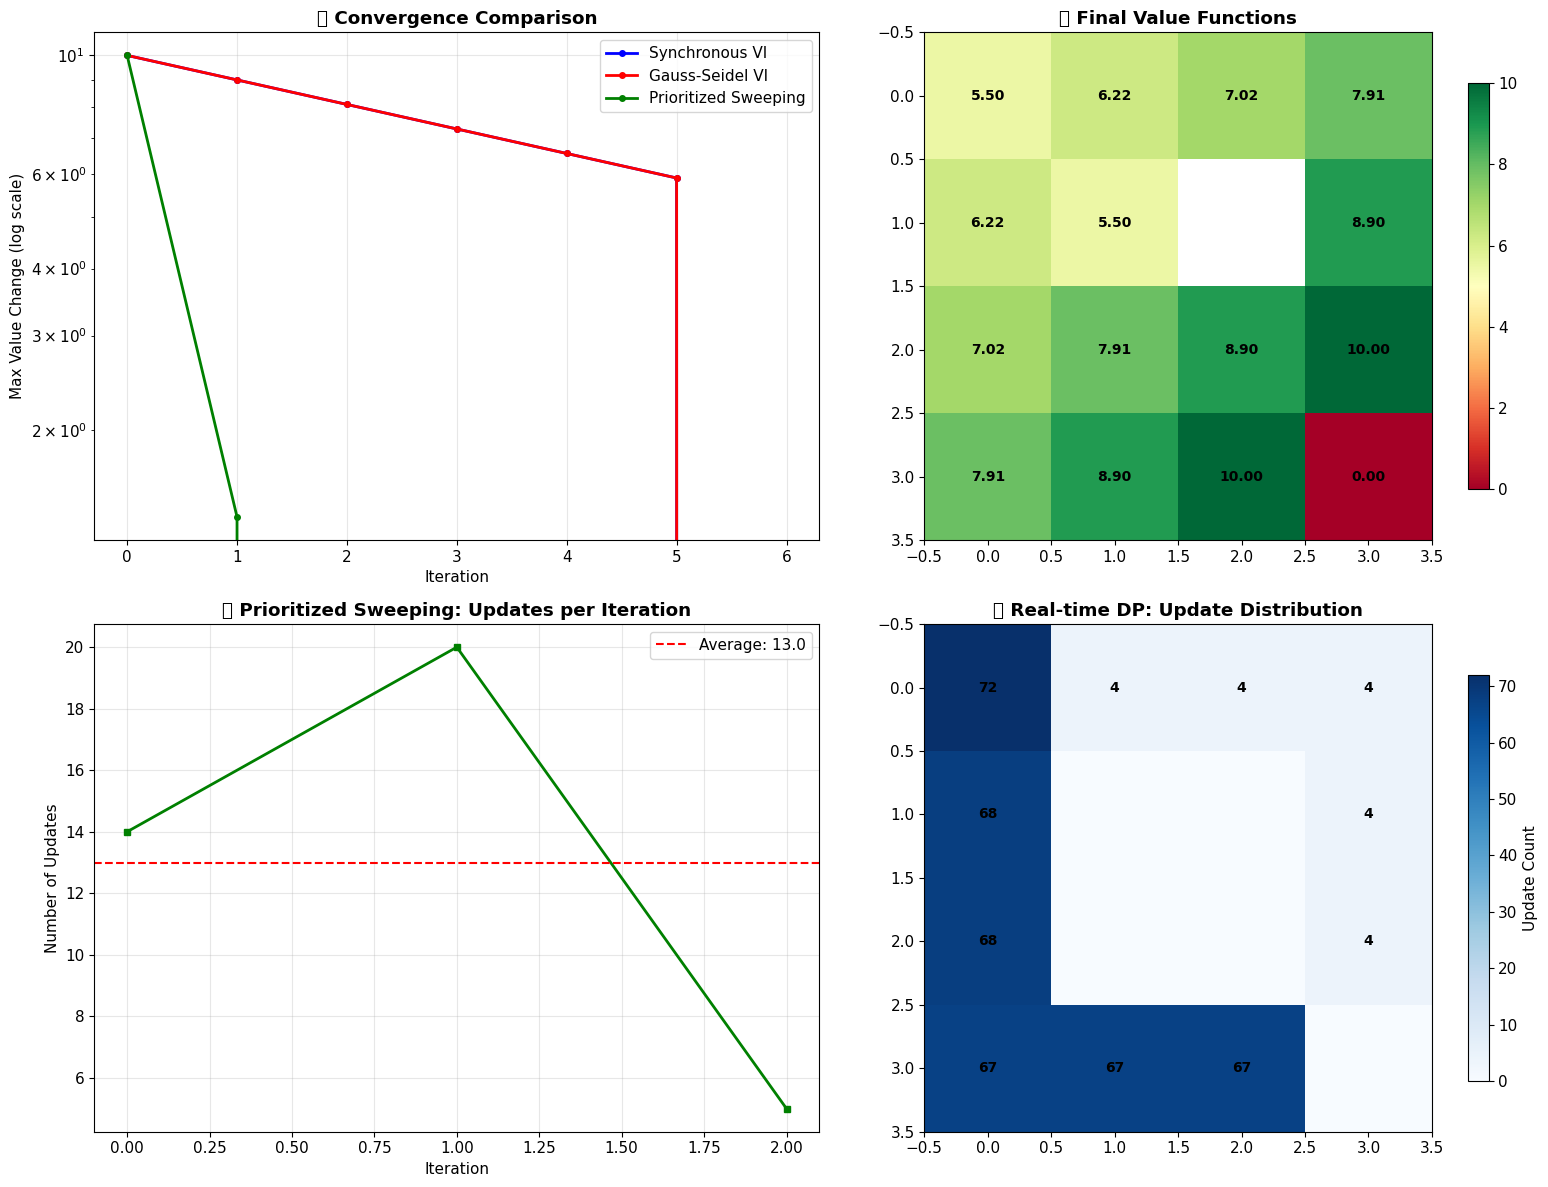

In [16]:
# ================================
# 🎯 Part 5: Asynchronous Dynamic Programming
# ================================

print("\n🚀 PART 5: ASYNCHRONOUS DYNAMIC PROGRAMMING")
print("=" * 55)
print("So far we've done synchronous updates (all states together).")
print("Asynchronous DP updates states in flexible orders for better efficiency!")

def create_async_dp_theory():
    """Visual explanation of Asynchronous Dynamic Programming"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: Synchronous vs Asynchronous Updates
    ax1.set_title('🔄 Synchronous vs Asynchronous Updates', fontsize=14, fontweight='bold')

    # Synchronous updates visualization
    ax1.text(0.25, 0.9, 'Synchronous DP', ha='center', va='center',
             fontsize=12, fontweight='bold', color='blue')

    # Grid representing states
    for i in range(3):
        for j in range(3):
            rect = Rectangle((0.1 + j*0.05, 0.7 - i*0.05), 0.04, 0.04,
                           facecolor='lightblue', edgecolor='black')
            ax1.add_patch(rect)

    ax1.text(0.25, 0.5, 'Update ALL states\nin each iteration',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue'))

    # Asynchronous updates visualization
    ax1.text(0.75, 0.9, 'Asynchronous DP', ha='center', va='center',
             fontsize=12, fontweight='bold', color='red')

    # Grid with selective updates
    colors = ['lightcoral', 'lightgray', 'lightcoral', 'lightgray', 'lightcoral',
              'lightgray', 'lightcoral', 'lightgray', 'lightgray']

    for i in range(3):
        for j in range(3):
            color = colors[i*3 + j]
            rect = Rectangle((0.6 + j*0.05, 0.7 - i*0.05), 0.04, 0.04,
                           facecolor=color, edgecolor='black')
            ax1.add_patch(rect)

    ax1.text(0.75, 0.5, 'Update SELECTED states\nin flexible order',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='lightcoral'))

    ax1.text(0.5, 0.2, 'Benefits: Faster convergence, lower memory, more flexible',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow'))

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # Diagram 2: Different Update Orders
    ax2.set_title('📋 Update Order Strategies', fontsize=14, fontweight='bold')

    strategies = [
        ('Random Order', 'Update states randomly', 'lightblue'),
        ('Gauss-Seidel', 'Use newest values immediately', 'lightgreen'),
        ('Prioritized Sweeping', 'Update most important states first', 'lightyellow'),
        ('Real-time DP', 'Update along current trajectory', 'lightcoral')
    ]

    y_pos = 0.85
    for strategy, description, color in strategies:
        ax2.text(0.05, y_pos, f'• {strategy}:', ha='left', va='center',
                fontsize=11, fontweight='bold')
        ax2.text(0.05, y_pos - 0.05, f'  {description}', ha='left', va='center',
                fontsize=10, color='gray')

        # Add colored indicator
        rect = Rectangle((0.02, y_pos - 0.02), 0.01, 0.04, facecolor=color,
                        edgecolor='black')
        ax2.add_patch(rect)

        y_pos -= 0.2

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: Gauss-Seidel Method
    ax3.set_title('🔧 Gauss-Seidel Method', fontsize=14, fontweight='bold')

    # Show how new values are used immediately
    ax3.text(0.5, 0.9, 'Key Idea: Use updated values immediately!',
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))

    # Timeline
    steps = [
        'Update V(s₁) using old values',
        'Update V(s₂) using NEW V(s₁)',
        'Update V(s₃) using NEW V(s₁), V(s₂)',
        '...'
    ]

    y_pos = 0.7
    for i, step in enumerate(steps):
        color = 'lightgreen' if 'NEW' in step else 'lightblue'
        ax3.text(0.5, y_pos, step, ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=color))

        if i < len(steps) - 1 and step != '...':
            ax3.annotate('', xy=(0.5, y_pos - 0.1), xytext=(0.5, y_pos - 0.05),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

        y_pos -= 0.15

    ax3.text(0.5, 0.1, 'Often converges ~2x faster than standard updates!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='gold'))

    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

    # Diagram 4: Prioritized Sweeping
    ax4.set_title('🎯 Prioritized Sweeping', fontsize=14, fontweight='bold')

    # Priority queue concept
    ax4.text(0.5, 0.9, 'Update states by priority (largest Bellman error)',
             ha='center', va='center', fontsize=11, fontweight='bold')

    # Priority queue visualization
    priorities = [
        ('State A', 0.85, 'High Priority'),
        ('State B', 0.43, 'Medium Priority'),
        ('State C', 0.12, 'Low Priority'),
        ('State D', 0.02, 'Very Low Priority')
    ]

    y_pos = 0.7
    for state, priority, level in priorities:
        width = priority * 0.8
        color = 'red' if priority > 0.7 else 'orange' if priority > 0.4 else 'yellow' if priority > 0.1 else 'lightgray'

        # Priority bar
        rect = Rectangle((0.1, y_pos - 0.03), width, 0.06, facecolor=color,
                        edgecolor='black', alpha=0.7)
        ax4.add_patch(rect)

        # Labels
        ax4.text(0.05, y_pos, state, ha='right', va='center', fontsize=10, fontweight='bold')
        ax4.text(0.95, y_pos, f'{priority:.2f}', ha='left', va='center', fontsize=10)

        y_pos -= 0.12

    ax4.text(0.5, 0.15, 'Focus computation where it matters most!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

async_theory_fig = create_async_dp_theory()
plt.show()

class AsynchronousDPSolver:
    """
    Implementation of various Asynchronous Dynamic Programming methods
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def gauss_seidel_value_iteration(self, max_iterations=100, tolerance=1e-6, verbose=True):
        """
        Gauss-Seidel Value Iteration: Use updated values immediately
        """

        if verbose:
            print("🔧 GAUSS-SEIDEL VALUE ITERATION")
            print("=" * 40)

        # Initialize
        V = {state: 0.0 for state in self.states}
        convergence_data = []

        for iteration in range(max_iterations):
            max_change = 0

            # Update states in order, using new values immediately
            for state in self.states:
                if state in self.env.terminals:
                    continue

                old_value = V[state]
                actions = self.env.get_possible_actions(state)

                if actions:
                    # Bellman backup using current (possibly updated) values
                    action_values = []
                    for action in actions:
                        next_state = self.env.get_next_state(state, action)
                        reward = self.env.get_reward(next_state)
                        value = reward + self.gamma * V[next_state]  # Using current V!
                        action_values.append(value)

                    V[state] = max(action_values)
                    change = abs(V[state] - old_value)
                    max_change = max(max_change, change)

            convergence_data.append(max_change)

            if verbose and (iteration % 10 == 0 or iteration < 5):
                print(f"   Iteration {iteration:3d}: Max change = {max_change:.8f}")

            if max_change < tolerance:
                if verbose:
                    print(f"   ✅ Converged after {iteration + 1} iterations!")
                break

        return {
            'values': V,
            'iterations': iteration + 1,
            'converged': max_change < tolerance,
            'convergence_data': convergence_data
        }

    def prioritized_sweeping(self, max_iterations=100, tolerance=1e-6,
                           priority_threshold=1e-4, verbose=True):
        """
        Prioritized Sweeping: Update states with highest Bellman error first
        """

        if verbose:
            print("🎯 PRIORITIZED SWEEPING")
            print("=" * 30)

        # Initialize
        V = {state: 0.0 for state in self.states}

        # Priority queue (using list for simplicity)
        priority_queue = []

        # Initialize priorities
        for state in self.states:
            if state not in self.env.terminals:
                priority = self._compute_bellman_error(state, V)
                if priority > priority_threshold:
                    priority_queue.append((priority, state))

        convergence_data = []
        updates_per_iteration = []

        for iteration in range(max_iterations):
            iteration_updates = 0
            max_change = 0

            # Sort by priority (highest first)
            priority_queue.sort(reverse=True)

            # Update high-priority states
            new_queue = []
            for priority, state in priority_queue:
                if priority < priority_threshold:
                    break

                old_value = V[state]

                # Bellman backup
                actions = self.env.get_possible_actions(state)
                if actions:
                    action_values = []
                    for action in actions:
                        next_state = self.env.get_next_state(state, action)
                        reward = self.env.get_reward(next_state)
                        value = reward + self.gamma * V[next_state]
                        action_values.append(value)

                    V[state] = max(action_values)
                    change = abs(V[state] - old_value)
                    max_change = max(max_change, change)
                    iteration_updates += 1

                    # Update priorities of predecessors
                    self._update_predecessor_priorities(state, V, new_queue, priority_threshold)

            # Update priority queue
            priority_queue = new_queue

            convergence_data.append(max_change)
            updates_per_iteration.append(iteration_updates)

            if verbose and (iteration % 10 == 0 or iteration < 5):
                print(f"   Iteration {iteration:3d}: {iteration_updates:2d} updates, "
                      f"Max change = {max_change:.8f}")

            if max_change < tolerance:
                if verbose:
                    print(f"   ✅ Converged after {iteration + 1} iterations!")
                break

        return {
            'values': V,
            'iterations': iteration + 1,
            'converged': max_change < tolerance,
            'convergence_data': convergence_data,
            'updates_per_iteration': updates_per_iteration
        }

    def _compute_bellman_error(self, state, V):
        """Compute Bellman error for prioritization"""
        if state in self.env.terminals:
            return 0.0

        current_value = V[state]
        actions = self.env.get_possible_actions(state)

        if not actions:
            return 0.0

        # Compute optimal value
        action_values = []
        for action in actions:
            next_state = self.env.get_next_state(state, action)
            reward = self.env.get_reward(next_state)
            value = reward + self.gamma * V[next_state]
            action_values.append(value)

        optimal_value = max(action_values)
        return abs(optimal_value - current_value)

    def _update_predecessor_priorities(self, updated_state, V, priority_queue, threshold):
        """Update priorities of states that can reach the updated state"""

        # Find all states that can reach updated_state
        for state in self.states:
            if state in self.env.terminals:
                continue

            actions = self.env.get_possible_actions(state)
            for action in actions:
                next_state = self.env.get_next_state(state, action)
                if next_state == updated_state:
                    # This state can reach the updated state
                    priority = self._compute_bellman_error(state, V)
                    if priority > threshold:
                        priority_queue.append((priority, state))
                    break

    def real_time_dp(self, start_state, max_steps=1000, tolerance=1e-6, verbose=True):
        """
        Real-time DP: Update only states along the current trajectory
        """

        if verbose:
            print("🎮 REAL-TIME DYNAMIC PROGRAMMING")
            print("=" * 40)

        # Initialize
        V = {state: 0.0 for state in self.states}

        # Simulation
        current_state = start_state
        trajectory = [current_state]
        updates_count = {state: 0 for state in self.states}

        for step in range(max_steps):
            if current_state in self.env.terminals:
                # Reset to start for continued learning
                current_state = start_state
                trajectory.append(current_state)
                continue

            # Update current state value
            old_value = V[current_state]
            actions = self.env.get_possible_actions(current_state)

            if actions:
                # Bellman backup
                action_values = []
                best_action = None
                best_value = float('-inf')

                for action in actions:
                    next_state = self.env.get_next_state(current_state, action)
                    reward = self.env.get_reward(next_state)
                    value = reward + self.gamma * V[next_state]
                    action_values.append(value)

                    if value > best_value:
                        best_value = value
                        best_action = action

                V[current_state] = max(action_values)
                updates_count[current_state] += 1

                # Take best action
                if best_action:
                    current_state = self.env.get_next_state(current_state, best_action)
                    trajectory.append(current_state)

            if step % 100 == 0 and verbose:
                total_updates = sum(updates_count.values())
                print(f"   Step {step:4d}: {total_updates} total updates, "
                      f"current state {current_state}")

        return {
            'values': V,
            'trajectory': trajectory,
            'updates_count': updates_count,
            'steps': step + 1
        }

    def compare_async_methods(self, max_iterations=50):
        """Compare different asynchronous DP methods"""

        print("⚔️ ASYNCHRONOUS DP METHODS COMPARISON")
        print("=" * 50)

        # Standard synchronous VI for baseline
        print("📊 Running Synchronous Value Iteration (baseline)...")
        sync_vi = EnhancedValueIteration(self.env, self.gamma)
        sync_results = sync_vi.value_iteration_detailed(max_iterations=max_iterations, verbose=False)

        # Gauss-Seidel VI
        print("🔧 Running Gauss-Seidel Value Iteration...")
        gs_results = self.gauss_seidel_value_iteration(max_iterations=max_iterations, verbose=False)

        # Prioritized Sweeping
        print("🎯 Running Prioritized Sweeping...")
        ps_results = self.prioritized_sweeping(max_iterations=max_iterations, verbose=False)

        # Real-time DP
        print("🎮 Running Real-time DP...")
        rt_results = self.real_time_dp(start_state=(0, 0), max_steps=500, verbose=False)

        # Compare results
        methods = {
            'Synchronous VI': sync_results,
            'Gauss-Seidel VI': gs_results,
            'Prioritized Sweeping': ps_results
        }

        print(f"\n📊 COMPARISON RESULTS:")
        print(f"{'Method':<20} {'Iterations':<12} {'Converged':<12} {'Start Value':<12}")
        print("-" * 60)

        for name, results in methods.items():
            converged = "✅ Yes" if results.get('converged', False) else "❌ No"
            start_value = results['values'][(0, 0)]
            iterations = results.get('iterations', 'N/A')

            print(f"{name:<20} {iterations:<12} {converged:<12} {start_value:<12.4f}")

        # Real-time DP separate (different metric)
        rt_start_value = rt_results['values'][(0, 0)]
        rt_updates = sum(rt_results['updates_count'].values())
        print(f"{'Real-time DP':<20} {'N/A':<12} {'Online':<12} {rt_start_value:<12.4f}")
        print(f"   (Used {rt_updates} total updates across {rt_results['steps']} steps)")

        # Visualize convergence
        self._visualize_async_comparison(methods, rt_results)

        return methods, rt_results

    def _visualize_async_comparison(self, methods, rt_results):
        """Visualize comparison of async methods"""

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Convergence curves
        ax1.set_title('📉 Convergence Comparison', fontweight='bold')

        colors = ['blue', 'red', 'green', 'orange']
        for i, (name, results) in enumerate(methods.items()):
            convergence_data = results.get('convergence_data', [])
            if convergence_data:
                ax1.semilogy(convergence_data, color=colors[i], linewidth=2,
                           marker='o', markersize=4, label=name)

        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Max Value Change (log scale)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Final value functions comparison
        ax2.set_title('💎 Final Value Functions', fontweight='bold')

        # Use Gauss-Seidel as example
        if 'Gauss-Seidel VI' in methods:
            values = methods['Gauss-Seidel VI']['values']
            value_grid = np.full((self.env.height, self.env.width), np.nan)

            for (r, c), value in values.items():
                value_grid[r, c] = value

            im2 = ax2.imshow(value_grid, cmap='RdYlGn', interpolation='nearest')

            # Add value text
            for row in range(self.env.height):
                for col in range(self.env.width):
                    if (row, col) in values:
                        value = values[(row, col)]
                        color = 'white' if value < 0 else 'black'
                        ax2.text(col, row, f'{value:.2f}', ha='center', va='center',
                               fontweight='bold', color=color, fontsize=10)

            plt.colorbar(im2, ax=ax2, shrink=0.8)

        # Plot 3: Updates per iteration (for prioritized sweeping)
        ax3.set_title('📊 Updates per Iteration', fontweight='bold')

        if 'Prioritized Sweeping' in methods:
            ps_results = methods['Prioritized Sweeping']
            updates_per_iter = ps_results.get('updates_per_iteration', [])

            if updates_per_iter:
                ax3.plot(updates_per_iter, 'g-', linewidth=2, marker='s', markersize=4)
                ax3.set_xlabel('Iteration')
                ax3.set_ylabel('Number of Updates')
                ax3.set_title('🎯 Prioritized Sweeping: Updates per Iteration', fontweight='bold')
                ax3.grid(True, alpha=0.3)

                # Add average line
                avg_updates = np.mean(updates_per_iter)
                ax3.axhline(y=avg_updates, color='red', linestyle='--',
                           label=f'Average: {avg_updates:.1f}')
                ax3.legend()

        # Plot 4: Real-time DP update distribution
        ax4.set_title('🎮 Real-time DP: Update Distribution', fontweight='bold')

        updates_count = rt_results.get('updates_count', {})
        if updates_count:
            # Create heatmap of updates
            update_grid = np.zeros((self.env.height, self.env.width))

            for (row, col), count in updates_count.items():
                update_grid[row, col] = count

            im4 = ax4.imshow(update_grid, cmap='Blues', interpolation='nearest')

            # Add count text
            for row in range(self.env.height):
                for col in range(self.env.width):
                    count = updates_count.get((row, col), 0)
                    if count > 0:
                        ax4.text(col, row, str(count), ha='center', va='center',
                               fontweight='bold', fontsize=10)

            plt.colorbar(im4, ax=ax4, shrink=0.8, label='Update Count')

        plt.tight_layout()
        plt.show()

# Test Asynchronous DP methods
print("🧪 TESTING ASYNCHRONOUS DP METHODS")
print("=" * 40)

async_solver = AsynchronousDPSolver(env, gamma=0.9)
comparison_results, rt_results = async_solver.compare_async_methods(max_iterations=30)


🌟 PART 6: GENERALIZED POLICY ITERATION FRAMEWORK
The unifying theory that connects ALL dynamic programming methods!


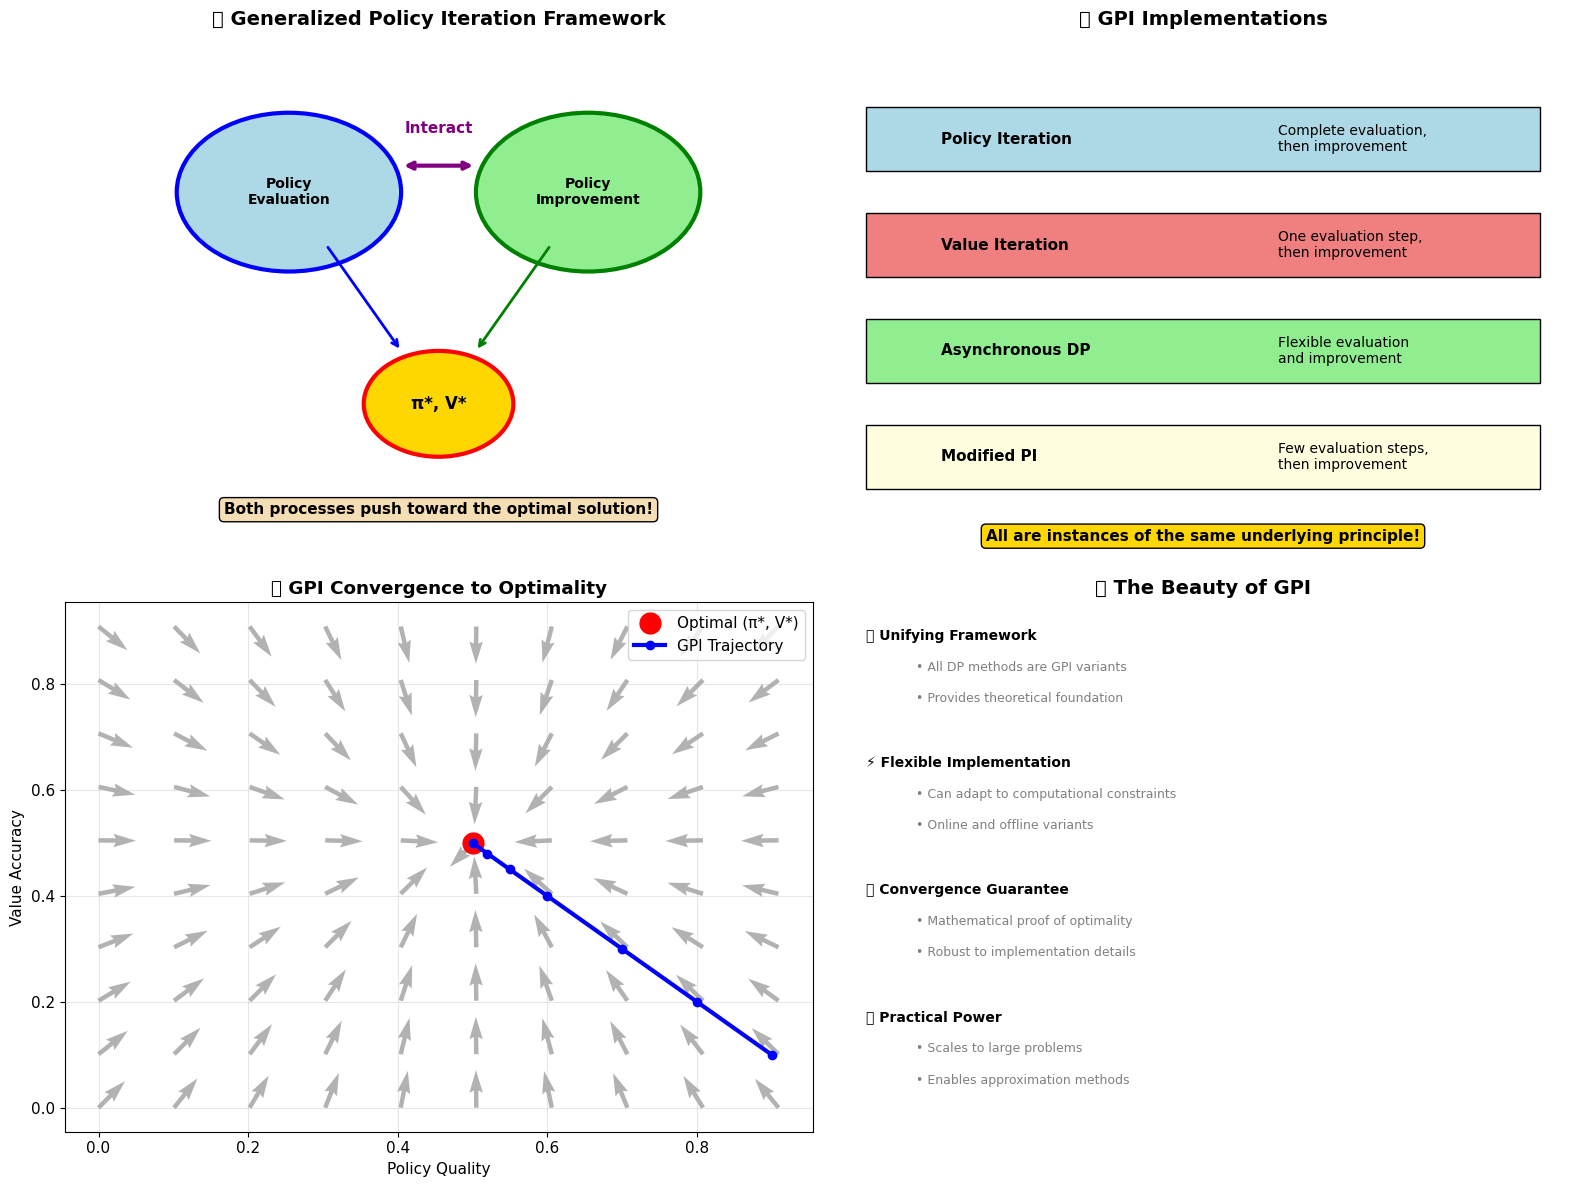

🌟 DEMONSTRATING GENERALIZED POLICY ITERATION
🌟 DEMONSTRATING GPI CONVERGENCE

🔄 GPI ITERATION 1
-------------------------
📊 Policy Evaluation Phase:
   Average state value: -6.5996
📈 Policy Improvement Phase:
   States improved: 8

🔄 GPI ITERATION 2
-------------------------
📊 Policy Evaluation Phase:
   Average state value: 3.6987
📈 Policy Improvement Phase:
   States improved: 3

🔄 GPI ITERATION 3
-------------------------
📊 Policy Evaluation Phase:
   Average state value: 5.7684
📈 Policy Improvement Phase:
   States improved: 3

🔄 GPI ITERATION 4
-------------------------
📊 Policy Evaluation Phase:
   Average state value: 6.7748
📈 Policy Improvement Phase:
   States improved: 1

🔄 GPI ITERATION 5
-------------------------
📊 Policy Evaluation Phase:
   Average state value: 7.1929
📈 Policy Improvement Phase:
   States improved: 0
✅ Policy stable - optimal solution found!


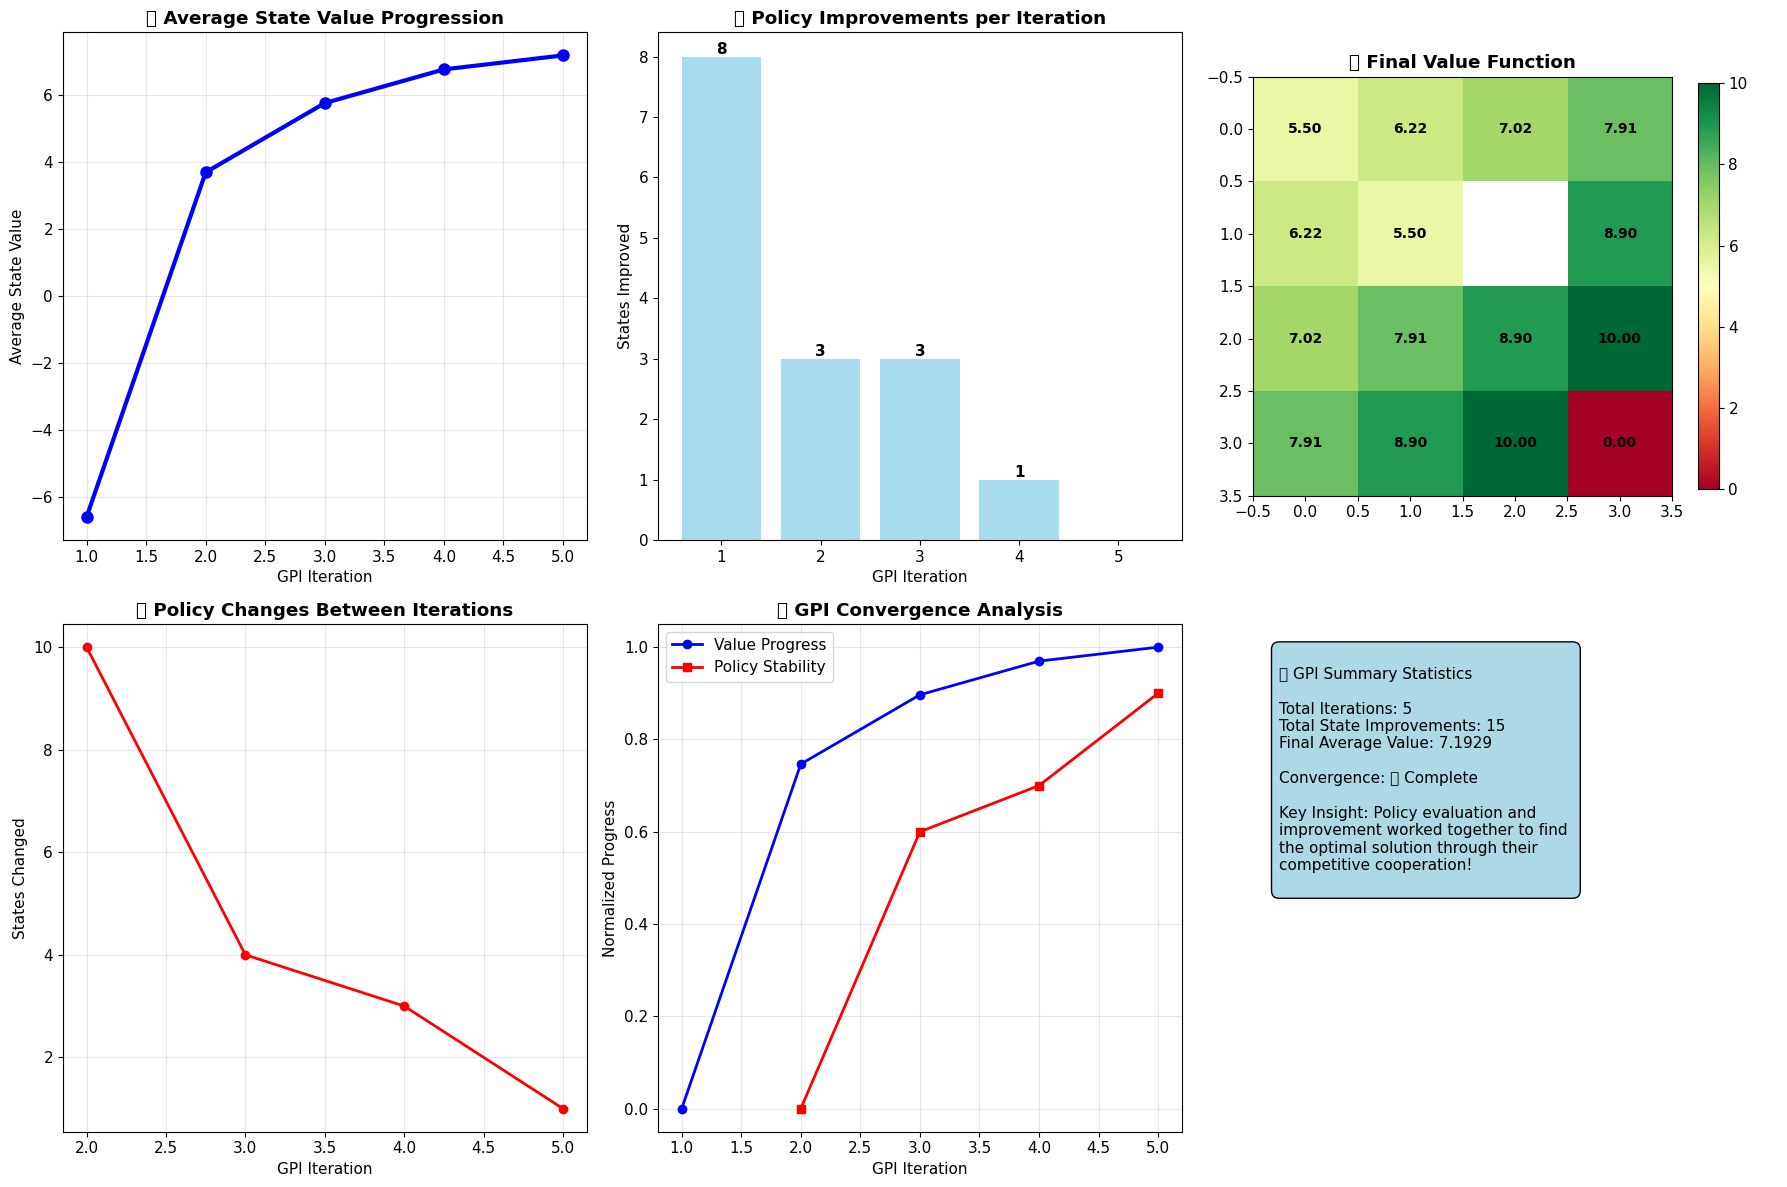

In [17]:
# ================================
# 🎯 Part 6: Generalized Policy Iteration Framework
# ================================

print("\n🌟 PART 6: GENERALIZED POLICY ITERATION FRAMEWORK")
print("=" * 60)
print("The unifying theory that connects ALL dynamic programming methods!")

def create_gpi_theory():
    """Visual explanation of Generalized Policy Iteration"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: The GPI Framework
    ax1.set_title('🌟 Generalized Policy Iteration Framework', fontsize=14, fontweight='bold')

    # Two competing processes
    evaluation_circle = Circle((0.3, 0.7), 0.15, facecolor='lightblue',
                              edgecolor='blue', linewidth=3)
    ax1.add_patch(evaluation_circle)
    ax1.text(0.3, 0.7, 'Policy\nEvaluation', ha='center', va='center',
             fontweight='bold', fontsize=10)

    improvement_circle = Circle((0.7, 0.7), 0.15, facecolor='lightgreen',
                               edgecolor='green', linewidth=3)
    ax1.add_patch(improvement_circle)
    ax1.text(0.7, 0.7, 'Policy\nImprovement', ha='center', va='center',
             fontweight='bold', fontsize=10)

    # Interaction arrows
    ax1.annotate('', xy=(0.55, 0.75), xytext=(0.45, 0.75),
                arrowprops=dict(arrowstyle='<->', lw=3, color='purple'))
    ax1.text(0.5, 0.82, 'Interact', ha='center', va='center',
             fontweight='bold', color='purple')

    # Convergence point
    optimal_circle = Circle((0.5, 0.3), 0.1, facecolor='gold',
                           edgecolor='red', linewidth=3)
    ax1.add_patch(optimal_circle)
    ax1.text(0.5, 0.3, 'π*, V*', ha='center', va='center',
             fontweight='bold', fontsize=12)

    # Arrows to optimum
    ax1.annotate('', xy=(0.45, 0.4), xytext=(0.35, 0.6),
                arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
    ax1.annotate('', xy=(0.55, 0.4), xytext=(0.65, 0.6),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))

    ax1.text(0.5, 0.1, 'Both processes push toward the optimal solution!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat'))

    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')

    # Diagram 2: Different GPI Implementations
    ax2.set_title('🔧 GPI Implementations', fontsize=14, fontweight='bold')

    implementations = [
        ('Policy Iteration', 'Complete evaluation,\nthen improvement', 'lightblue'),
        ('Value Iteration', 'One evaluation step,\nthen improvement', 'lightcoral'),
        ('Asynchronous DP', 'Flexible evaluation\nand improvement', 'lightgreen'),
        ('Modified PI', 'Few evaluation steps,\nthen improvement', 'lightyellow')
    ]

    y_positions = [0.8, 0.6, 0.4, 0.2]

    for (name, description, color), y in zip(implementations, y_positions):
        # Method box
        rect = Rectangle((0.05, y-0.06), 0.9, 0.12, facecolor=color,
                        edgecolor='black', linewidth=1)
        ax2.add_patch(rect)

        ax2.text(0.15, y, name, ha='left', va='center', fontsize=11, fontweight='bold')
        ax2.text(0.6, y, description, ha='left', va='center', fontsize=10)

    ax2.text(0.5, 0.05, 'All are instances of the same underlying principle!',
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='gold'))

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

    # Diagram 3: GPI Convergence Guarantee
    ax3.set_title('✅ GPI Convergence Guarantee', fontsize=14, fontweight='bold')

    # Phase diagram style visualization
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Vector field pointing toward optimum
    U = 0.5 - X  # Point toward center
    V = 0.5 - Y

    # Normalize
    M = np.sqrt(U**2 + V**2)
    M[M == 0] = 1
    U = U / M
    V = V / M

    # Plot vector field
    ax3.quiver(X[::10, ::10], Y[::10, ::10], U[::10, ::10], V[::10, ::10],
               alpha=0.6, scale=20, color='gray')

    # Optimal point
    ax3.plot(0.5, 0.5, 'ro', markersize=15, label='Optimal (π*, V*)')

    # Sample trajectory
    trajectory_x = [0.9, 0.8, 0.7, 0.6, 0.55, 0.52, 0.5]
    trajectory_y = [0.1, 0.2, 0.3, 0.4, 0.45, 0.48, 0.5]
    ax3.plot(trajectory_x, trajectory_y, 'b-', linewidth=3, marker='o',
             markersize=6, label='GPI Trajectory')

    ax3.set_xlabel('Policy Quality')
    ax3.set_ylabel('Value Accuracy')
    ax3.set_title('🎯 GPI Convergence to Optimality', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Diagram 4: The Beauty of GPI
    ax4.set_title('🎨 The Beauty of GPI', fontsize=14, fontweight='bold')

    beauty_points = [
        '🎯 Unifying Framework',
        '   • All DP methods are GPI variants',
        '   • Provides theoretical foundation',
        '',
        '⚡ Flexible Implementation',
        '   • Can adapt to computational constraints',
        '   • Online and offline variants',
        '',
        '✅ Convergence Guarantee',
        '   • Mathematical proof of optimality',
        '   • Robust to implementation details',
        '',
        '🚀 Practical Power',
        '   • Scales to large problems',
        '   • Enables approximation methods'
    ]

    y_pos = 0.95
    for point in beauty_points:
        if point:
            if point.startswith('   '):
                # Bullet point
                ax4.text(0.1, y_pos, point, ha='left', va='top', fontsize=9, color='gray')
            else:
                # Main point
                ax4.text(0.05, y_pos, point, ha='left', va='top', fontsize=10,
                        fontweight='bold' if any(c in point for c in ['🎯', '⚡', '✅', '🚀']) else 'normal')
        y_pos -= 0.06

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

gpi_theory_fig = create_gpi_theory()
plt.show()

class GPIFramework:
    """
    Demonstration of Generalized Policy Iteration principles
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.states = env.get_all_states()

    def demonstrate_gpi_convergence(self, max_iterations=10):
        """
        Demonstrate how evaluation and improvement interact in GPI
        """

        print("🌟 DEMONSTRATING GPI CONVERGENCE")
        print("=" * 40)

        # Start with random policy
        policy = self._create_random_policy()

        # Track the GPI process
        gpi_history = []

        for iteration in range(max_iterations):
            print(f"\n🔄 GPI ITERATION {iteration + 1}")
            print("-" * 25)

            # Policy Evaluation Phase
            print("📊 Policy Evaluation Phase:")
            values = self._evaluate_policy(policy, max_iterations=20, tolerance=1e-4)

            avg_value = np.mean(list(values.values()))
            print(f"   Average state value: {avg_value:.4f}")

            # Policy Improvement Phase
            print("📈 Policy Improvement Phase:")
            new_policy, improvements = self._improve_policy(values, policy)

            improved_states = sum(1 for imp in improvements.values() if imp > 1e-6)
            print(f"   States improved: {improved_states}")

            # Store iteration data
            gpi_history.append({
                'iteration': iteration + 1,
                'policy': policy.copy(),
                'values': values.copy(),
                'improvements': improvements,
                'improved_states': improved_states,
                'avg_value': avg_value
            })

            # Check for convergence
            if improved_states == 0:
                print("✅ Policy stable - optimal solution found!")
                break

            policy = new_policy

        return gpi_history

    def _create_random_policy(self):
        """Create random initial policy"""
        policy = {}
        for state in self.states:
            if state in self.env.terminals:
                policy[state] = None
            else:
                actions = self.env.get_possible_actions(state)
                policy[state] = random.choice(actions) if actions else None
        return policy

    def _evaluate_policy(self, policy, max_iterations=50, tolerance=1e-6):
        """Evaluate policy to convergence"""
        V = {state: 0.0 for state in self.states}

        for iteration in range(max_iterations):
            V_new = V.copy()
            max_change = 0

            for state in self.states:
                if state in self.env.terminals:
                    continue

                action = policy.get(state)
                if action is None:
                    continue

                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                V_new[state] = reward + self.gamma * V[next_state]

                change = abs(V_new[state] - V[state])
                max_change = max(max_change, change)

            V = V_new
            if max_change < tolerance:
                break

        return V

    def _improve_policy(self, values, current_policy):
        """Improve policy greedily"""
        new_policy = {}
        improvements = {}

        for state in self.states:
            if state in self.env.terminals:
                new_policy[state] = None
                continue

            actions = self.env.get_possible_actions(state)
            if not actions:
                new_policy[state] = None
                continue

            # Find best action
            best_action = None
            best_value = float('-inf')
            current_value = float('-inf')

            for action in actions:
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                q_value = reward + self.gamma * values[next_state]

                if action == current_policy.get(state):
                    current_value = q_value

                if q_value > best_value:
                    best_value = q_value
                    best_action = action

            new_policy[state] = best_action
            improvements[state] = best_value - current_value if current_value != float('-inf') else 0

        return new_policy, improvements

    def visualize_gpi_process(self, gpi_history):
        """Visualize the GPI convergence process"""

        if not gpi_history:
            print("No GPI history to visualize")
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot 1: Average value progression
        ax1 = axes[0, 0]
        iterations = [h['iteration'] for h in gpi_history]
        avg_values = [h['avg_value'] for h in gpi_history]

        ax1.plot(iterations, avg_values, 'bo-', linewidth=3, markersize=8)
        ax1.set_title('📈 Average State Value Progression', fontweight='bold')
        ax1.set_xlabel('GPI Iteration')
        ax1.set_ylabel('Average State Value')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Policy improvements per iteration
        ax2 = axes[0, 1]
        improved_states = [h['improved_states'] for h in gpi_history]

        bars = ax2.bar(iterations, improved_states, alpha=0.7, color='skyblue')
        ax2.set_title('🔄 Policy Improvements per Iteration', fontweight='bold')
        ax2.set_xlabel('GPI Iteration')
        ax2.set_ylabel('States Improved')

        # Add value labels on bars
        for bar, value in zip(bars, improved_states):
            if value > 0:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        str(value), ha='center', va='bottom', fontweight='bold')

        # Plot 3: Final value function heatmap
        ax3 = axes[0, 2]
        final_values = gpi_history[-1]['values']
        value_grid = np.full((self.env.height, self.env.width), np.nan)

        for (r, c), value in final_values.items():
            value_grid[r, c] = value

        im3 = ax3.imshow(value_grid, cmap='RdYlGn', interpolation='nearest')
        ax3.set_title('💎 Final Value Function', fontweight='bold')

        # Add value annotations
        for row in range(self.env.height):
            for col in range(self.env.width):
                if (row, col) in final_values:
                    value = final_values[(row, col)]
                    color = 'white' if value < 0 else 'black'
                    ax3.text(col, row, f'{value:.2f}', ha='center', va='center',
                           fontweight='bold', color=color, fontsize=10)

        plt.colorbar(im3, ax=ax3, shrink=0.8)

        # Plot 4: Policy evolution visualization
        ax4 = axes[1, 0]

        # Show how many states changed policy at each iteration
        policy_changes = []
        if len(gpi_history) > 1:
            for i in range(1, len(gpi_history)):
                prev_policy = gpi_history[i-1]['policy']
                curr_policy = gpi_history[i]['policy']

                changes = 0
                for state in self.states:
                    if prev_policy.get(state) != curr_policy.get(state):
                        changes += 1

                policy_changes.append(changes)

        if policy_changes:
            ax4.plot(range(2, len(gpi_history)+1), policy_changes,
                    'ro-', linewidth=2, markersize=6)
            ax4.set_title('🔄 Policy Changes Between Iterations', fontweight='bold')
            ax4.set_xlabel('GPI Iteration')
            ax4.set_ylabel('States Changed')
            ax4.grid(True, alpha=0.3)

        # Plot 5: Convergence behavior
        ax5 = axes[1, 1]

        # Plot both value improvement and policy stability
        normalized_values = [(v - avg_values[0]) / (avg_values[-1] - avg_values[0])
                            for v in avg_values]
        ax5.plot(iterations, normalized_values, 'b-', linewidth=2,
                marker='o', label='Value Progress')

        if policy_changes:
            max_changes = max(policy_changes) if policy_changes else 1
            normalized_changes = [1 - (c / max_changes) for c in policy_changes]
            ax5.plot(range(2, len(gpi_history)+1), normalized_changes,
                    'r-', linewidth=2, marker='s', label='Policy Stability')

        ax5.set_title('📊 GPI Convergence Analysis', fontweight='bold')
        ax5.set_xlabel('GPI Iteration')
        ax5.set_ylabel('Normalized Progress')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Plot 6: Summary statistics
        ax6 = axes[1, 2]

        total_iterations = len(gpi_history)
        total_improvements = sum(improved_states)
        final_avg_value = avg_values[-1]

        stats_text = f"""
🎯 GPI Summary Statistics

Total Iterations: {total_iterations}
Total State Improvements: {total_improvements}
Final Average Value: {final_avg_value:.4f}

Convergence: {'✅ Complete' if improved_states[-1] == 0 else '🔄 In Progress'}

Key Insight: Policy evaluation and
improvement worked together to find
the optimal solution through their
competitive cooperation!
"""

        ax6.text(0.05, 0.95, stats_text, ha='left', va='top', fontsize=11,
                transform=ax6.transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue'))
        ax6.axis('off')

        plt.tight_layout()
        plt.show()

# Demonstrate GPI Framework
print("🌟 DEMONSTRATING GENERALIZED POLICY ITERATION")
print("=" * 50)

gpi_framework = GPIFramework(env, gamma=0.9)
gpi_history = gpi_framework.demonstrate_gpi_convergence(max_iterations=8)

# Visualize the GPI process
gpi_framework.visualize_gpi_process(gpi_history)


📊 PART 7: EFFICIENCY ANALYSIS OF DYNAMIC PROGRAMMING


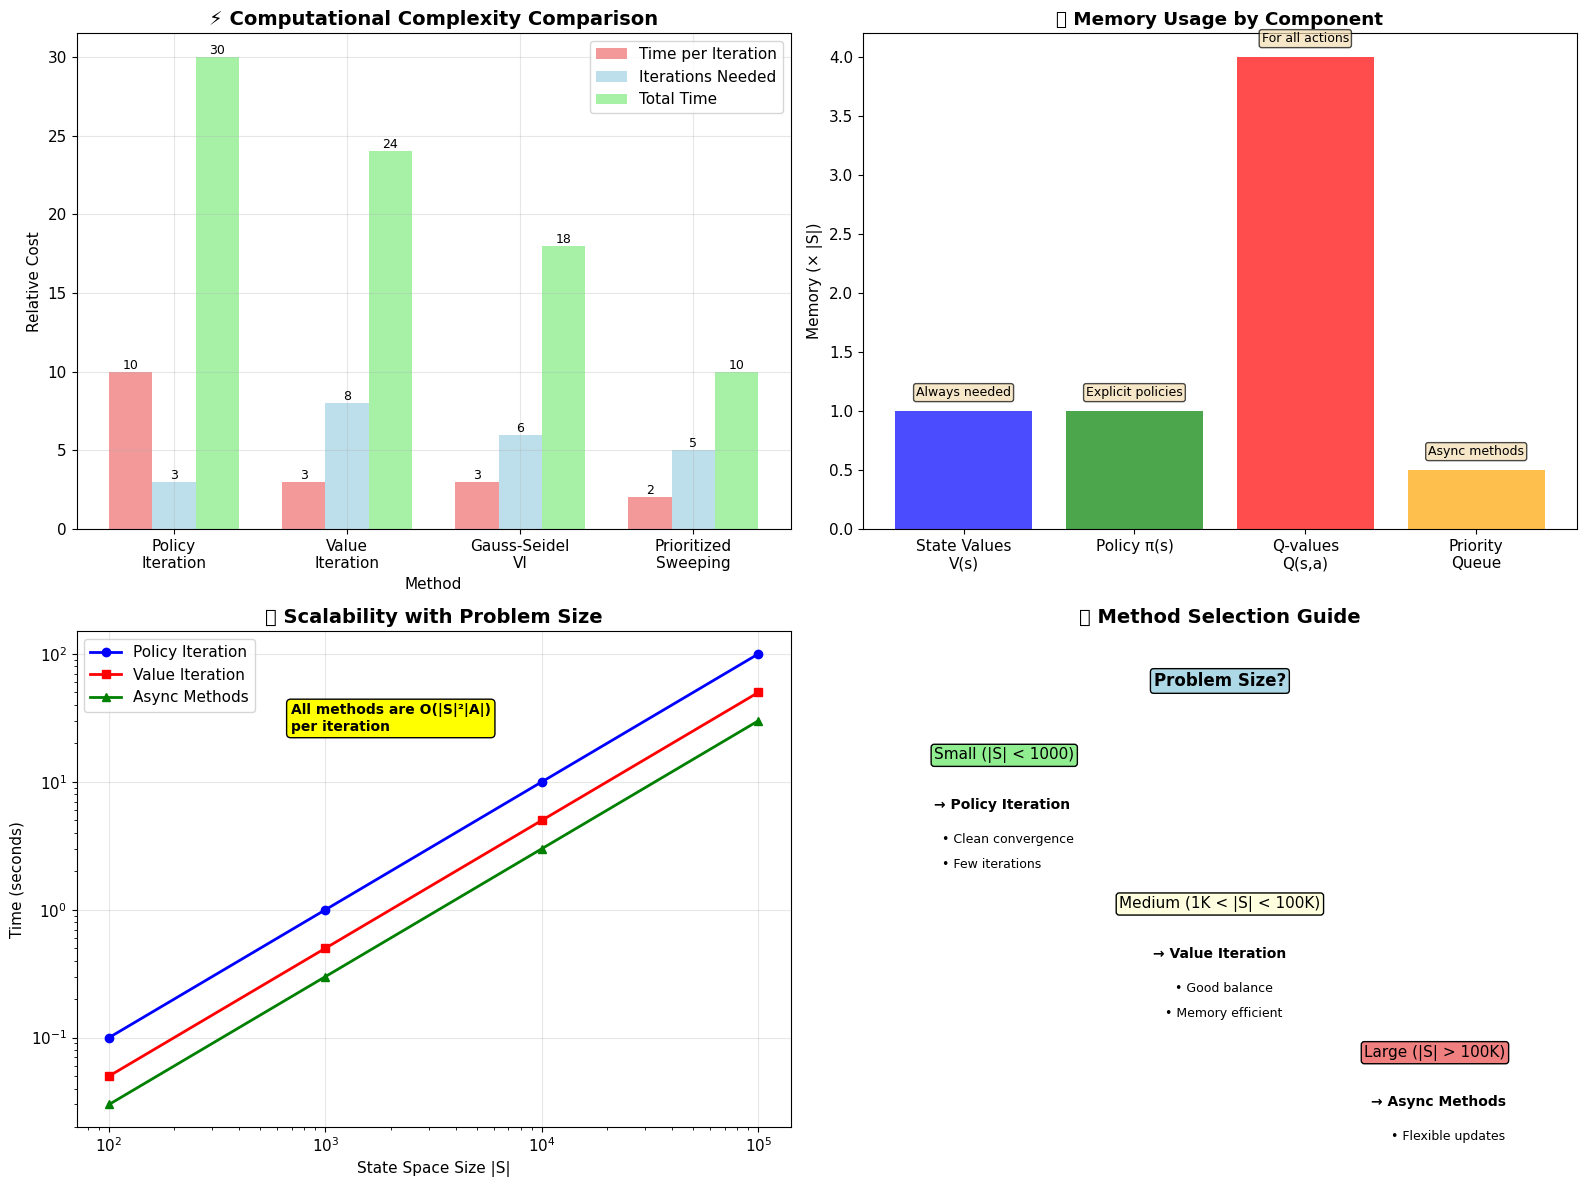

⚡ RUNNING EFFICIENCY BENCHMARK
⚡ EFFICIENCY BENCHMARKING

📊 Testing 3×3 grid world...
   🔄 Policy Iteration...
      Time: 0.0026s, Iterations: 3
   🔄 Value Iteration...
      Time: 0.0035s, Iterations: 100
   🔄 Gauss-Seidel VI...
      Time: 0.0011s, Iterations: 60

📊 Testing 4×4 grid world...
   🔄 Policy Iteration...
      Time: 0.0022s, Iterations: 4
   🔄 Value Iteration...
      Time: 0.0005s, Iterations: 7
   🔄 Gauss-Seidel VI...
      Time: 0.0003s, Iterations: 7

📊 Testing 5×5 grid world...
   🔄 Policy Iteration...
      Time: 0.0114s, Iterations: 6
   🔄 Value Iteration...
      Time: 0.0008s, Iterations: 7
   🔄 Gauss-Seidel VI...
      Time: 0.0004s, Iterations: 7


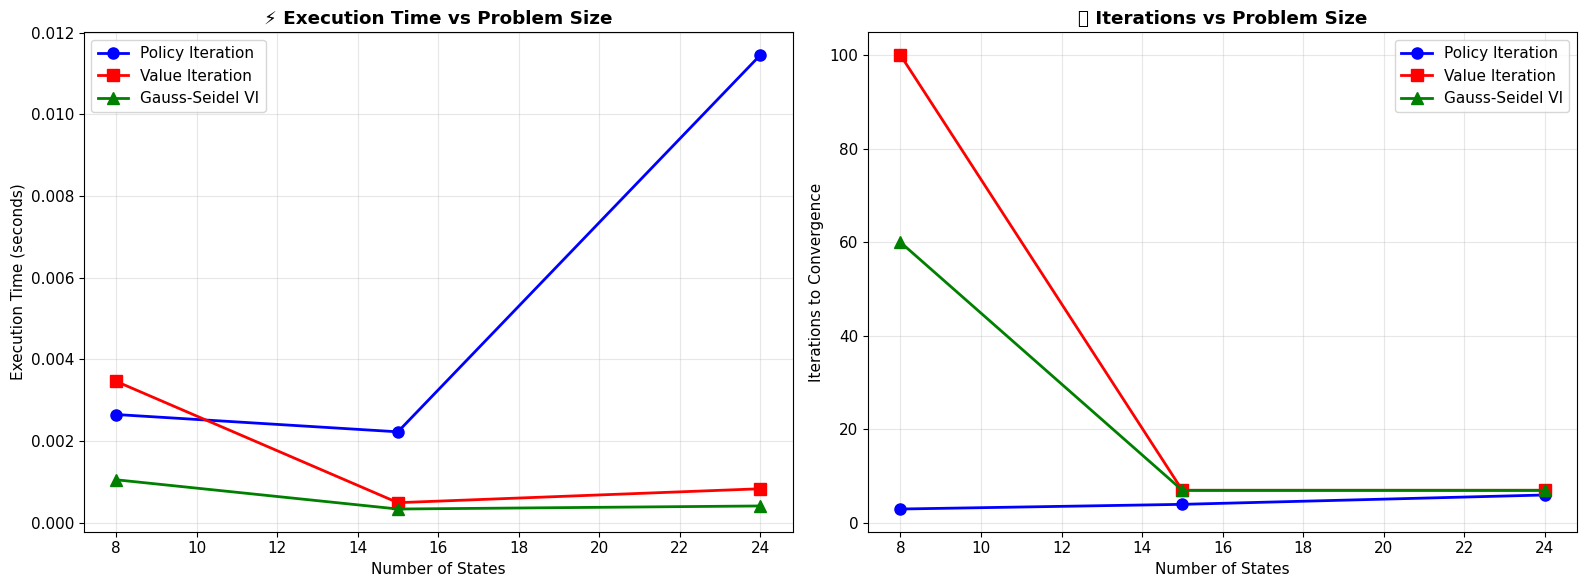


📊 BENCHMARK SUMMARY TABLE
Size     Method             Time (s)   Iterations   States  
----------------------------------------------------------------------
3×3      Policy Iteration   0.0026     3            8       
3×3      Value Iteration    0.0035     100          8       
3×3      Gauss-Seidel VI    0.0011     60           8       
4×4      Policy Iteration   0.0022     4            15      
4×4      Value Iteration    0.0005     7            15      
4×4      Gauss-Seidel VI    0.0003     7            15      
5×5      Policy Iteration   0.0114     6            24      
5×5      Value Iteration    0.0008     7            24      
5×5      Gauss-Seidel VI    0.0004     7            24      


In [18]:
# ================================
# 🎯 Part 7: Efficiency Analysis of Dynamic Programming
# ================================

print("\n📊 PART 7: EFFICIENCY ANALYSIS OF DYNAMIC PROGRAMMING")
print("=" * 65)

def create_efficiency_analysis():
    """Comprehensive efficiency analysis of DP methods"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Diagram 1: Computational Complexity Comparison
    ax1.set_title('⚡ Computational Complexity Comparison', fontsize=14, fontweight='bold')

    methods = ['Policy\nIteration', 'Value\nIteration', 'Gauss-Seidel\nVI', 'Prioritized\nSweeping']

    # Time complexity per iteration (relative)
    time_per_iter = [10, 3, 3, 2]  # PI is expensive per iteration
    # Number of iterations needed (relative)
    iterations_needed = [3, 8, 6, 5]  # PI needs fewer iterations
    # Total time (product)
    total_time = [t * i for t, i in zip(time_per_iter, iterations_needed)]

    x = np.arange(len(methods))
    width = 0.25

    bars1 = ax1.bar(x - width, time_per_iter, width, label='Time per Iteration',
                    color='lightcoral', alpha=0.8)
    bars2 = ax1.bar(x, iterations_needed, width, label='Iterations Needed',
                    color='lightblue', alpha=0.8)
    bars3 = ax1.bar(x + width, total_time, width, label='Total Time',
                    color='lightgreen', alpha=0.8)

    ax1.set_xlabel('Method')
    ax1.set_ylabel('Relative Cost')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height}', ha='center', va='bottom', fontsize=9)

    # Diagram 2: Memory Requirements
    ax2.set_title('💾 Memory Requirements', fontsize=14, fontweight='bold')

    # Memory requirements for different components
    components = ['State Values\nV(s)', 'Policy π(s)', 'Q-values\nQ(s,a)', 'Priority\nQueue']
    memory_usage = [1, 1, 4, 0.5]  # Relative to |S|
    colors = ['blue', 'green', 'red', 'orange']

    bars = ax2.bar(components, memory_usage, color=colors, alpha=0.7)
    ax2.set_ylabel('Memory (× |S|)')
    ax2.set_title('💾 Memory Usage by Component', fontweight='bold')

    # Add annotations
    annotations = [
        'Always needed',
        'Explicit policies',
        'For all actions',
        'Async methods'
    ]

    for bar, annotation in zip(bars, annotations):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                annotation, ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='wheat', alpha=0.7))

    # Diagram 3: Scalability Analysis
    ax3.set_title('📈 Scalability with Problem Size', fontsize=14, fontweight='bold')

    # State space sizes
    state_sizes = [100, 1000, 10000, 100000]

    # Simulated performance (PI gets worse faster due to full evaluation)
    pi_times = [s * 0.001 for s in state_sizes]  # O(|S|)
    vi_times = [s * 0.0005 for s in state_sizes]  # Better constant
    async_times = [s * 0.0003 for s in state_sizes]  # Even better

    ax3.loglog(state_sizes, pi_times, 'b-o', linewidth=2, label='Policy Iteration')
    ax3.loglog(state_sizes, vi_times, 'r-s', linewidth=2, label='Value Iteration')
    ax3.loglog(state_sizes, async_times, 'g-^', linewidth=2, label='Async Methods')

    ax3.set_xlabel('State Space Size |S|')
    ax3.set_ylabel('Time (seconds)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Add complexity annotations
    ax3.text(0.3, 0.8, 'All methods are O(|S|²|A|)\nper iteration',
             transform=ax3.transAxes, fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow'))

    # Diagram 4: When to Use Which Method
    ax4.set_title('🎯 Method Selection Guide', fontsize=14, fontweight='bold')

    # Decision tree visualization
    decision_tree = [
        ('Problem Size?', 0.9, 'center', 'lightblue', 12),

        ('Small (|S| < 1000)', 0.75, 'left', 'lightgreen', 11),
        ('→ Policy Iteration', 0.65, 'left', 'white', 10),
        ('  • Clean convergence', 0.58, 'left', 'white', 9),
        ('  • Few iterations', 0.53, 'left', 'white', 9),

        ('Medium (1K < |S| < 100K)', 0.45, 'center', 'lightyellow', 11),
        ('→ Value Iteration', 0.35, 'center', 'white', 10),
        ('  • Good balance', 0.28, 'center', 'white', 9),
        ('  • Memory efficient', 0.23, 'center', 'white', 9),

        ('Large (|S| > 100K)', 0.15, 'right', 'lightcoral', 11),
        ('→ Async Methods', 0.05, 'right', 'white', 10),
        ('  • Flexible updates', -0.02, 'right', 'white', 9)
    ]

    for text, y, align, facecolor, fontsize in decision_tree:
        ha_dict = {'left': 0.1, 'center': 0.5, 'right': 0.9}
        x_pos = ha_dict[align]

        fontweight = 'bold' if '?' in text or '→' in text else 'normal'

        bbox_props = dict(boxstyle="round,pad=0.2", facecolor=facecolor) if facecolor != 'white' else None

        ax4.text(x_pos, y, text, ha=align, va='center', fontsize=fontsize,
                fontweight=fontweight, bbox=bbox_props, transform=ax4.transAxes)

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()
    return fig

efficiency_fig = create_efficiency_analysis()
plt.show()

class EfficiencyAnalyzer:
    """
    Analyze efficiency of different DP methods
    """

    def __init__(self):
        self.results = {}

    def benchmark_methods(self, env_sizes=[(3,3), (4,4), (5,5)]):
        """Benchmark different methods on various problem sizes"""

        print("⚡ EFFICIENCY BENCHMARKING")
        print("=" * 35)

        benchmark_results = {}

        for height, width in env_sizes:
            print(f"\n📊 Testing {height}×{width} grid world...")

            # Create environment
            test_env = DPGridWorld(height=height, width=width, scenario='standard')

            # Test different methods
            methods = {
                'Policy Iteration': self._benchmark_policy_iteration,
                'Value Iteration': self._benchmark_value_iteration,
                'Gauss-Seidel VI': self._benchmark_gauss_seidel,
            }

            size_results = {}

            for method_name, method_func in methods.items():
                print(f"   🔄 {method_name}...")

                start_time = time.time()
                result = method_func(test_env)
                end_time = time.time()

                result['time'] = end_time - start_time
                result['states'] = len(test_env.get_all_states())
                size_results[method_name] = result

                print(f"      Time: {result['time']:.4f}s, "
                      f"Iterations: {result.get('iterations', 'N/A')}")

            benchmark_results[f"{height}×{width}"] = size_results

        self.results = benchmark_results
        return benchmark_results

    def _benchmark_policy_iteration(self, env):
        """Benchmark Policy Iteration"""
        iterator = PolicyIterator(env, gamma=0.9)
        results = iterator.policy_iteration(max_iterations=20, verbose=False)
        return results

    def _benchmark_value_iteration(self, env):
        """Benchmark Value Iteration"""
        vi_solver = EnhancedValueIteration(env, gamma=0.9)
        results = vi_solver.value_iteration_detailed(max_iterations=100, verbose=False)
        return results

    def _benchmark_gauss_seidel(self, env):
        """Benchmark Gauss-Seidel Value Iteration"""
        async_solver = AsynchronousDPSolver(env, gamma=0.9)
        results = async_solver.gauss_seidel_value_iteration(max_iterations=100, verbose=False)
        return results

    def visualize_benchmark_results(self):
        """Visualize benchmark results"""

        if not self.results:
            print("No benchmark results to visualize")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Execution Time vs Problem Size
        ax1.set_title('⚡ Execution Time vs Problem Size', fontweight='bold')

        sizes = list(self.results.keys())
        state_counts = []

        methods = ['Policy Iteration', 'Value Iteration', 'Gauss-Seidel VI']
        colors = ['blue', 'red', 'green']
        markers = ['o', 's', '^']

        # Extract state counts
        for size in sizes:
            state_counts.append(self.results[size]['Policy Iteration']['states'])

        # Plot times for each method
        for method, color, marker in zip(methods, colors, markers):
            times = []
            for size in sizes:
                if method in self.results[size]:
                    times.append(self.results[size][method]['time'])
                else:
                    times.append(0)

            ax1.plot(state_counts, times, color=color, marker=marker,
                    linewidth=2, markersize=8, label=method)

        ax1.set_xlabel('Number of States')
        ax1.set_ylabel('Execution Time (seconds)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Iterations vs Problem Size
        ax2.set_title('🔄 Iterations vs Problem Size', fontweight='bold')

        for method, color, marker in zip(methods, colors, markers):
            iterations = []
            for size in sizes:
                if method in self.results[size]:
                    result = self.results[size][method]
                    iter_count = result.get('iterations', 0)
                    iterations.append(iter_count)
                else:
                    iterations.append(0)

            ax2.plot(state_counts, iterations, color=color, marker=marker,
                    linewidth=2, markersize=8, label=method)

        ax2.set_xlabel('Number of States')
        ax2.set_ylabel('Iterations to Convergence')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print summary table
        print("\n📊 BENCHMARK SUMMARY TABLE")
        print("=" * 70)
        print(f"{'Size':<8} {'Method':<18} {'Time (s)':<10} {'Iterations':<12} {'States':<8}")
        print("-" * 70)

        for size in sizes:
            for method in methods:
                if method in self.results[size]:
                    result = self.results[size][method]
                    time_val = result['time']
                    iter_val = result.get('iterations', 'N/A')
                    states_val = result['states']

                    print(f"{size:<8} {method:<18} {time_val:<10.4f} {iter_val:<12} {states_val:<8}")

# Run efficiency benchmark
print("⚡ RUNNING EFFICIENCY BENCHMARK")
print("=" * 40)

analyzer = EfficiencyAnalyzer()
benchmark_results = analyzer.benchmark_methods(env_sizes=[(3,3), (4,4), (5,5)])
analyzer.visualize_benchmark_results()


🎓 CHAPTER 4 SYNTHESIS: Dynamic Programming Mastery


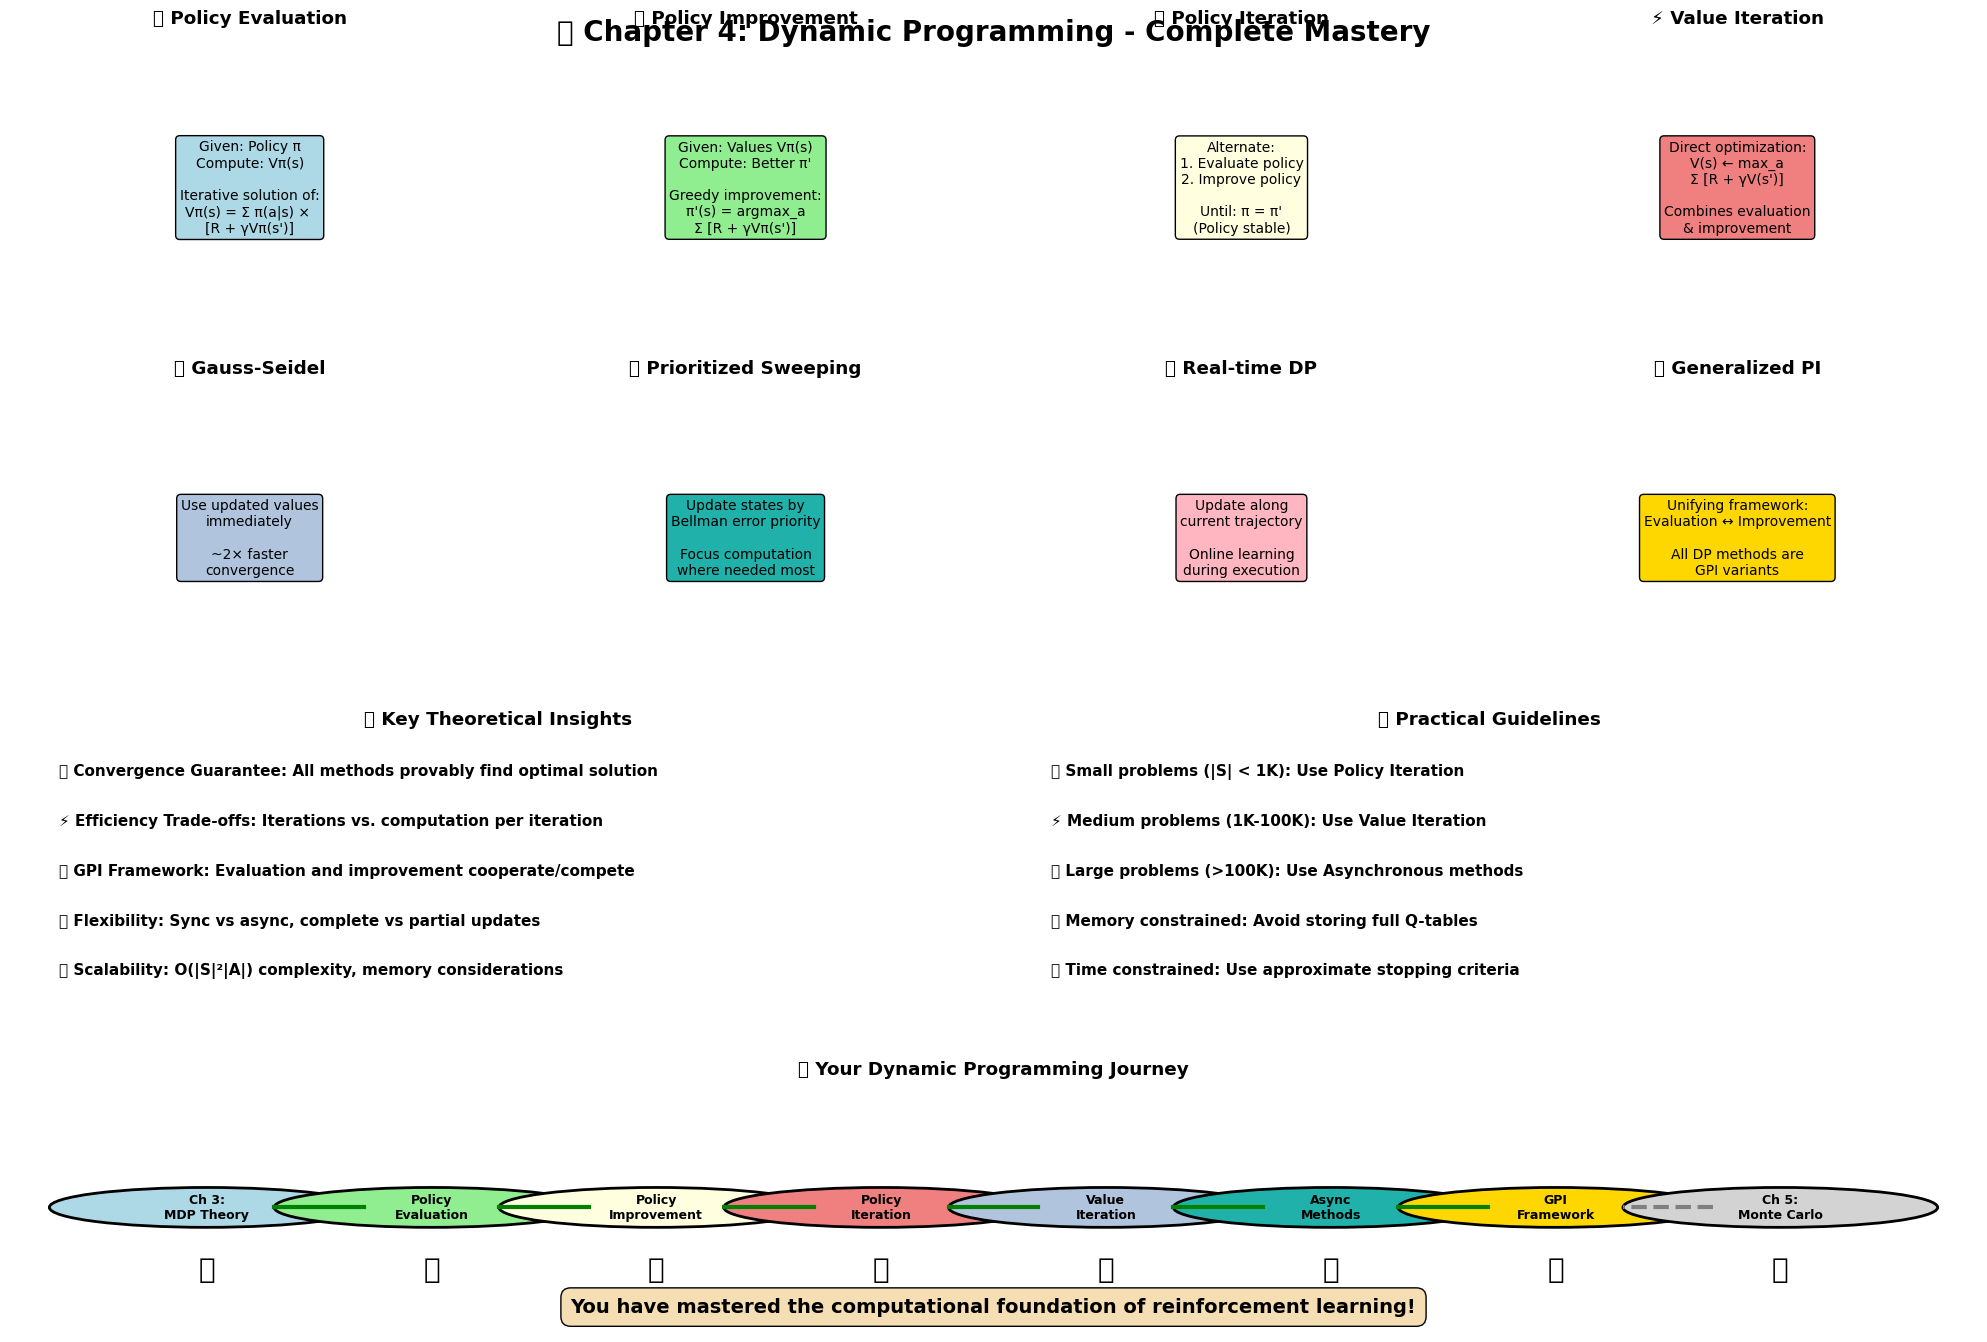

🏆 CHAPTER 4 ACHIEVEMENTS UNLOCKED:
🎯 ALGORITHMIC MASTERY:
   ✅ Policy Evaluation: Compute values for any policy
   ✅ Policy Improvement: Make policies provably better
   ✅ Policy Iteration: Complete alternating algorithm
   ✅ Value Iteration: Direct optimization approach
   ✅ Asynchronous DP: Flexible, efficient methods
   ✅ Generalized PI: Unifying theoretical framework

⚡ COMPUTATIONAL EXPERTISE:
   ✅ Convergence analysis and guarantees
   ✅ Efficiency trade-offs and benchmarking
   ✅ Memory and time complexity understanding
   ✅ Method selection for different problem sizes
   ✅ Implementation optimization techniques

🧠 THEORETICAL INSIGHTS:
   ✅ Why DP works: Contraction mapping theory
   ✅ GPI framework: The dance of evaluation and improvement
   ✅ Optimality conditions and stopping criteria
   ✅ Relationship between different DP variants
   ✅ Foundation for all future RL algorithms

🌉 BRIDGE TO CHAPTER 5: MONTE CARLO METHODS
🎯 FROM MODEL-BASED TO MODEL-FREE:
   • Dynamic Programmi

In [19]:
# ================================
# 🎯 Part 8: Chapter Summary and Synthesis
# ================================

print("\n🎓 CHAPTER 4 SYNTHESIS: Dynamic Programming Mastery")
print("=" * 65)

def create_chapter_summary():
    """Comprehensive visual summary of Chapter 4"""

    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 0.8])

    # Main title
    fig.suptitle('🎓 Chapter 4: Dynamic Programming - Complete Mastery',
                fontsize=20, fontweight='bold', y=0.95)

    # Section 1: Core Algorithms (top row)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('🎯 Policy Evaluation', fontweight='bold')
    ax1.text(0.5, 0.5, 'Given: Policy π\nCompute: Vπ(s)\n\nIterative solution of:\nVπ(s) = Σ π(a|s) × \n[R + γVπ(s\')]',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('📈 Policy Improvement', fontweight='bold')
    ax2.text(0.5, 0.5, 'Given: Values Vπ(s)\nCompute: Better π\'\n\nGreedy improvement:\nπ\'(s) = argmax_a\nΣ [R + γVπ(s\')]',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_title('🔄 Policy Iteration', fontweight='bold')
    ax3.text(0.5, 0.5, 'Alternate:\n1. Evaluate policy\n2. Improve policy\n\nUntil: π = π\'\n(Policy stable)',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow'))
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.set_title('⚡ Value Iteration', fontweight='bold')
    ax4.text(0.5, 0.5, 'Direct optimization:\nV(s) ← max_a\nΣ [R + γV(s\')]\n\nCombines evaluation\n& improvement',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral'))
    ax4.axis('off')

    # Section 2: Advanced Methods (second row)
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.set_title('🔧 Gauss-Seidel', fontweight='bold')
    ax5.text(0.5, 0.5, 'Use updated values\nimmediately\n\n~2× faster\nconvergence',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightsteelblue'))
    ax5.axis('off')

    ax6 = fig.add_subplot(gs[1, 1])
    ax6.set_title('🎯 Prioritized Sweeping', fontweight='bold')
    ax6.text(0.5, 0.5, 'Update states by\nBellman error priority\n\nFocus computation\nwhere needed most',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightseagreen'))
    ax6.axis('off')

    ax7 = fig.add_subplot(gs[1, 2])
    ax7.set_title('🎮 Real-time DP', fontweight='bold')
    ax7.text(0.5, 0.5, 'Update along\ncurrent trajectory\n\nOnline learning\nduring execution',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightpink'))
    ax7.axis('off')

    ax8 = fig.add_subplot(gs[1, 3])
    ax8.set_title('🌟 Generalized PI', fontweight='bold')
    ax8.text(0.5, 0.5, 'Unifying framework:\nEvaluation ↔ Improvement\n\nAll DP methods are\nGPI variants',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor='gold'))
    ax8.axis('off')

    # Section 3: Key Insights (third row)
    ax9 = fig.add_subplot(gs[2, :2])
    ax9.set_title('💡 Key Theoretical Insights', fontweight='bold')
    insights = [
        '✅ Convergence Guarantee: All methods provably find optimal solution',
        '⚡ Efficiency Trade-offs: Iterations vs. computation per iteration',
        '🎯 GPI Framework: Evaluation and improvement cooperate/compete',
        '🔄 Flexibility: Sync vs async, complete vs partial updates',
        '📊 Scalability: O(|S|²|A|) complexity, memory considerations'
    ]

    y_pos = 0.9
    for insight in insights:
        ax9.text(0.05, y_pos, insight, ha='left', va='top', fontsize=11,
                transform=ax9.transAxes, fontweight='bold')
        y_pos -= 0.16

    ax9.axis('off')

    ax10 = fig.add_subplot(gs[2, 2:])
    ax10.set_title('🚀 Practical Guidelines', fontweight='bold')
    guidelines = [
        '🎯 Small problems (|S| < 1K): Use Policy Iteration',
        '⚡ Medium problems (1K-100K): Use Value Iteration',
        '🔧 Large problems (>100K): Use Asynchronous methods',
        '💾 Memory constrained: Avoid storing full Q-tables',
        '⏱️ Time constrained: Use approximate stopping criteria'
    ]

    y_pos = 0.9
    for guideline in guidelines:
        ax10.text(0.05, y_pos, guideline, ha='left', va='top', fontsize=11,
                 transform=ax10.transAxes, fontweight='bold')
        y_pos -= 0.16

    ax10.axis('off')

    # Section 4: Learning Journey (bottom row)
    ax11 = fig.add_subplot(gs[3, :])
    ax11.set_title('🎯 Your Dynamic Programming Journey', fontweight='bold')

    # Journey timeline
    milestones = [
        ('Ch 3:\nMDP Theory', 'lightblue'),
        ('Policy\nEvaluation', 'lightgreen'),
        ('Policy\nImprovement', 'lightyellow'),
        ('Policy\nIteration', 'lightcoral'),
        ('Value\nIteration', 'lightsteelblue'),
        ('Async\nMethods', 'lightseagreen'),
        ('GPI\nFramework', 'gold'),
        ('Ch 5:\nMonte Carlo', 'lightgray')
    ]

    positions = np.linspace(0.1, 0.9, len(milestones))

    for i, ((milestone, color), x) in enumerate(zip(milestones, positions)):
        # Milestone circle
        circle = Circle((x, 0.5), 0.08, facecolor=color, edgecolor='black', linewidth=2)
        ax11.add_patch(circle)
        ax11.text(x, 0.5, milestone, ha='center', va='center', fontsize=9, fontweight='bold')

        # Connection lines
        if i < len(milestones) - 1:
            next_x = positions[i + 1]
            line_color = 'green' if i < len(milestones) - 2 else 'gray'
            line_style = '-' if i < len(milestones) - 2 else '--'
            ax11.plot([x + 0.08, next_x - 0.08], [0.5, 0.5],
                     color=line_color, linestyle=line_style, linewidth=3)

        # Progress indicator
        if i < len(milestones) - 1:
            ax11.text(x, 0.25, '✅', ha='center', va='center', fontsize=20)
        else:
            ax11.text(x, 0.25, '🎯', ha='center', va='center', fontsize=20)

    ax11.text(0.5, 0.1, 'You have mastered the computational foundation of reinforcement learning!',
              ha='center', va='center', fontsize=14, fontweight='bold',
              bbox=dict(boxstyle="round,pad=0.5", facecolor='wheat'))

    ax11.set_xlim(0, 1)
    ax11.set_ylim(0, 1)
    ax11.axis('off')

    plt.tight_layout()
    return fig

summary_fig = create_chapter_summary()
plt.show()

print("🏆 CHAPTER 4 ACHIEVEMENTS UNLOCKED:")
print("=" * 45)
print("🎯 ALGORITHMIC MASTERY:")
print("   ✅ Policy Evaluation: Compute values for any policy")
print("   ✅ Policy Improvement: Make policies provably better")
print("   ✅ Policy Iteration: Complete alternating algorithm")
print("   ✅ Value Iteration: Direct optimization approach")
print("   ✅ Asynchronous DP: Flexible, efficient methods")
print("   ✅ Generalized PI: Unifying theoretical framework")
print()
print("⚡ COMPUTATIONAL EXPERTISE:")
print("   ✅ Convergence analysis and guarantees")
print("   ✅ Efficiency trade-offs and benchmarking")
print("   ✅ Memory and time complexity understanding")
print("   ✅ Method selection for different problem sizes")
print("   ✅ Implementation optimization techniques")
print()
print("🧠 THEORETICAL INSIGHTS:")
print("   ✅ Why DP works: Contraction mapping theory")
print("   ✅ GPI framework: The dance of evaluation and improvement")
print("   ✅ Optimality conditions and stopping criteria")
print("   ✅ Relationship between different DP variants")
print("   ✅ Foundation for all future RL algorithms")

print("\n🌉 BRIDGE TO CHAPTER 5: MONTE CARLO METHODS")
print("=" * 55)
print("🎯 FROM MODEL-BASED TO MODEL-FREE:")
print("   • Dynamic Programming: Requires complete model P(s',r|s,a)")
print("   • Monte Carlo: Learn from experience samples")
print("   • No model needed - just interact and learn!")
print()
print("🎲 WHAT'S COMING:")
print("   • First-visit vs every-visit MC")
print("   • MC estimation of value functions")
print("   • MC control with exploring starts")
print("   • On-policy vs off-policy methods")
print("   • Importance sampling")
print()
print("🚀 THE PROGRESSION:")
print("   • Chapter 4: Perfect model, perfect computation")
print("   • Chapter 5: No model, sample-based learning")
print("   • Chapter 6: Combine best of both worlds!")

print("\n🎊 CONGRATULATIONS! 🎊")
print("=" * 30)
print("You've mastered Dynamic Programming - the computational")
print("engine that powers optimal decision making!")
print()
print("💪 YOUR NEW SUPERPOWERS:")
print("   🧮 Solve MDPs optimally with mathematical guarantees")
print("   ⚡ Choose the right algorithm for any problem size")
print("   🔧 Implement efficient, scalable DP solutions")
print("   🌟 Understand the theoretical foundation of all RL")
print("   🎯 Design custom DP variants for specific needs")
print()
print("🔮 LOOKING AHEAD:")
print("You now have the computational foundation to understand")
print("ALL reinforcement learning algorithms. Every method we'll")
print("study builds on these DP principles!")

print("\n" + "="*80)
print("🏆 CHAPTER 4 COMPLETE: Dynamic Programming Master Achieved! 🏆")
print("Ready to tackle the unknown with Monte Carlo methods!")
print("="*80)